# <font color='blue'>Capstone A</font>
## <font color='blue'>Using Hospital Bed Capacity Prediction During COVID-19 to Determine Feature Importance</font>

<b>Abstract.</b>  The Covid-19 pandemic has led to the generation of multiple types of models and feature selection methods in the field of Machine Learning. Since there has been rapid change and new regulations being introduced during the pandemic, modeling and feature selection methods have become increasingly complicated. The purpose of this study is to investigate and dive into key features to help create an understanding for the public and help show preventive measures. This study focuses on the exploration of feature selection though building multiple models, one simple linear model, one more complex model and an average of the two for prediction on impatient hospitalization rates.<br><br>

<b>Authors:</b>
* Helene Barrera, SMU MSDS Student
* Justin Ehly, SMU MSDS Student
* Blake Freeman, SMU MSDS Student
* Brad Blanchard, SMU Faculty
* Chris Papesh, UNLV Faculty

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import copy


In [2]:
# helper function to correctly point Justin's python to the correct platform (windows vs osX)
def justin_chdir():
    from sys import platform

    # windows: be sure so to change the <file> location
    if platform == 'win32': os.chdir(r'C:\Users\justi\github\covid_Capstone\data')

    # Mac OSX: be sure so to change the <file> location
    elif platform == 'darwin': os.chdir('/users/justinehly/github/covid_capstone/data')

justin_chdir()

In [3]:
#Helene's data import
#os.chdir(r'D:\MS in Data Science\Capstone\Data')

In [4]:
states = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL',
            'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
            'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
            'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

In [5]:
df = pd.read_csv('OxCGRT_latest.csv', low_memory=False)

# create dataframe of only USA State level data
oxford = copy.deepcopy(df.loc[(df.CountryCode == 'USA') & (~df.RegionCode.str[-2:].isin(states))]) 
oxford.reset_index(drop=True, inplace=True)

# create dataframe of the states level data
oxstates = copy.deepcopy(df.loc[(df.CountryCode == 'USA') & (df.RegionCode.str[-2:].isin(states))]) 

# add RegionCode to the USA data
oxford.RegionCode = 'US'

# fix state codes
oxstates.RegionCode = oxstates.RegionCode.str[-2:]

del df

In [6]:
#oxford.info()
#set(oxstates.RegionCode)

In [7]:
#oxstates.info()


In [8]:
# fix date column
from datetime import datetime

def fix_cols(data):
    # put the state column first (this will help when dealing with data later)
    cols = list(data.columns)
    cols = [cols[-1]] + cols[:-1]
    data = data[cols]
    return data

def fix_date(data):
    data.Date = pd.to_datetime(data.Date, format='%Y%m%d')

    # create the state column for the data merge (this was determined at a later date from the initial pull and added back into the main pipeline)
    data['state'] = data.RegionCode.str.slice(-2)

    # put the state column first (this will help when dealing with data later)
    data = fix_cols(data)

    # drop 'CountryName', 'CountryCode', 'RegionName', 'RegionCode','Jurisdiction' because they will not be needed moving forward since we are working at the state level and only in the USA
    # drop the wildcard since it is blank
    # drop StringentLegacyIndexForDisplay because it is recommended to not use and is an approximation of the newer StringencyIndex. Documentation says it can be included for continuity purposes
    # drop the index columns that do not contain the name display
    
    data = data.drop(columns =['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
        'Jurisdiction', 'M1_Wildcard', 'StringencyLegacyIndexForDisplay', 'StringencyLegacyIndex', 'StringencyIndex', 'GovernmentResponseIndex', 
        'ContainmentHealthIndex', 'EconomicSupportIndex'])
    return data

# reduce oxford df to friday 01-24-20 thru thursday 05-27-21 to match the other data set from the USGovt website
def week_reset(data):
    data.reset_index(inplace=True, drop=True)
    start_date = pd.to_datetime('20200327')  
    end_date = pd.to_datetime('20210923')
    date_reduce_idx = np.where((data.Date >= start_date) & (data.Date <= end_date))
    data = data.loc[date_reduce_idx]
    data.reset_index(inplace=True, drop=True)
    min(data.Date), max(data.Date)
    return data





In [9]:
# get date range


oxford = fix_date(oxford)
oxstates = fix_date(oxstates)

oxford = week_reset(oxford)
oxstates = week_reset(oxstates)
print('Total weeks in the oxford dataset: %d' % (oxford.shape[0]/7))
print('Total weeks in the oxstates dataset: %d' % (oxstates.shape[0]/7/51))
print(oxford.Date.min(), oxford.Date.max())
print(oxstates.Date.min(), oxford.Date.max())




Total weeks in the oxford dataset: 78
Total weeks in the oxstates dataset: 78
2020-03-27 00:00:00 2021-09-23 00:00:00
2020-03-27 00:00:00 2021-09-23 00:00:00


---
### <font color='blue'>Missing Values</font>
---
codebook https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md

- <b>Indidcators and Flags C1 - H8</b> 
    - Indicators (with the exception of E3 (USD) 0 = no new spending that day, E4 (USD) 0 = no new spending that day, H4 (USD)  0 = no new spending that day, H5 (USD) 0 = no new spending that day and M1) are oridinal and used to compute the indicies so should remain ordinal, but as integers and within the original range
    - Flags are binary and are weights for the indicators so NaN are ok to impute at 0, if there is NaN between 0-1, then it is suggested to take the average to via interpolation to not create unnecessary bias
    - Index are computed values from the Indicators and corresponding Flags based on algorithms. 
        - There are 2 versions of the index reported, 
            - Regular version that will return null there is not enough data for the calcutionn
            - ***Display version that is a smoother version and is extrapolated using the previous 7 days if there is complete data \* <font color='blue'>Suggest to use this version</font>***
            - https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/index_methodology.md

    <br><br>
- <b>Changes to be aware of:</b>
    - 27 September 2021: E3, E4 and H4 no long updated...suggest to drop these since they are not used to calculate any of the index measures
    - 28 June 2021: v3.3 presenting the imputed vaccine indicators (V2 summary and V3 summary) into a separate table
    - 21 June 2021: v3.02 edits to vaccine policy indicators table, fixing age ranges12 June 2021: v3.01 added section for vaccine policies
    - 5 May 2021: v2.10 added 'or all businesses open with alterations resulting in significant differences compared to non-Covid-19 operations' to C2 level 1
    - 18 March 2021: v2.9 added H8 'Protection of elderly people' indicator
    - 05 March 2021: v2.8 added 'non elderly' to definition of Clinically vulnerable groups' for H7
    - 14 January 2021: v2.7 changed 'country' to 'country/territory' and removed 'private' from C4 definition, replaced E1 flag 'formal sector workers only' to 'formal sector workers only or informal sector workers only', and 'informal workers too' to 'all workers'

In [10]:
# separate the indicators (orindal indicies) from the flags (binary weights) and the indicies for imputing
def sep_indicators(arg):
    cols = list(arg.columns)

    flags = [feat for feat in cols if feat[-4:] == 'Flag'] # just get a list of the flags

    indicators = [feat for feat in cols[2:34] if feat[-4:] != 'Flag'] # get a list of the indicators


    index = [item for item in cols[2:] if ((item not in flags) and (item not in indicators))] # list of the indicies without the state or date that are cols[:2]

    # Drop the Index rows and keep the IndexDisplay rows that are smoothed from the dataset creators
    #idx_to_drop = [i for i in index[2:] if (i[-7:] != 'Display')] 
    #display_idx = [i for i in index[2:] if (i[-7:] == 'Display')] # just keep the Display Indicies
    return flags, indicators #idx_to_drop, display_idx


# impute missing Flag values
def flag_impute(flags):
    flags = flags
    for x,c in enumerate(flags): # cycle through the cols
        for i in range(len(flags[c])):  # cycle through each row
            if np.isnan(flags.iloc[i,x]):
                if (i == 0): flags.iloc[i,x] = 0  # first cell is NaN set to 0
                elif (i != (len(flags[c])-1)):
                    # prior cell = 0 (0, NaN, next_cell)
                    if (flags.iloc[i-1,x] == 0) & (np.isnan(flags.iloc[i+1, x])): flags.iloc[i,x] = 0 # (0, NaN, NaN), set to 0
                    elif (flags.iloc[i-1,x] == 0) & (flags.iloc[i+1, x] == 1): flags.iloc[i,x] = 0.5 # (0, NaN, 1), set to 0.5
                    elif (flags.iloc[i-1,x] == 0) & (flags.iloc[i+1, x] == 0): flags.iloc[i,x] = 0 # (0, NaN, 0), set to 0

                    #pior cell = 1 (1, NaN, next_cell)
                    elif (flags.iloc[i-1,x] == 1) & (np.isnan(flags.iloc[i+1, x])): flags.iloc[i,x] = 0 # (1, NaN, NaN), set to 0
                    elif (flags.iloc[i-1,x] == 1) & (flags.iloc[i+1, x] == 1): flags.iloc[i,x] = 1 # (1, NaN, 1), set to 1
                    elif (flags.iloc[i-1,x] == 1) & (flags.iloc[i+1, x] == 0): flags.iloc[i,x] = 0.5 # (1, NaN, 0), set to 0.5 (not biased)
                else: flags.iloc[i,x] = flags.iloc[i-1,x]

    return flags



In [11]:

flags, indicators = sep_indicators(oxford)

flags_st, indicators_st = sep_indicators(oxstates)

# impute missing flag values for each dataset
oxford_flags = copy.deepcopy(oxford[flags])
oxford[flags] = flag_impute(oxford_flags)

oxstate_flags = copy.deepcopy(oxstates[flags_st])
oxstates[flags] = flag_impute(oxstate_flags)



In [12]:
# impute missing Indicator values using interpolate with limit not set, so that all NaN's in long stretches are filled in, more than likely with a zero.
# this data wll be combined to form weekly data and a mean of the index will be taken in each row and then rounded for a final result
def impute_indic(data):
    data = data.interpolate(method = 'linear', axis = 0, limit_direction = 'both').round()
    data = data.round(decimals=0) # these are indicators and technically categorical, but they are used to produce the index measures
    return data

oxford_ind = copy.deepcopy(oxford[indicators])
oxford[indicators] = impute_indic(oxford_ind)


oxstate_ind = copy.deepcopy(oxstates[indicators_st])
oxstates[indicators_st] = impute_indic(oxstate_ind)           
     

In [13]:
print(oxford[indicators].isnull().sum())



C1_School closing                        0
C2_Workplace closing                     0
C3_Cancel public events                  0
C4_Restrictions on gatherings            0
C5_Close public transport                0
C6_Stay at home requirements             0
C7_Restrictions on internal movement     0
C8_International travel controls         0
E1_Income support                        0
E2_Debt/contract relief                  0
E3_Fiscal measures                       0
E4_International support                 0
H1_Public information campaigns          0
H2_Testing policy                        0
H3_Contact tracing                       0
H4_Emergency investment in healthcare    0
H5_Investment in vaccines                0
H6_Facial Coverings                      0
H7_Vaccination policy                    0
H8_Protection of elderly people          0
dtype: int64


In [14]:
print(oxstates[indicators].isnull().sum())


C1_School closing                        0
C2_Workplace closing                     0
C3_Cancel public events                  0
C4_Restrictions on gatherings            0
C5_Close public transport                0
C6_Stay at home requirements             0
C7_Restrictions on internal movement     0
C8_International travel controls         0
E1_Income support                        0
E2_Debt/contract relief                  0
E3_Fiscal measures                       0
E4_International support                 0
H1_Public information campaigns          0
H2_Testing policy                        0
H3_Contact tracing                       0
H4_Emergency investment in healthcare    0
H5_Investment in vaccines                0
H6_Facial Coverings                      0
H7_Vaccination policy                    0
H8_Protection of elderly people          0
dtype: int64


In [15]:
# Note the next 2 code blocks should be similar, but keep in mind there si extraneous data included in the national rollup that wasn't covered by the state data, perhaps from non-states
# just double checking / sanity check
oxford['GovernmentResponseIndexForDisplay'].mean()

63.85463369963371

In [16]:
oxstates['GovernmentResponseIndexForDisplay'].mean()

57.41731826225127

### <font  color = 'blue'> Missing Index Values</font>
- missing data appears in large chunks and based on the documentation, raw index value are very stringent on returning a null value where display values are a smoothed variation based on a 7-day rolling perdiod.
- since the missing data for the index calculations was imputed, the NaN values can be computed using the formulas provided by the documentation.
- sub_index scores: I{j,t} = 100 * (v{j,t} - 0.5(F{j} - f{j,t})) / (N{j})  where t = time, we can ignore since we are calculating each day individually
    - Nj: max value of indicator
    - Fj: flag variable (1 = yes)
    - v{j,t}: policy value
    - f{j,t}: flag value

- index = 1/k * sum(Ij{j=i..k}) 
    - StringInd = k=9, sum(C1:C8, H1) / 9
    - GovResponse = k=16, sum(C1:C8, E1:E2, H1:H3, H6:H8)/ 16
    - ContainHealth = k=14, sum(C1:C8, H1:H3, H6:H8) / 14
    - EconSupp = k=2, sum(E1,E2) / 2


In [17]:
# formuals for each index
# create the Nj data

def ind_keys():
    ind_c = ['C'+str(i) for i in range(1,9,1)]
    ind_e = ['E1', 'E2']
    ind_h = ['H'+str(i) for i in range(1,9,1)]
    ind_h.remove('H4')
    ind_h.remove('H5')
    keys = ind_c + ind_e + ind_h
    return keys

def Nj():
    keys = ind_keys()    
    ind_ci = [3,3,2,4,2,3,2,4]
    ind_ei = [2,2]
    ind_hi = [2,3,2,4,5,3]
    values = ind_ci + ind_ei + ind_hi
    Nj = {key: value for key, value in zip(keys, values)}
    return Nj

def Fj():
    keys = ind_keys()
    values = [1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1]
    Fj = {key: value for key, value in zip(keys, values)}
    return Fj

keys = ind_keys()
Nj = {k: v for k,v in Nj().items()}
Fj = {k: v for k,v in Fj().items()}
#print(Nj)
#print(Fj)

# Build Indicators for missing Indices
def miss_display(data, idx):
    missing_display = copy.deepcopy(data[data[idx].isna().any(axis=1)]) #missing value indexes

    ran = range(2,len(list(missing_display.columns))-6,2)  # create a range that covers every other number, starting with index=2 (3rd position in the list/ df)
    for i, x in enumerate(ran):   
        vjt = np.array(missing_display.iloc[:,x])
        fjt = np.array(missing_display.iloc[:,x+1])
        missing_display[keys[i]] = np.where(vjt != 0, 100 * ((vjt - 0.5*(Fj[keys[i]] - fjt)) / Nj[keys[i]]), 0)
        #print(i,x,missing_display[keys[i]])

    #print(missing_display.iloc[:,-16:])

    # Impute Missing Indices
    # build a dictionary of k's and df cols
    values = {
        'col': idx,
        'k': [9, 16, 14, 2], 
        'idx': [np.r_[40:48,50], np.r_[40:56], np.r_[40:48,50:56], np.r_[48,49]]}

    #index_vars = {key: value for key, value in zip(display_index,values)}

    for i in range(4):
        condition = missing_display[values['col'][i]].isna() # only replace values that are NaN
        k = values['k'][i]  # k value for the index
        indicator_sum = missing_display.iloc[:,values['idx'][i]].sum(axis=1)  # sum of the indicators for the index value
        missing_display[values['col'][i]] = np.where(condition, indicator_sum / k, condition)
    
    return missing_display



In [18]:
# call the function for each dataset
display_idx = list(oxford.columns[-4:]) # display columns
#check for na
if oxford[display_idx].isna().sum().sum() > 0:
    oxford_missing_display = miss_display(oxford, display_idx)
    
    # assign the columns back that no longer have NaN
    mdx_usa = oxford_missing_display.index
    oxford.iloc[mdx_usa,np.r_[36:40]] = oxford_missing_display[display_idx] 


if oxstates[display_idx].isna().sum().sum() > 0:
    oxstates_missing_display = miss_display(oxstates, display_idx)
    
    # assign the columns back that no longer have NaN
    mdx_states = oxstates_missing_display.index
    oxstates.iloc[mdx_states,np.r_[36:40]] = oxstates_missing_display[display_idx] 
    
    




In [19]:
oxford.isna().sum().sum(), oxstates.isna().sum().sum()

(0, 0)

---
### <font color='green'>***Done Imputing Oxford Dataset***</font>
---

In [20]:
# combine the weeks in the oxford df
import datetime
#min(oxford.Date) + datetime.timedelta(6)
#oxford.groupby(by='Date').sum()[['ConfirmedCases']]
# look up pd.Grouper
# https://stackoverflow.com/questions/45281297/group-by-week-in-pandas/45281418
# create weekly combinations by state
# reference on the frequency: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

def weekly(data):
    data = copy.deepcopy(data)
    data = data.groupby(['state', pd.Grouper(key = 'Date', freq = 'W-THU')]).mean()
    return data


weekly_oxford = weekly(oxford)
weekly_oxstates = weekly(oxstates)

weekly_oxford.reset_index(inplace=True, drop=False)
weekly_oxstates.reset_index(inplace=True, drop=False)


In [21]:
nat = np.where(weekly_oxford.Date == '2021-09-23 00:00:00')[0]
sta = np.where(weekly_oxstates.Date == '2021-09-23 00:00:00')[0]

weekly_oxford.drop(index = nat, inplace=True)
weekly_oxstates.drop(index = sta, inplace=True)

weekly_oxford.reset_index(inplace=True, drop=False)
weekly_oxstates.reset_index(inplace=True, drop=False)

In [22]:
np.max(weekly_oxford.Date), np.max(weekly_oxstates.Date)

(Timestamp('2021-09-16 00:00:00'), Timestamp('2021-09-16 00:00:00'))

In [23]:
weekly_oxford

index state       Date  C1_School closing  C1_Flag  C2_Workplace closing  \
0       0    US 2020-04-02                3.0      0.0              3.000000   
1       1    US 2020-04-09                3.0      0.0              3.000000   
2       2    US 2020-04-16                3.0      0.0              3.000000   
3       3    US 2020-04-23                3.0      0.0              3.000000   
4       4    US 2020-04-30                3.0      0.0              3.000000   
..    ...   ...        ...                ...      ...                   ...   
72     72    US 2021-08-19                2.0      0.0              2.000000   
73     73    US 2021-08-26                2.0      0.0              2.000000   
74     74    US 2021-09-02                2.0      0.0              1.428571   
75     75    US 2021-09-09                2.0      0.0              1.000000   
76     76    US 2021-09-16                2.0      0.0              1.571429   

    C2_Flag  C3_Cancel public events  C3_Flag  C4_Restrictions on gatherings  \
0       0.0                 2.000000      0.0                            4.0   
1       0.0                 2.000000      0.0                            4.0   
2       0.0                 2.000000      0.0                            4.0   
3       0.0                 2.000000      0.0                            4.0   
4       0.0                 2.000000      0.0                            4.0   
..      ...                      ...      ...                            ...   
72      0.0                 1.000000      0.0                            4.0   
73      0.0                 1.000000      0.0                            4.0   
74      0.0                 1.571429      0.0                            4.0   
75      0.0                 2.000000      0.0                            4.0   
76      0.0                 2.000000      0.0                            4.0   

    ...  H7_Vaccination policy  H7_Flag  H8_Protection of elderly people  \
0   ...                    0.0      0.0                              2.0   
1   ...                    0.0      0.0                              2.0   
2   ...                    0.0      0.0                              2.0   
3   ...                    0.0      0.0                              2.0   
4   ...                    0.0      0.0                              2.0   
..  ...                    ...      ...                              ...   
72  ...                    5.0      1.0                              2.0   
73  ...                    5.0      1.0                              2.0   
74  ...                    5.0      1.0                              2.0   
75  ...                    5.0      1.0                              2.0   
76  ...                    5.0      1.0                              2.0   

    H8_Flag  ConfirmedCases  ConfirmedDeaths  StringencyIndexForDisplay  \
0       1.0    1.735569e+05      4754.142857                  72.690000   
1       1.0    3.831010e+05     15128.714286                  72.690000   
2       1.0    5.982887e+05     30085.142857                  72.690000   
3       1.0    7.991830e+05     45504.142857                  72.690000   
4       1.0    1.000834e+06     60040.857143                  72.690000   
..      ...             ...              ...                        ...   
72      0.0    3.700097e+07    623243.428571                  56.020000   
73      0.0    3.805490e+07    630928.571429                  56.020000   
74      0.0    3.917508e+07    640514.857143                  57.077143   
75      0.0    4.025522e+07    651316.142857                  57.870000   
76      0.0    4.132430e+07    663935.428571                  59.984286   

    GovernmentResponseIndexForDisplay  ContainmentHealthIndexForDisplay  \
0                           63.020000                         63.100000   
1                           65.254286                         65.648571   
2                           66.150000      

In [24]:
#weekly_oxstates


In [25]:
#weekly_oxford.info()
#weekly_oxstates.info()

In [26]:
indicators_flags = ['C1_School closing', 'C1_Flag', 'C2_Workplace closing',
       'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H5_Investment in vaccines', 'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'H8_Protection of elderly people', 'H8_Flag']
# round indicators
def indic_round(data):
       ind = copy.deepcopy(data[indicators_flags])
       ind = ind.round(decimals=0)
       return ind
       
weekly_oxford[indicators_flags] = indic_round(weekly_oxford)
weekly_oxstates[indicators_flags] = indic_round(weekly_oxstates)





In [27]:
#weekly_oxford.info()

In [28]:
#weekly_oxstates.info()

In [29]:
# drop E3, E4 and H4 indicators
def drop_cols(data):
    data.drop(columns = ['E3_Fiscal measures', 'E4_International support', 'H4_Emergency investment in healthcare'], inplace = True)
    return data

weekly_oxford = drop_cols(weekly_oxford)
weekly_oxstates = drop_cols(weekly_oxstates)

#desc = pd.DataFrame(weekly_oxford.describe())
#desc.T

In [30]:
#desc = pd.DataFrame(weekly_oxstates.describe())
#desc.T

In [31]:
71*len(states)

3621

In [32]:
weekly_oxford['H5_Investment in vaccines'].unique(), weekly_oxstates['H5_Investment in vaccines'].unique()

(array([0.00000000e+00, 1.71428571e+08, 2.28571429e+08, 2.78571429e+08,
        1.01142857e+08, 2.85714286e+08, 1.28571429e+09]),
 array([       0.,   142857., 15714286.,  1428571.]))

In [33]:
oxford.isna().sum().sum(), oxstates.isna().sum().sum()

(0, 0)

In [34]:
weekly_oxstates.Date

0      2020-04-02
1      2020-04-09
2      2020-04-16
3      2020-04-23
4      2020-04-30
          ...    
3922   2021-08-19
3923   2021-08-26
3924   2021-09-02
3925   2021-09-09
3926   2021-09-16
Name: Date, Length: 3927, dtype: datetime64[ns]

In [35]:
# align dates to start on Friday instead of ending on Thursday
days = datetime.timedelta(6)
weekly_oxstates.Date = weekly_oxstates.Date - days
weekly_oxstates.Date

0      2020-03-27
1      2020-04-03
2      2020-04-10
3      2020-04-17
4      2020-04-24
          ...    
3922   2021-08-13
3923   2021-08-20
3924   2021-08-27
3925   2021-09-03
3926   2021-09-10
Name: Date, Length: 3927, dtype: datetime64[ns]

--- 
### <font color='blue'> Import 2nd Dataset  </font>
- COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility.csv
- https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u
#### Notes About the Data
- Facility level data, aggregated on weekly basis F-Th.
- Main sources: (1) HHS TeleTracking and (2) directly to HHS Protect by state/ territorial health depts for their healthcare facilities
- Hosp Pop includs all hospitals registered with Centers for Medicare & Medicaid Services (CMS) as of 6-1-20. Includes non-CMS hospitals reporting since 7-15-20.
- It does not include psychiatric, rehabilitation, Indian Health Service (IHS) facilities, U.S. Department of Veterans Affairs (VA) facilities, Defense Health Agency (DHA) facilities, and religious non-medical facilities.
- No statistical information is provided for imputing missing values
- Suppression is applied to the file for sums and averages less than four (4). In these cases, the field will be replaced with “-999,999”
- For influenza fields listed in the file, the current HHS guidance marks these fields as optional. As a result, coverage of these elements are varied.
- Elements Reported
    - _coverage: how many times a facility reported that elements during collection week
    - _sum: sum of reports a facility provided that week
    - _avg: average of reports provided for a facility for that element during that collection week 
- On May 3, 2021, the following fields have been added to this data set.
    - hhs_ids
    - previous_day_admission_adult_covid_confirmed_7_day_coverage
    - previous_day_admission_pediatric_covid_confirmed_7_day_coverage
    - previous_day_admission_adult_covid_suspected_7_day_coverage
    - previous_day_admission_pediatric_covid_suspected_7_day_coverage
    - previous_week_personnel_covid_vaccinated_doses_administered_7_day_sum
    - total_personnel_covid_vaccinated_doses_none_7_day_sum
    - total_personnel_covid_vaccinated_doses_one_7_day_sum
    - total_personnel_covid_vaccinated_doses_all_7_day_sum
    - previous_week_patients_covid_vaccinated_doses_one_7_day_sum
    - previous_week_patients_covid_vaccinated_doses_all_7_day_sum

In [36]:
healthdata = pd.read_csv('COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility.csv', low_memory=False)
# reduce to match the dates in the oxford dataframe

healthdata['date'] = pd.to_datetime(healthdata.collection_week, format = '%Y/%m/%d')
healthdata.drop(columns = ['hospital_pk', 'ccn', 'hospital_name', 'address', 'city', 'zip', 'hospital_subtype', 'fips_code', 
                            'is_metro_micro', 'geocoded_hospital_address', 'hhs_ids','collection_week'], inplace = True)

# move date column to the front of the dataframe
healthdata = fix_cols(healthdata)

# remove territories outisde of USA (except DC) to match oxford dataset
healthdata.reset_index(inplace = True, drop = True)

# reduce to the dates set in the oxford dataframe
start_date = pd.to_datetime('20200327')
end_date = pd.to_datetime('20210910')
date_reduce_idx = np.where((healthdata.date >= start_date) & (healthdata.date <= end_date))
healthdata = healthdata.loc[date_reduce_idx]

print('Shape:', healthdata.shape)
#healthdata

Shape: (373415, 95)


In [37]:
# sort by date, state
healthdata = healthdata.sort_values(['state','date'])
healthdata.reset_index(drop=True,inplace=True)
#healthdata

In [38]:
np.min(healthdata.date), np.max(healthdata.date)  

(Timestamp('2020-03-27 00:00:00'), Timestamp('2021-09-10 00:00:00'))

In [39]:
# prior to imputing, replace all -999,999 with 0 because that represents a result < 4
healthdata.replace([-999999.0], np.nan, inplace = True) 

#healthdata

In [40]:
  
    
def imputer(data):
    # convert all initial NaN to 0                  
    for col in range(data.shape[1]):
        first_nonNaN = next(i for i in data.iloc[:,col] if not np.isnan(i))
        nonNaN_position = np.where(data.iloc[:,col] == first_nonNaN)[0][0]
        nan_idx = [i for i in range(nonNaN_position)]
        data.iloc[nan_idx,col] = 0
        
    # imperpolate the rest
    data = data.interpolate(axis = 0)  
    
    return data




In [41]:
# reminder the states variable from the beginning

impute_cols = list(healthdata.iloc[:,2:-1].columns)
st = list(set(healthdata.state))  # have to include the non state US territories
st.sort()

for s in st:
    healthdata.loc[healthdata['state'] == s, impute_cols] = imputer(healthdata.loc[healthdata['state'] == s, impute_cols])


In [42]:
#healthdata.loc[healthdata['state'] == 'AZ', impute_cols]

In [43]:
healthdata.isna().sum().sum()



0

In [44]:
# state roll-up
state_healthdata = copy.deepcopy(healthdata[healthdata.state.isin(states)]) 
state_healthdata = state_healthdata.groupby(['state','date']).sum() 
state_healthdata.reset_index(inplace = True, drop = False)

# national roll-up 
nat_healthdata = copy.deepcopy(healthdata)
nat_healthdata = nat_healthdata.groupby(['date']).sum() # sum since the data is collecte by location and deduped prior to publishing
nat_healthdata['state'] = 'US'

nat_healthdata.reset_index(inplace = True, drop = False)
#nat_healthdata


In [45]:
state_healthdata.isna().sum().sum(), nat_healthdata.isna().sum().sum()

(0, 0)

In [46]:
# remove sum and coverage features, we are just interested in the averages
def converge(data):
    cols = data.columns
    sum_cols = [i for i in cols if ('sum' in i)]
    coverage_cols = [i for i in cols if ('coverage' in i)]
    cols = sum_cols + coverage_cols
    data = data.drop(columns = cols)
    return data

state_healthdata = converge(state_healthdata)
nat_healthdata = converge(nat_healthdata)

#nat_healthdata.columns, state_healthdata.columns

---
### <font color='blue'>End of Dataset 2 Impute</font>
---
### <font color='blue'>Start Dataset Merge</font>


In [47]:
# make all columns lower case
    
weekly_oxford.columns = weekly_oxford.columns.str.lower()
weekly_oxstates.columns = weekly_oxstates.columns.str.lower()

In [48]:
max(state_healthdata.date), max(weekly_oxstates.date), weekly_oxstates.shape, state_healthdata.shape


(Timestamp('2021-09-10 00:00:00'),
 Timestamp('2021-09-10 00:00:00'),
 (3927, 38),
 (3927, 28))

In [49]:
def merge_data(govtracker, ushosp):
    data = govtracker.merge(ushosp, how = 'left', left_on = ('state','date'), right_on = ('state','date'))
    return data

covid = merge_data(weekly_oxford,nat_healthdata)
covid_state = merge_data(weekly_oxstates, state_healthdata)



In [50]:
print(covid.shape)
print(covid_state.shape)
print(covid.isna().sum().sum())
print(covid_state.isna().sum().sum())

(77, 64)
(3927, 64)
2002
0


In [51]:
w = np.where(covid_state.isna())
covid_state.iloc[list(set(w[0]))]

Empty DataFrame
Columns: [index, state, date, c1_school closing, c1_flag, c2_workplace closing, c2_flag, c3_cancel public events, c3_flag, c4_restrictions on gatherings, c4_flag, c5_close public transport, c5_flag, c6_stay at home requirements, c6_flag, c7_restrictions on internal movement, c7_flag, c8_international travel controls, e1_income support, e1_flag, e2_debt/contract relief, h1_public information campaigns, h1_flag, h2_testing policy, h3_contact tracing, h5_investment in vaccines, h6_facial coverings, h6_flag, h7_vaccination policy, h7_flag, h8_protection of elderly people, h8_flag, confirmedcases, confirmeddeaths, stringencyindexfordisplay, governmentresponseindexfordisplay, containmenthealthindexfordisplay, economicsupportindexfordisplay, total_beds_7_day_avg, all_adult_hospital_beds_7_day_avg, all_adult_hospital_inpatient_beds_7_day_avg, inpatient_beds_used_7_day_avg, all_adult_hospital_inpatient_bed_occupied_7_day_avg, total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg, total_adult_patients_hospitalized_confirmed_covid_7_day_avg, total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg, total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg, inpatient_beds_7_day_avg, total_icu_beds_7_day_avg, total_staffed_adult_icu_beds_7_day_avg, icu_beds_used_7_day_avg, staffed_adult_icu_bed_occupancy_7_day_avg, staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg, staffed_icu_adult_patients_confirmed_covid_7_day_avg, total_patients_hospitalized_confirmed_influenza_7_day_avg, icu_patients_confirmed_influenza_7_day_avg, total_patients_hospitalized_confirmed_influenza_and_covid_7_day_avg, previous_week_personnel_covid_vaccinated_doses_administered_7_day, total_personnel_covid_vaccinated_doses_none_7_day, total_personnel_covid_vaccinated_doses_one_7_day, total_personnel_covid_vaccinated_doses_all_7_day, previous_week_patients_covid_vaccinated_doses_one_7_day, previous_week_patients_covid_vaccinated_doses_all_7_day, is_corrected]
Index: []

[0 rows x 64 columns]

In [52]:
np.max(covid.date), np.max(covid_state.date)

(Timestamp('2021-09-16 00:00:00'), Timestamp('2021-09-10 00:00:00'))

In [53]:
# add in the vaccine release data
# https://www.immunize.org/newreleases/
# 2/27/21 FDA issues emergency use authorization for singe dose COVID-19 Vaccine (J&J) vaccine
# 5/10/21 FDA authorizes Pfizer-BioNTech COVID-19 vaccine for emergency use in adolescents
# 
pfizer_date = pd.to_datetime('20210510')
'''
if covid.Date > pfizer_date:
    covid['pfizer_authorization'] = 1
else:
    covid['pfizer_authorization'] = 0
'''
def pfizer(covid):
    covid['pfizer_auth'] = [1 if i > pfizer_date else 0 for i in covid.date]
    return covid 

covid = pfizer(covid)
covid_state = pfizer(covid_state)




In [54]:
# was decided in meeting with Chris on 2/7/22 that we would not use the flu season information

# add flu season to data Oct - March
# https://www.cdc.gov/flu/index.htm
import datetime

flu_month = [10, 11, 12, 1, 2, 3]

def flu(covid):
    covid['flu_season'] = [1 if i.month in flu_month else 0 for i in covid.date]
    return covid




In [55]:
w = np.where(covid_state.total_adult_patients_hospitalized_confirmed_covid_7_day_avg == 0)
# (array([  15,   16,   17, ..., 3975, 3976, 3977], dtype=int64),)
covid_state[['date','total_adult_patients_hospitalized_confirmed_covid_7_day_avg']].iloc[13:17]



date  total_adult_patients_hospitalized_confirmed_covid_7_day_avg
13 2020-06-26                                               0.00          
14 2020-07-03                                               0.00          
15 2020-07-10                                              33.25          
16 2020-07-17                                               8.40

In [56]:
# add week variable
week_dates = list(set(covid.date))
week_dates.sort()
nums = [i+1 for i,x in enumerate(week_dates)]
week = pd.DataFrame(columns=['date', 'week'])
week.date = week_dates
week.week = nums


covid['week'] = np.zeros((covid.shape[0],1))
covid_state['week'] = np.zeros((covid_state.shape[0],1))

for i,y in enumerate(week.date):
    for j,x in enumerate(covid.date):
        if x==y: 
            covid.iloc[j,65] = week.week[i]
            
for i,y in enumerate(week.date):
    for j,x in enumerate(covid_state.date):
        if x==y: 
            covid_state.iloc[j,65] = week.week[i]

In [57]:
def new_start(data):
    start_date = pd.to_datetime('20200710')
    date_reduce_idx = np.where(data.date >= start_date)
    data = data.loc[date_reduce_idx]
    data.reset_index(inplace=True, drop=True)
    min(data.date), max(data.date)
    return data
covid = new_start(covid)
covid_state = new_start(covid_state)


In [58]:
print(covid.isna().sum().sum())
print(covid_state.isna().sum().sum())

1612
0


### <font color='blue'>CDC VACCINATION DATA</font>

In [59]:
# add in CDC vaccination data

def import_vaccines(vacc):
    vacc = pd.read_csv('COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv', low_memory=False)
    vacc = vacc[['Date','Location','Administered_Dose1_Recip','Administered_Dose1_Pop_Pct','Series_Complete_Yes','Series_Complete_Pop_Pct']]
    vacc.Date = pd.to_datetime(vacc.Date, infer_datetime_format=True)
    vacc.columns = vacc.columns.str.lower()
    vacc.rename(columns = {'location':'state'}, inplace = True)
    vacc = vacc.sort_values(['state','date'])
    return vacc

def week_reset(data):
    data.reset_index(inplace=True, drop=True)
    start_date = pd.to_datetime('20201218')  
    end_date = pd.to_datetime('20210916')
    date_reduce_idx = np.where((data.date >= start_date) & (data.date <= end_date))
    data = data.loc[date_reduce_idx]
    data.reset_index(inplace=True, drop=True)
    print(min(data.date), max(data.date))
    return data


def state_reduce(data, states):
    # reduce to 51 state list
    st_idx = np.where(data.state.isin(states))
    data = data.loc[st_idx]
    data.reset_index(inplace=True, drop=True)
    return data

def weekly(data):
    data = copy.deepcopy(data)
    data = data.groupby(['state', pd.Grouper(key = 'date', freq = 'W-THU')]).max()
    data.reset_index(inplace=True, drop=False)
    return data

def vaccines(data, states):
    data = import_vaccines(data)
    data = week_reset(data)
    data = state_reduce(data, states)
    data = weekly(data)
    return data

vacc = pd.DataFrame()
vacc = vaccines(vacc, states)
vacc.info()




2020-12-18 00:00:00 2021-09-16 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   state                       1989 non-null   object        
 1   date                        1989 non-null   datetime64[ns]
 2   administered_dose1_recip    1989 non-null   int64         
 3   administered_dose1_pop_pct  1989 non-null   float64       
 4   series_complete_yes         1989 non-null   int64         
 5   series_complete_pop_pct     1989 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 93.4+ KB


In [60]:
# adjust the weeks to start on Friday and end on Thursday
days = datetime.timedelta(6)
vacc.date = vacc.date - days

In [61]:
# create df to add zeros and backfill dates to vacc df

start_date = pd.to_datetime('20200710')  
end_date = pd.to_datetime('20201211')
add_weeks = list(pd.date_range(start_date, end_date))
add_weeks = [d for d in add_weeks if d.weekday() == 4] # create a list of the weeks we need to add to the vacc dataframe
add_states = {k:add_weeks for k in states} # assign the dates to each state in  dict
new_dates = pd.DataFrame.from_dict(data = add_states, orient = 'index').stack()
new_dates = new_dates.reset_index()
new_dates.columns = ('state','drop','date')
new_dates.drop(columns = ['drop'], inplace = True)
new_dates.reset_index(inplace = True, drop = True)

for col in vacc.columns[2:]:
    new_dates[col] = 0
new_dates

state       date  administered_dose1_recip  administered_dose1_pop_pct  \
0       AK 2020-07-10                         0                           0   
1       AK 2020-07-17                         0                           0   
2       AK 2020-07-24                         0                           0   
3       AK 2020-07-31                         0                           0   
4       AK 2020-08-07                         0                           0   
...    ...        ...                       ...                         ...   
1168    WY 2020-11-13                         0                           0   
1169    WY 2020-11-20                         0                           0   
1170    WY 2020-11-27                         0                           0   
1171    WY 2020-12-04                         0                           0   
1172    WY 2020-12-11                         0                           0   

      series_complete_yes  series_complete_pop_pct  
0                       0                        0  
1                       0                        0  
2                       0                        0  
3                       0                        0  
4                       0                        0  
...                   ...                      ...  
1168                    0                        0  
1169                    0                        0  
1170                    0                        0  
1171                    0                        0  
1172                    0                        0  

[1173 rows x 6 columns]

In [62]:
# merge the df's new_dates and vacc
#new_dates.shape[0] + vacc.shape[0] == covid_state.shape[0]
vaccines = pd.concat([new_dates, vacc], axis=0)
vaccines.sort_values(by = ['state','date'], inplace=True, ignore_index=True)
vaccines


state       date  administered_dose1_recip  administered_dose1_pop_pct  \
0       AK 2020-07-10                         0                         0.0   
1       AK 2020-07-17                         0                         0.0   
2       AK 2020-07-24                         0                         0.0   
3       AK 2020-07-31                         0                         0.0   
4       AK 2020-08-07                         0                         0.0   
...    ...        ...                       ...                         ...   
3157    WY 2021-08-13                    253479                        43.8   
3158    WY 2021-08-20                    258558                        44.7   
3159    WY 2021-08-27                    264080                        45.6   
3160    WY 2021-09-03                    268605                        46.4   
3161    WY 2021-09-10                    273479                        47.3   

      series_complete_yes  series_complete_pop_pct  
0                       0                      0.0  
1                       0                      0.0  
2                       0                      0.0  
3                       0                      0.0  
4                       0                      0.0  
...                   ...                      ...  
3157               218300                     37.7  
3158               221333                     38.2  
3159               226176                     39.1  
3160               229509                     39.7  
3161               233559                     40.4  

[3162 rows x 6 columns]

In [63]:
covid_state.sort_values(by = ['state','date'], ignore_index=True, inplace = True)
covid_state.drop(columns = ['index'], inplace = True)
covid_state

state       date  c1_school closing  c1_flag  c2_workplace closing  \
0       AK 2020-07-10                3.0      1.0                   1.0   
1       AK 2020-07-17                3.0      1.0                   1.0   
2       AK 2020-07-24                3.0      0.0                   1.0   
3       AK 2020-07-31                3.0      0.0                   2.0   
4       AK 2020-08-07                3.0      0.0                   2.0   
...    ...        ...                ...      ...                   ...   
3157    WY 2021-08-13                0.0      0.0                   0.0   
3158    WY 2021-08-20                0.0      0.0                   0.0   
3159    WY 2021-08-27                0.0      0.0                   0.0   
3160    WY 2021-09-03                0.0      0.0                   0.0   
3161    WY 2021-09-10                0.0      0.0                   0.0   

      c2_flag  c3_cancel public events  c3_flag  \
0         1.0                      1.0      1.0   
1         1.0                      1.0      1.0   
2         0.0                      1.0      1.0   
3         0.0                      1.0      1.0   
4         0.0                      1.0      1.0   
...       ...                      ...      ...   
3157      0.0                      0.0      0.0   
3158      0.0                      0.0      0.0   
3159      0.0                      0.0      0.0   
3160      0.0                      0.0      0.0   
3161      0.0                      0.0      0.0   

      c4_restrictions on gatherings  c4_flag  ...  \
0                               2.0      1.0  ...   
1                               2.0      1.0  ...   
2                               3.0      0.0  ...   
3                               3.0      0.0  ...   
4                               3.0      0.0  ...   
...                             ...      ...  ...   
3157                            0.0      0.0  ...   
3158                            0.0      0.0  ...   
3159                            0.0      0.0  ...   
3160                            0.0      0.0  ...   
3161                            0.0      0.0  ...   

      total_patients_hospitalized_confirmed_influenza_and_covid_7_day_avg  \
0                                                   0.0                     
1                                                   0.0                     
2                                                   0.0                     
3                                                   0.0                     
4                                                   0.0                     
...                                                 ...                     
3157                                                0.0                     
3158                                                0.0                     
3159                                                0.0                     
3160                                                0.0                     
3161                                                0.0                     

      previous_week_personnel_covid_vaccinated_doses_administered_7_day  \
0                                                   0.0                   
1                                                   0.0                   
2                                                   0.0                   
3                                                   0.0                   
4                                                   0.0                   
...                                                 ...                   
3157                                              166.5                   
3158                                               15.0                   
3159                                               22.0                   
3160                                                9.0                   
3161                                               13.0                   

      total_personnel_covid_

In [64]:
num = [1,45,67,134, 567, 1299, 2177,3121]
vaccines.date[num] == covid_state.date[num], vaccines.state[num] == covid_state.state[num] 

(1       True
 45      True
 67      True
 134     True
 567     True
 1299    True
 2177    True
 3121    True
 Name: date, dtype: bool,
 1       True
 45      True
 67      True
 134     True
 567     True
 1299    True
 2177    True
 3121    True
 Name: state, dtype: bool)

In [65]:
# vacc.shape[0] == covid_state.shape[0] # confirm df's are the same length
# merge new vaccine data
covid_state = covid_state.merge(vaccines, on = ['state','date'])
covid_state.reset_index(inplace = True, drop = True)
covid_state#[new_df.state == 'AL'][vacc.columns]


state       date  c1_school closing  c1_flag  c2_workplace closing  \
0       AK 2020-07-10                3.0      1.0                   1.0   
1       AK 2020-07-17                3.0      1.0                   1.0   
2       AK 2020-07-24                3.0      0.0                   1.0   
3       AK 2020-07-31                3.0      0.0                   2.0   
4       AK 2020-08-07                3.0      0.0                   2.0   
...    ...        ...                ...      ...                   ...   
3157    WY 2021-08-13                0.0      0.0                   0.0   
3158    WY 2021-08-20                0.0      0.0                   0.0   
3159    WY 2021-08-27                0.0      0.0                   0.0   
3160    WY 2021-09-03                0.0      0.0                   0.0   
3161    WY 2021-09-10                0.0      0.0                   0.0   

      c2_flag  c3_cancel public events  c3_flag  \
0         1.0                      1.0      1.0   
1         1.0                      1.0      1.0   
2         0.0                      1.0      1.0   
3         0.0                      1.0      1.0   
4         0.0                      1.0      1.0   
...       ...                      ...      ...   
3157      0.0                      0.0      0.0   
3158      0.0                      0.0      0.0   
3159      0.0                      0.0      0.0   
3160      0.0                      0.0      0.0   
3161      0.0                      0.0      0.0   

      c4_restrictions on gatherings  c4_flag  ...  \
0                               2.0      1.0  ...   
1                               2.0      1.0  ...   
2                               3.0      0.0  ...   
3                               3.0      0.0  ...   
4                               3.0      0.0  ...   
...                             ...      ...  ...   
3157                            0.0      0.0  ...   
3158                            0.0      0.0  ...   
3159                            0.0      0.0  ...   
3160                            0.0      0.0  ...   
3161                            0.0      0.0  ...   

      total_personnel_covid_vaccinated_doses_all_7_day  \
0                                                  0.0   
1                                                  0.0   
2                                                  0.0   
3                                                  0.0   
4                                                  0.0   
...                                                ...   
3157                                            6614.5   
3158                                            7311.5   
3159                                            6565.5   
3160                                            5770.0   
3161                                            6699.5   

      previous_week_patients_covid_vaccinated_doses_one_7_day  \
0                                                   0.0         
1                                                   0.0         
2                                                   0.0         
3                                                   0.0         
4                                                   0.0         
...                                                 ...         
3157                                             1036.0         
3158                                             1382.0         
3159                                              949.5         
3160                                             1012.0         
3161                                             1016.0         

      previous_week_patients_covid_vaccinated_doses_all_7_day  is_corrected  \
0                                                   0.0                   0   
1                                                   0.0                   0   
2                                                   0.0                   0   
3                                                   0.0     

vaccines.loc[2:]

In [66]:
covid_state[vacc.columns][(covid_state.state == 'AL') & (covid_state.date.dt.month.isin([7,8,9]))]

state       date  administered_dose1_recip  administered_dose1_pop_pct  \
62     AL 2020-07-10                         0                         0.0   
63     AL 2020-07-17                         0                         0.0   
64     AL 2020-07-24                         0                         0.0   
65     AL 2020-07-31                         0                         0.0   
66     AL 2020-08-07                         0                         0.0   
67     AL 2020-08-14                         0                         0.0   
68     AL 2020-08-21                         0                         0.0   
69     AL 2020-08-28                         0                         0.0   
70     AL 2020-09-04                         0                         0.0   
71     AL 2020-09-11                         0                         0.0   
72     AL 2020-09-18                         0                         0.0   
73     AL 2020-09-25                         0                         0.0   
113    AL 2021-07-02                   1982250                        40.4   
114    AL 2021-07-09                   2009200                        41.0   
115    AL 2021-07-16                   2041288                        41.6   
116    AL 2021-07-23                   2093242                        42.7   
117    AL 2021-07-30                   2168426                        44.2   
118    AL 2021-08-06                   2245275                        45.8   
119    AL 2021-08-13                   2312990                        47.2   
120    AL 2021-08-20                   2380869                        48.6   
121    AL 2021-08-27                   2452547                        50.0   
122    AL 2021-09-03                   2493041                        50.8   
123    AL 2021-09-10                   2526998                        51.5   

     series_complete_yes  series_complete_pop_pct  
62                     0                      0.0  
63                     0                      0.0  
64                     0                      0.0  
65                     0                      0.0  
66                     0                      0.0  
67                     0                      0.0  
68                     0                      0.0  
69                     0                      0.0  
70                     0                      0.0  
71                     0                      0.0  
72                     0                      0.0  
73                     0                      0.0  
113              1623114                     33.1  
114              1645083                     33.6  
115              1662812                     33.9  
116              1677279                     34.2  
117              1697144                     34.6  
118              1720455                     35.1  
119              1759489                     35.9  
120              1813256                     37.0  
121              1891063                     38.6  
122              1940044                     39.6  
123              1997364                     40.7

---
## <font color='blue'>EDA</font>
---

In [67]:
# horizontal heatmap state, time, measure

def indicator_heatmap(df, args):
    for indicator in args:
        data = df.pivot('state', 'date', indicator) # create data set for the school closings
        f, ax = plt.subplots(figsize=(30,10), dpi = 300,facecolor = 'black')
        heatmap = sns.heatmap(data, annot=False, cmap='Blues')
        heatmap.set_title('Heatmap of '+indicator, fontdict={'fontsize':14, 'color':'white'}, pad=16)
        heatmap.set_xlabel('Time in Weeks')
        heatmap.tick_params(axis = 'both', color = 'white', labelcolor = 'white')
        ax.axes.xaxis.set_ticklabels([])
        heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 10)

        plt.show()

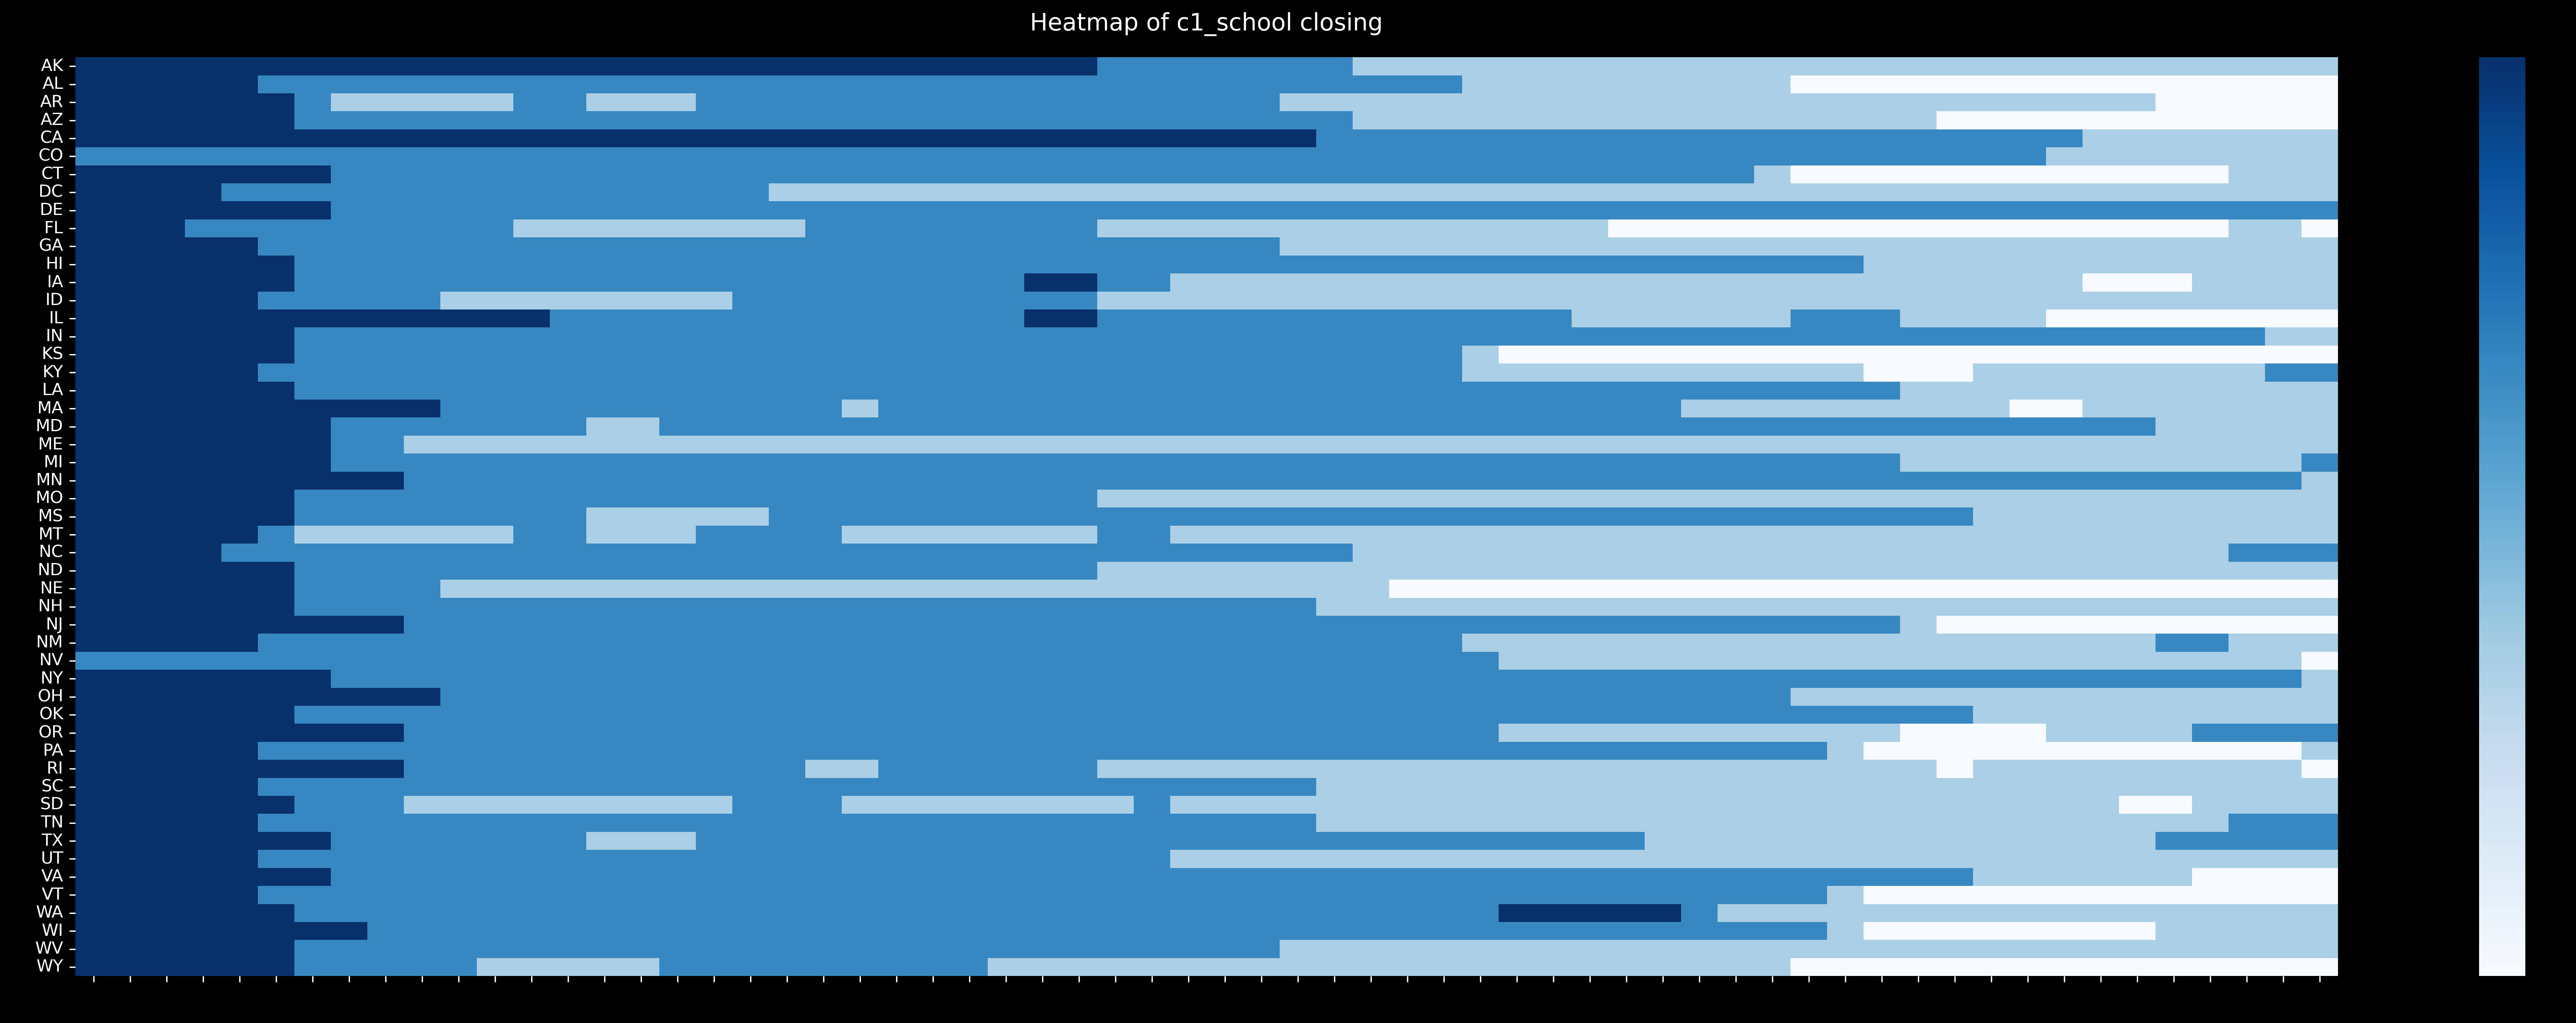

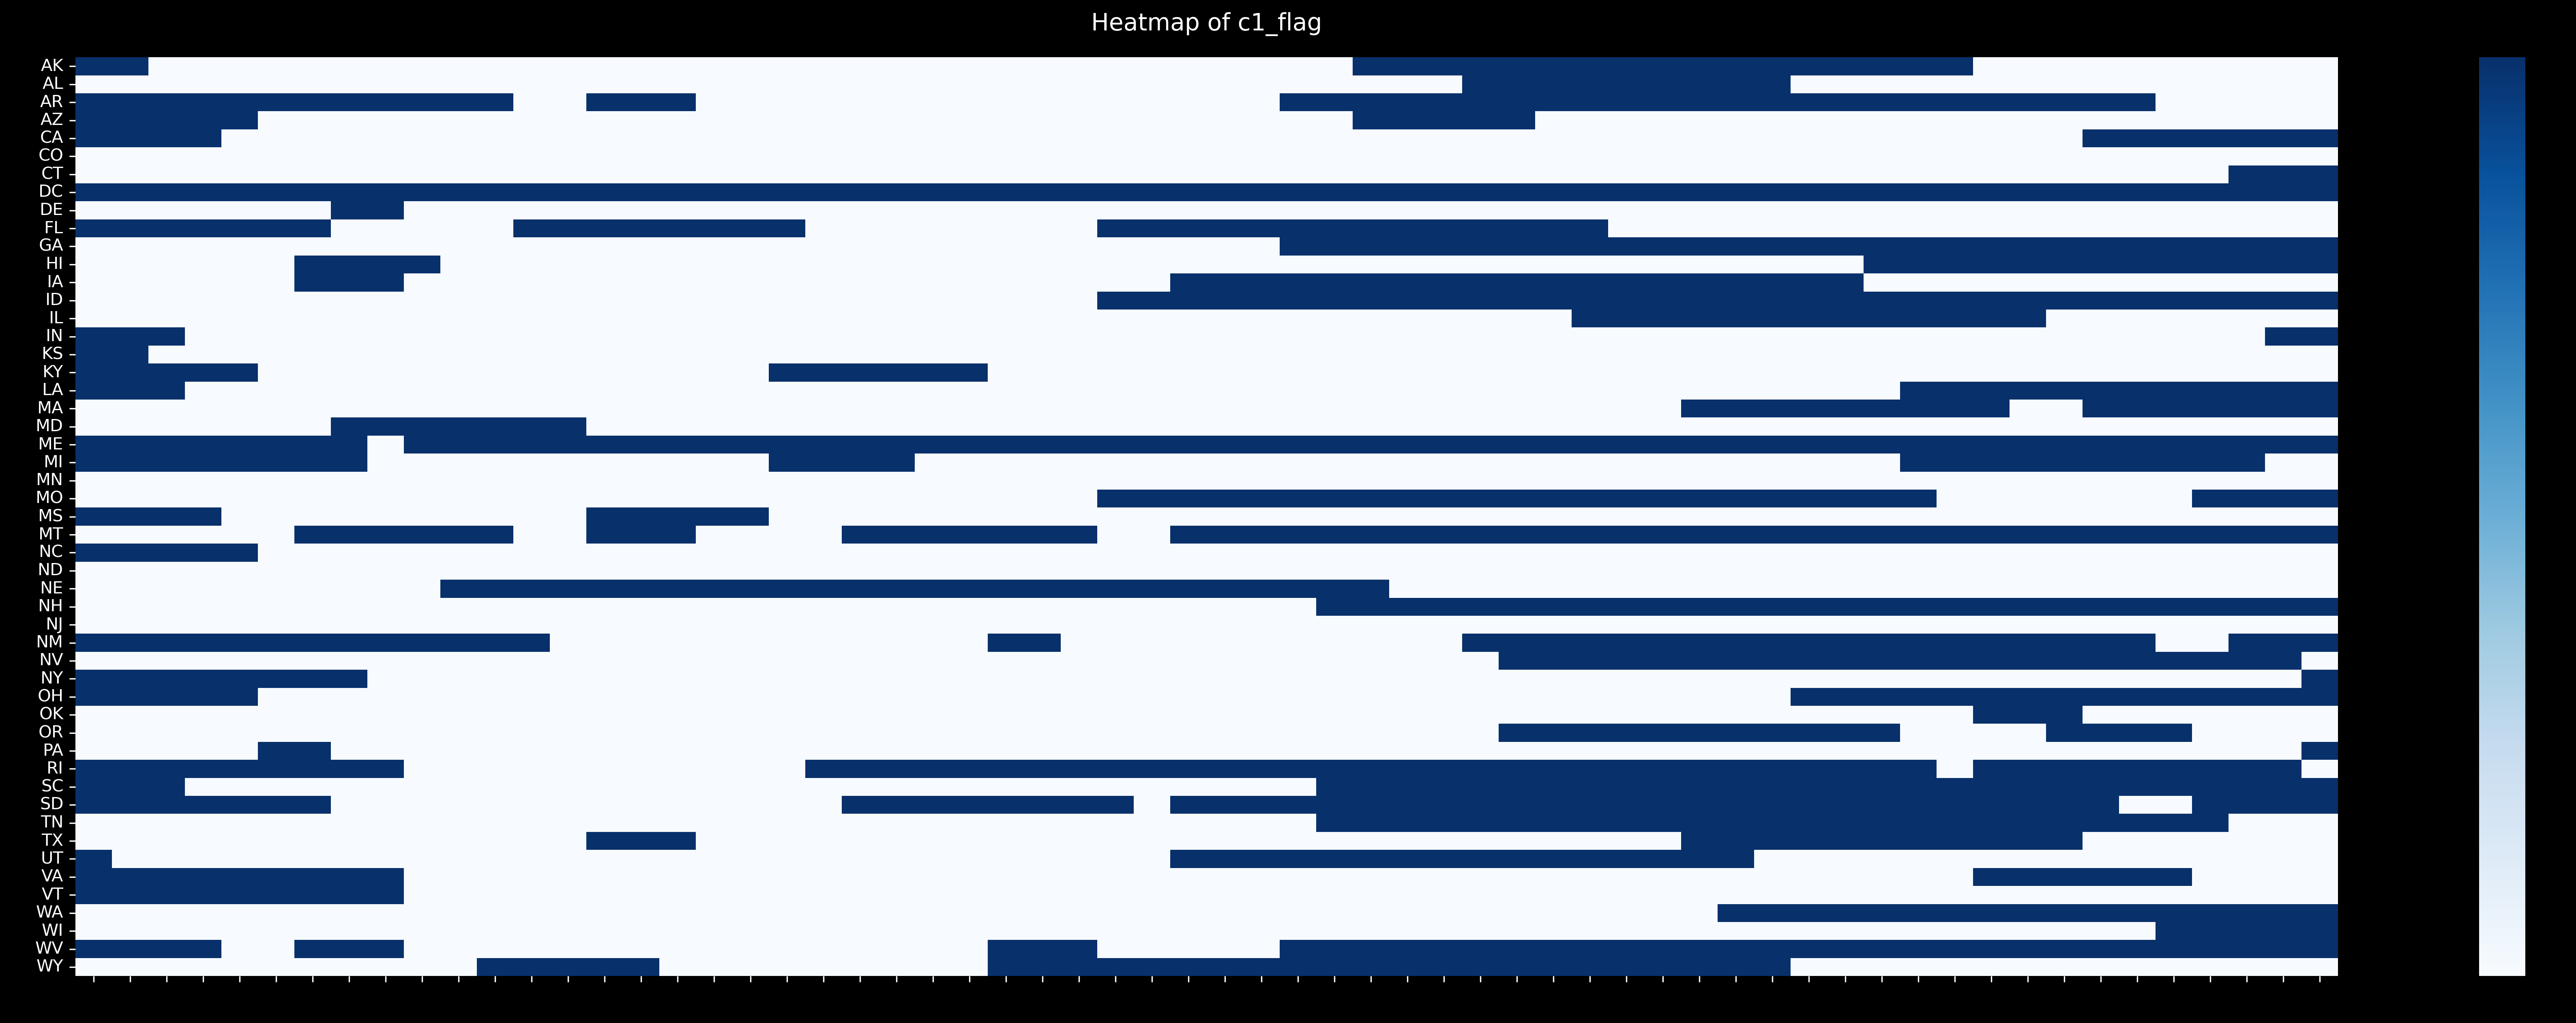

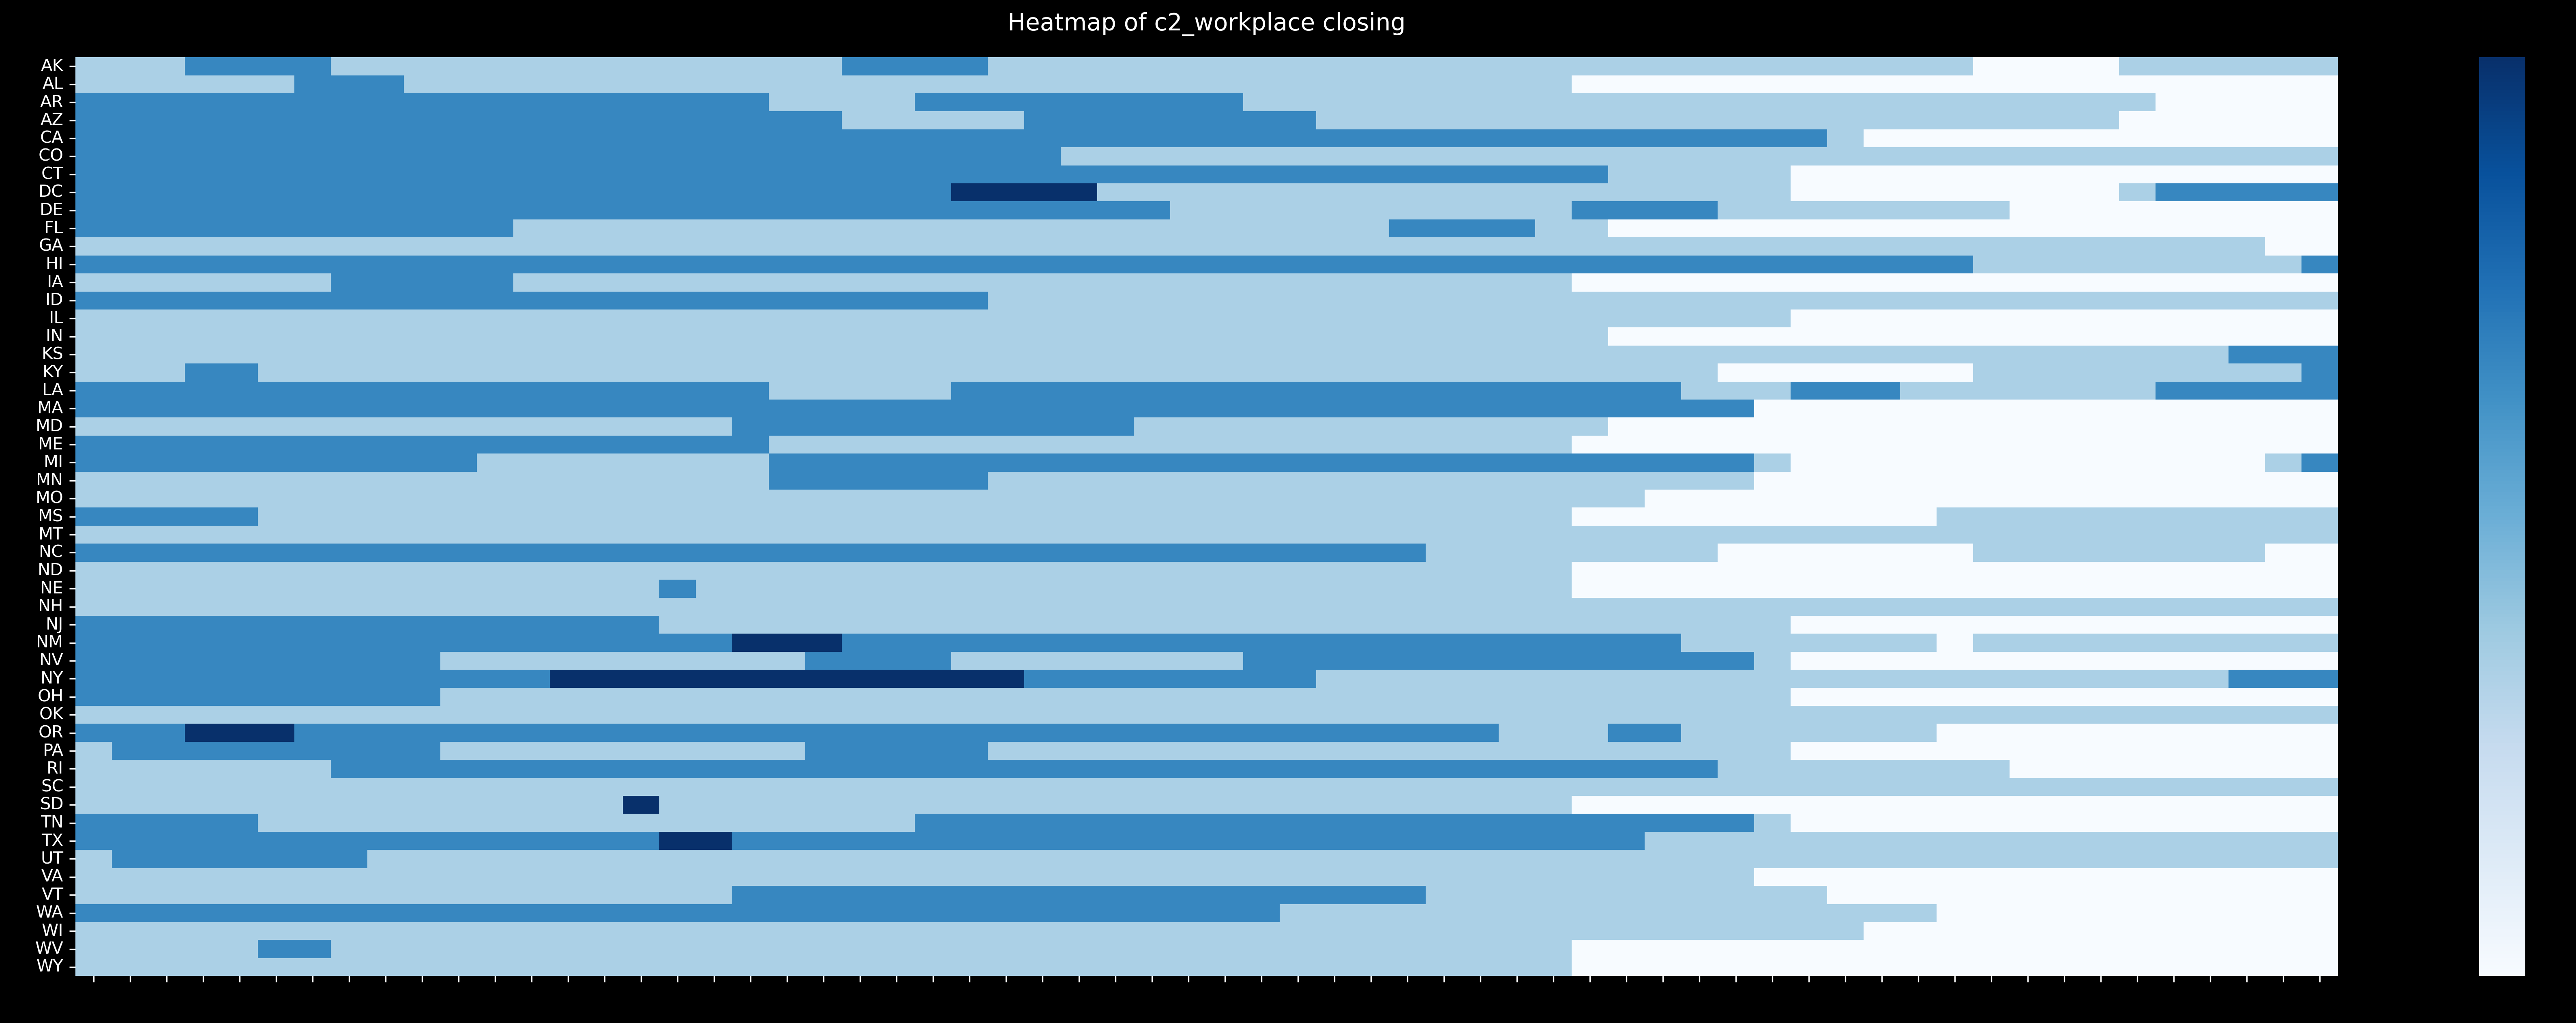

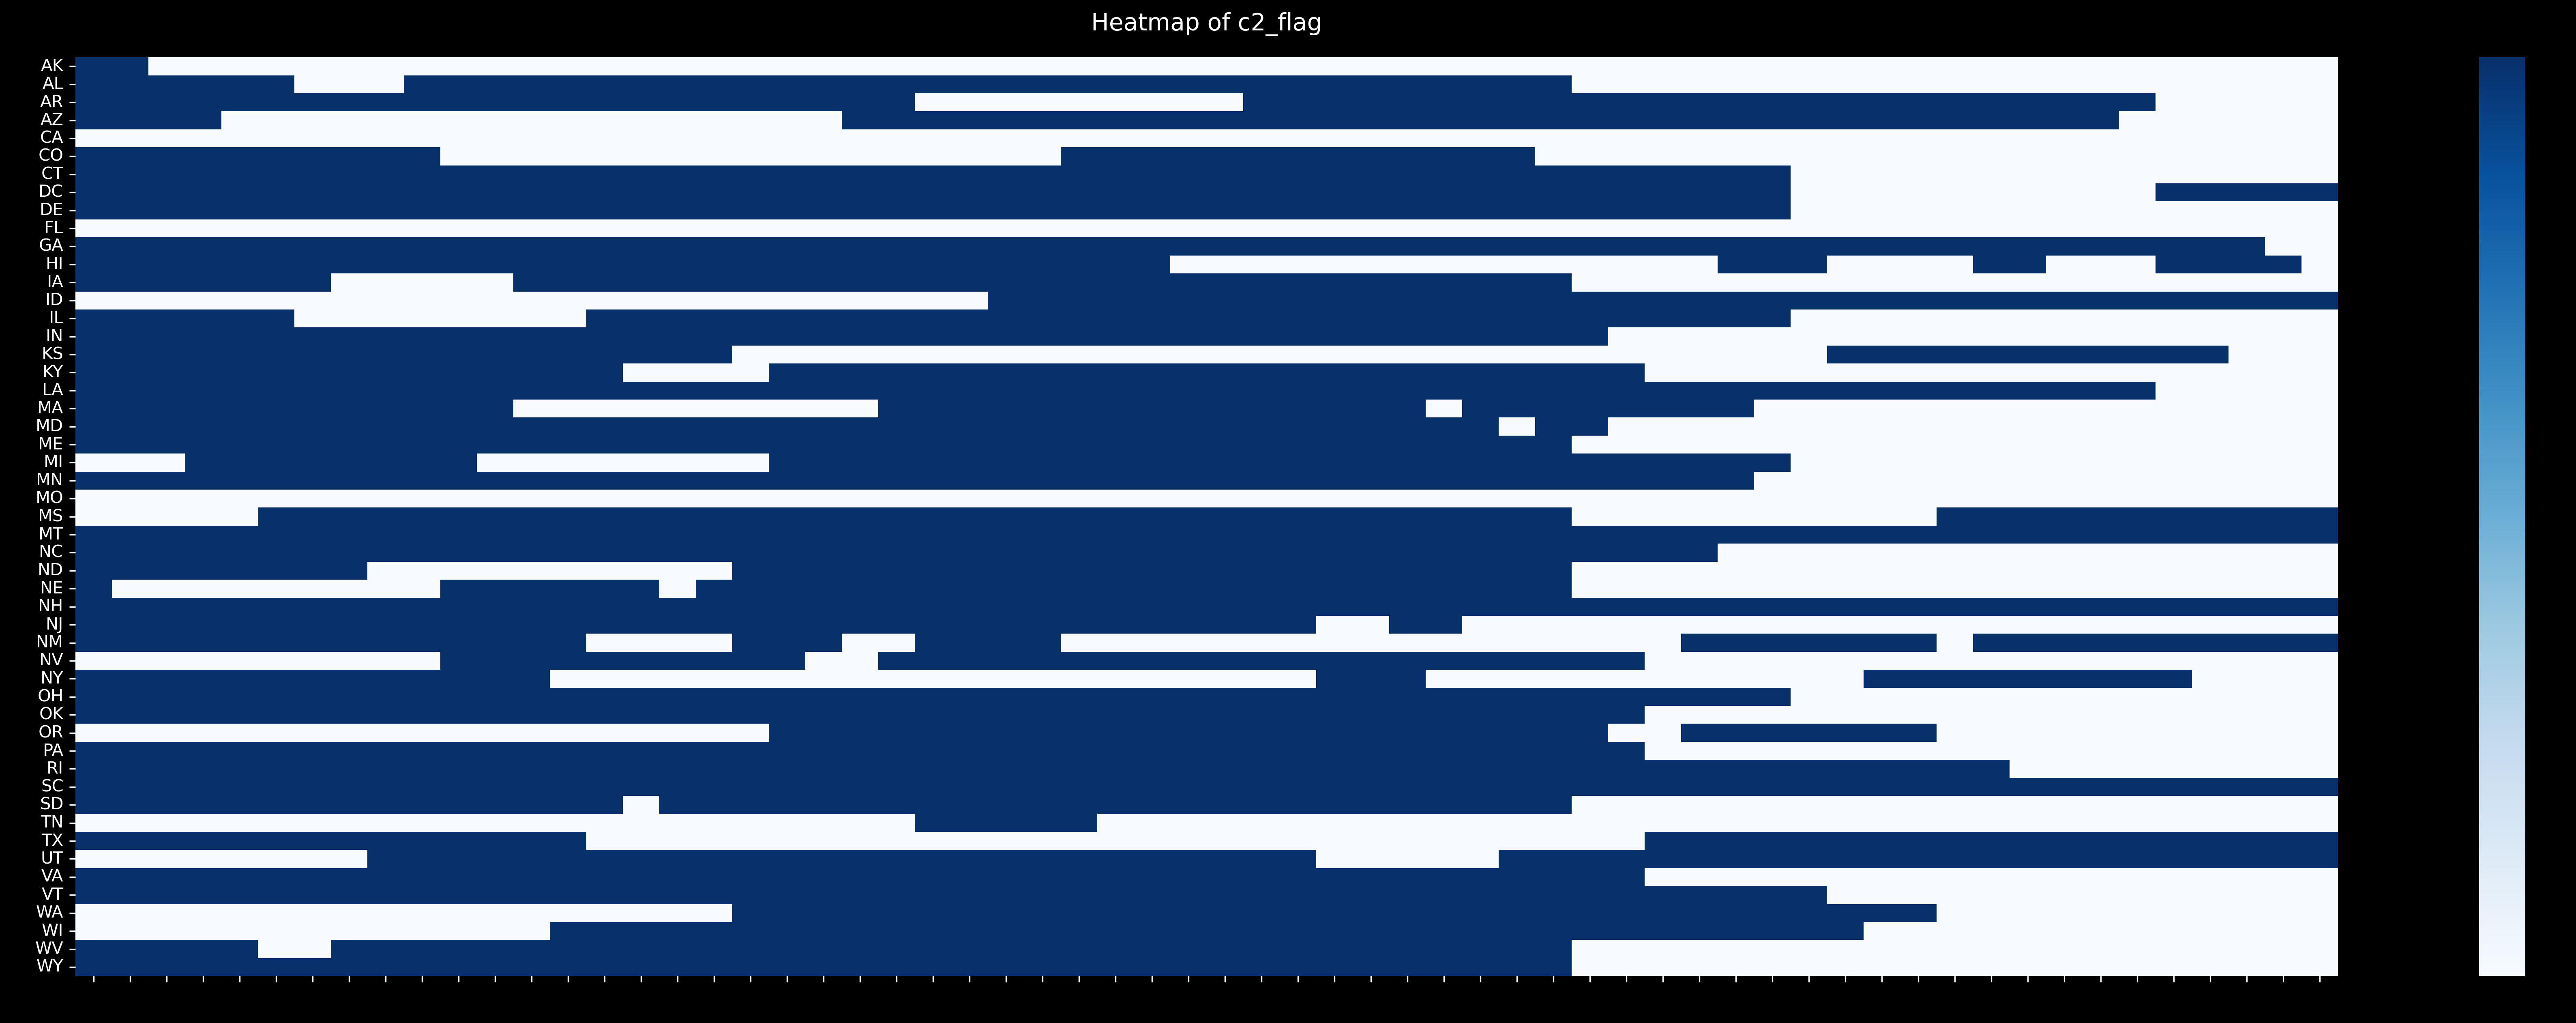

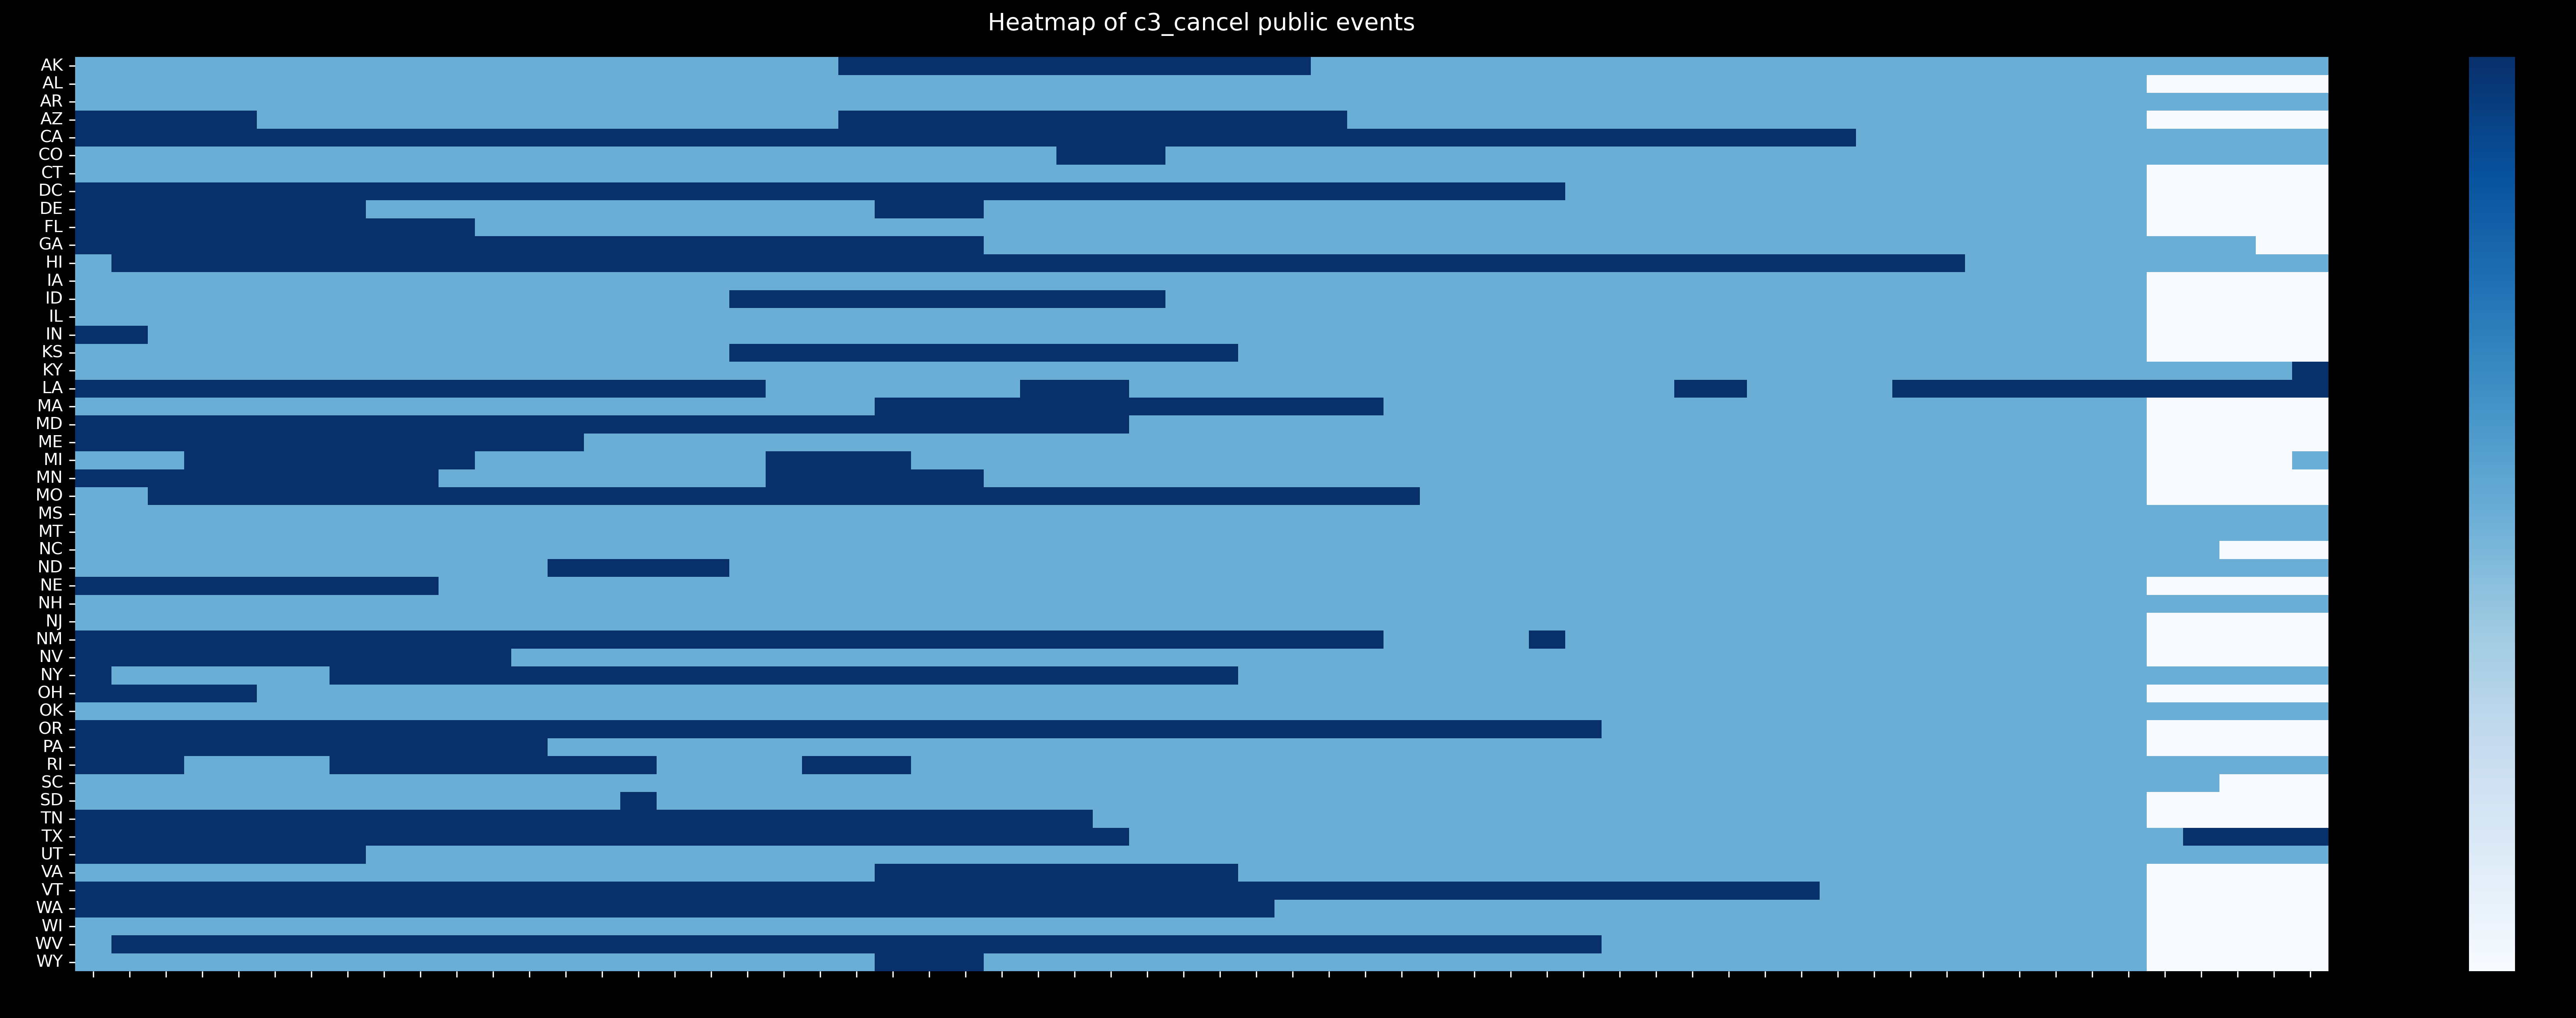

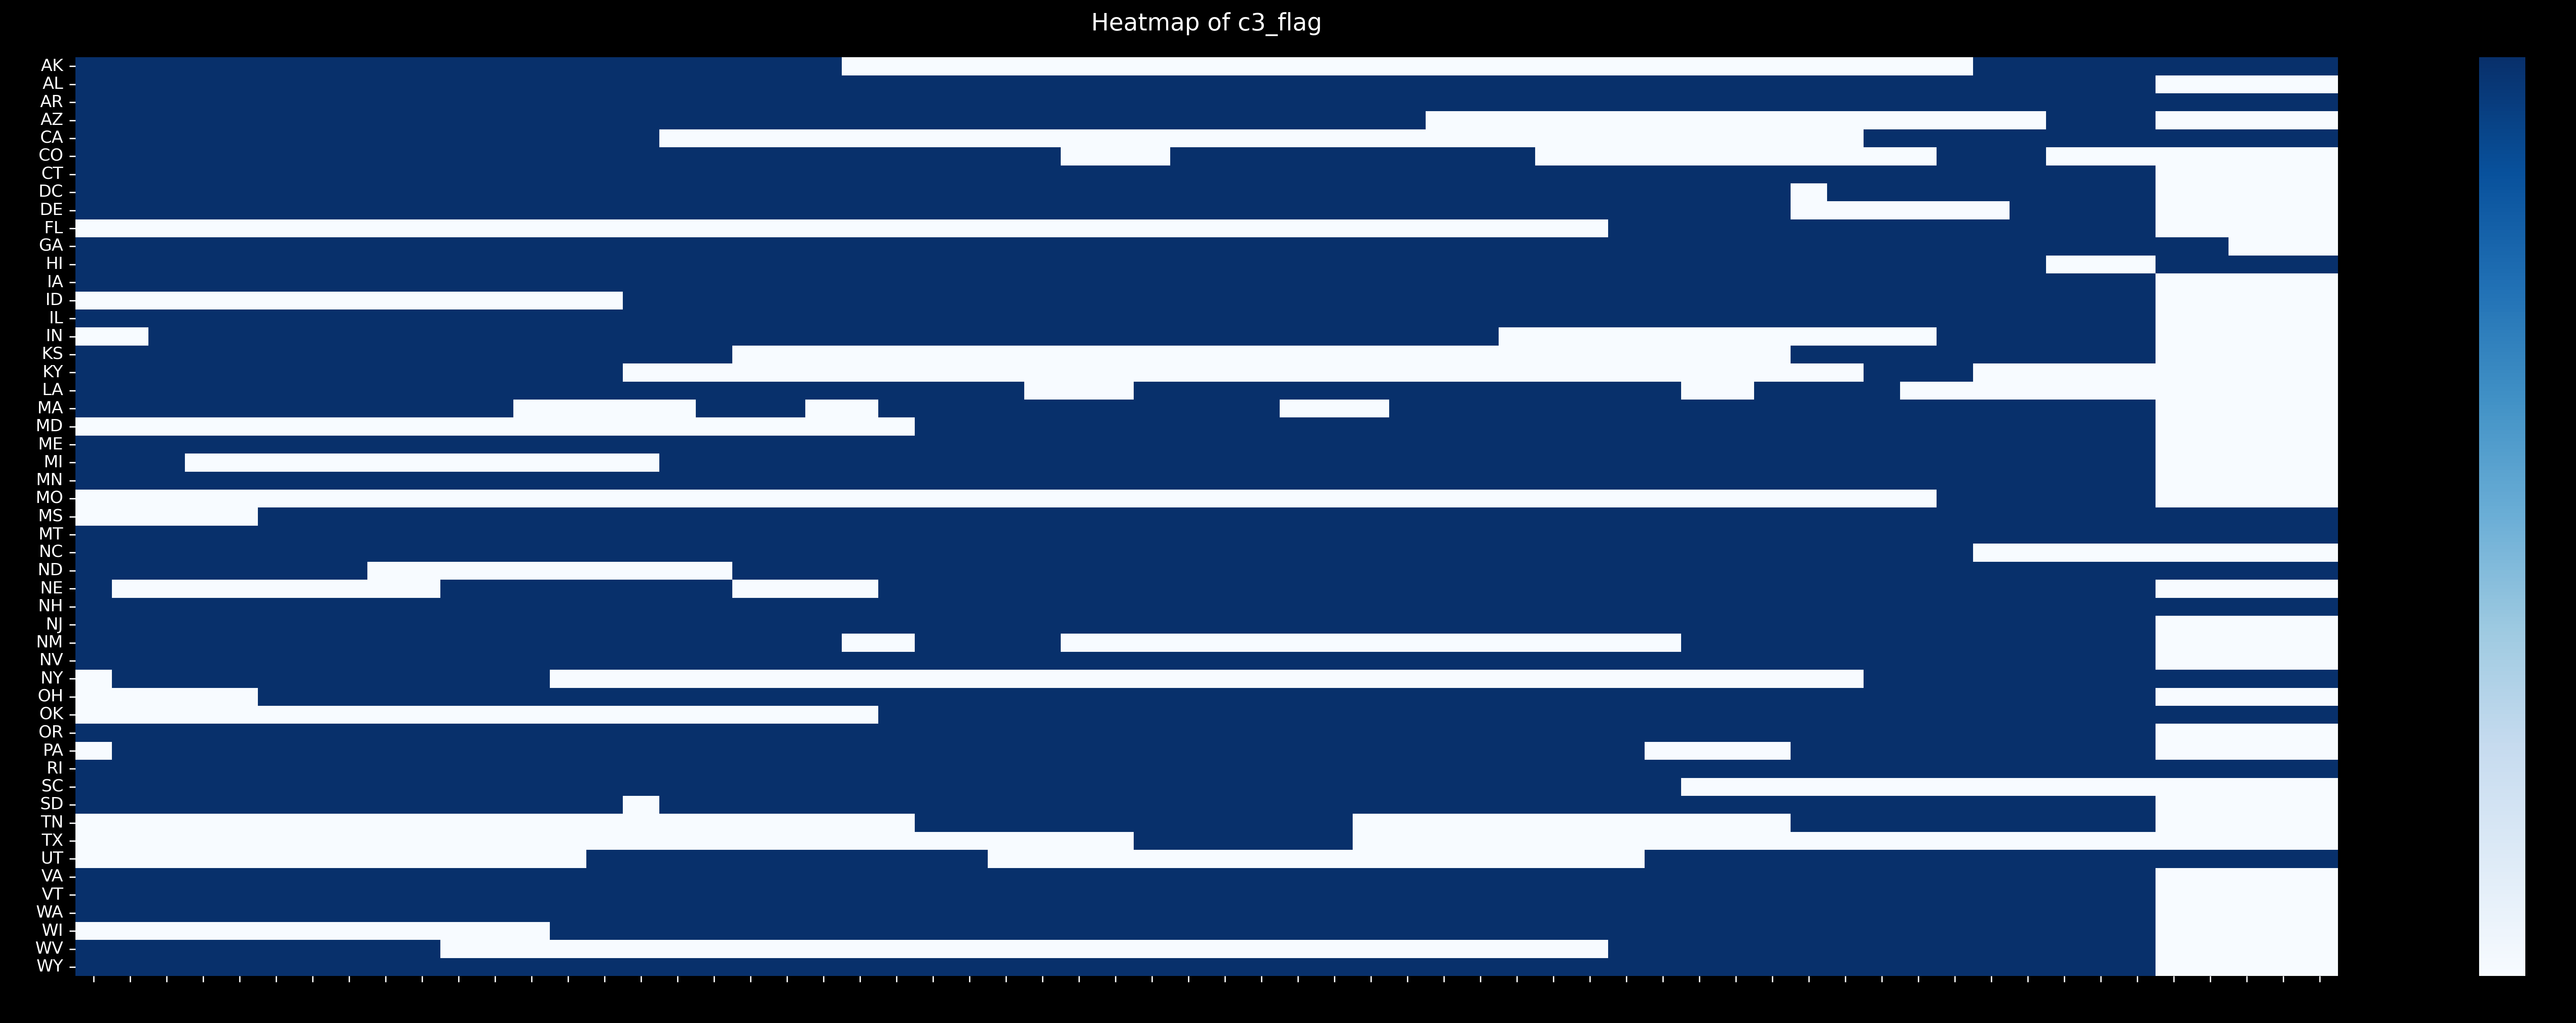

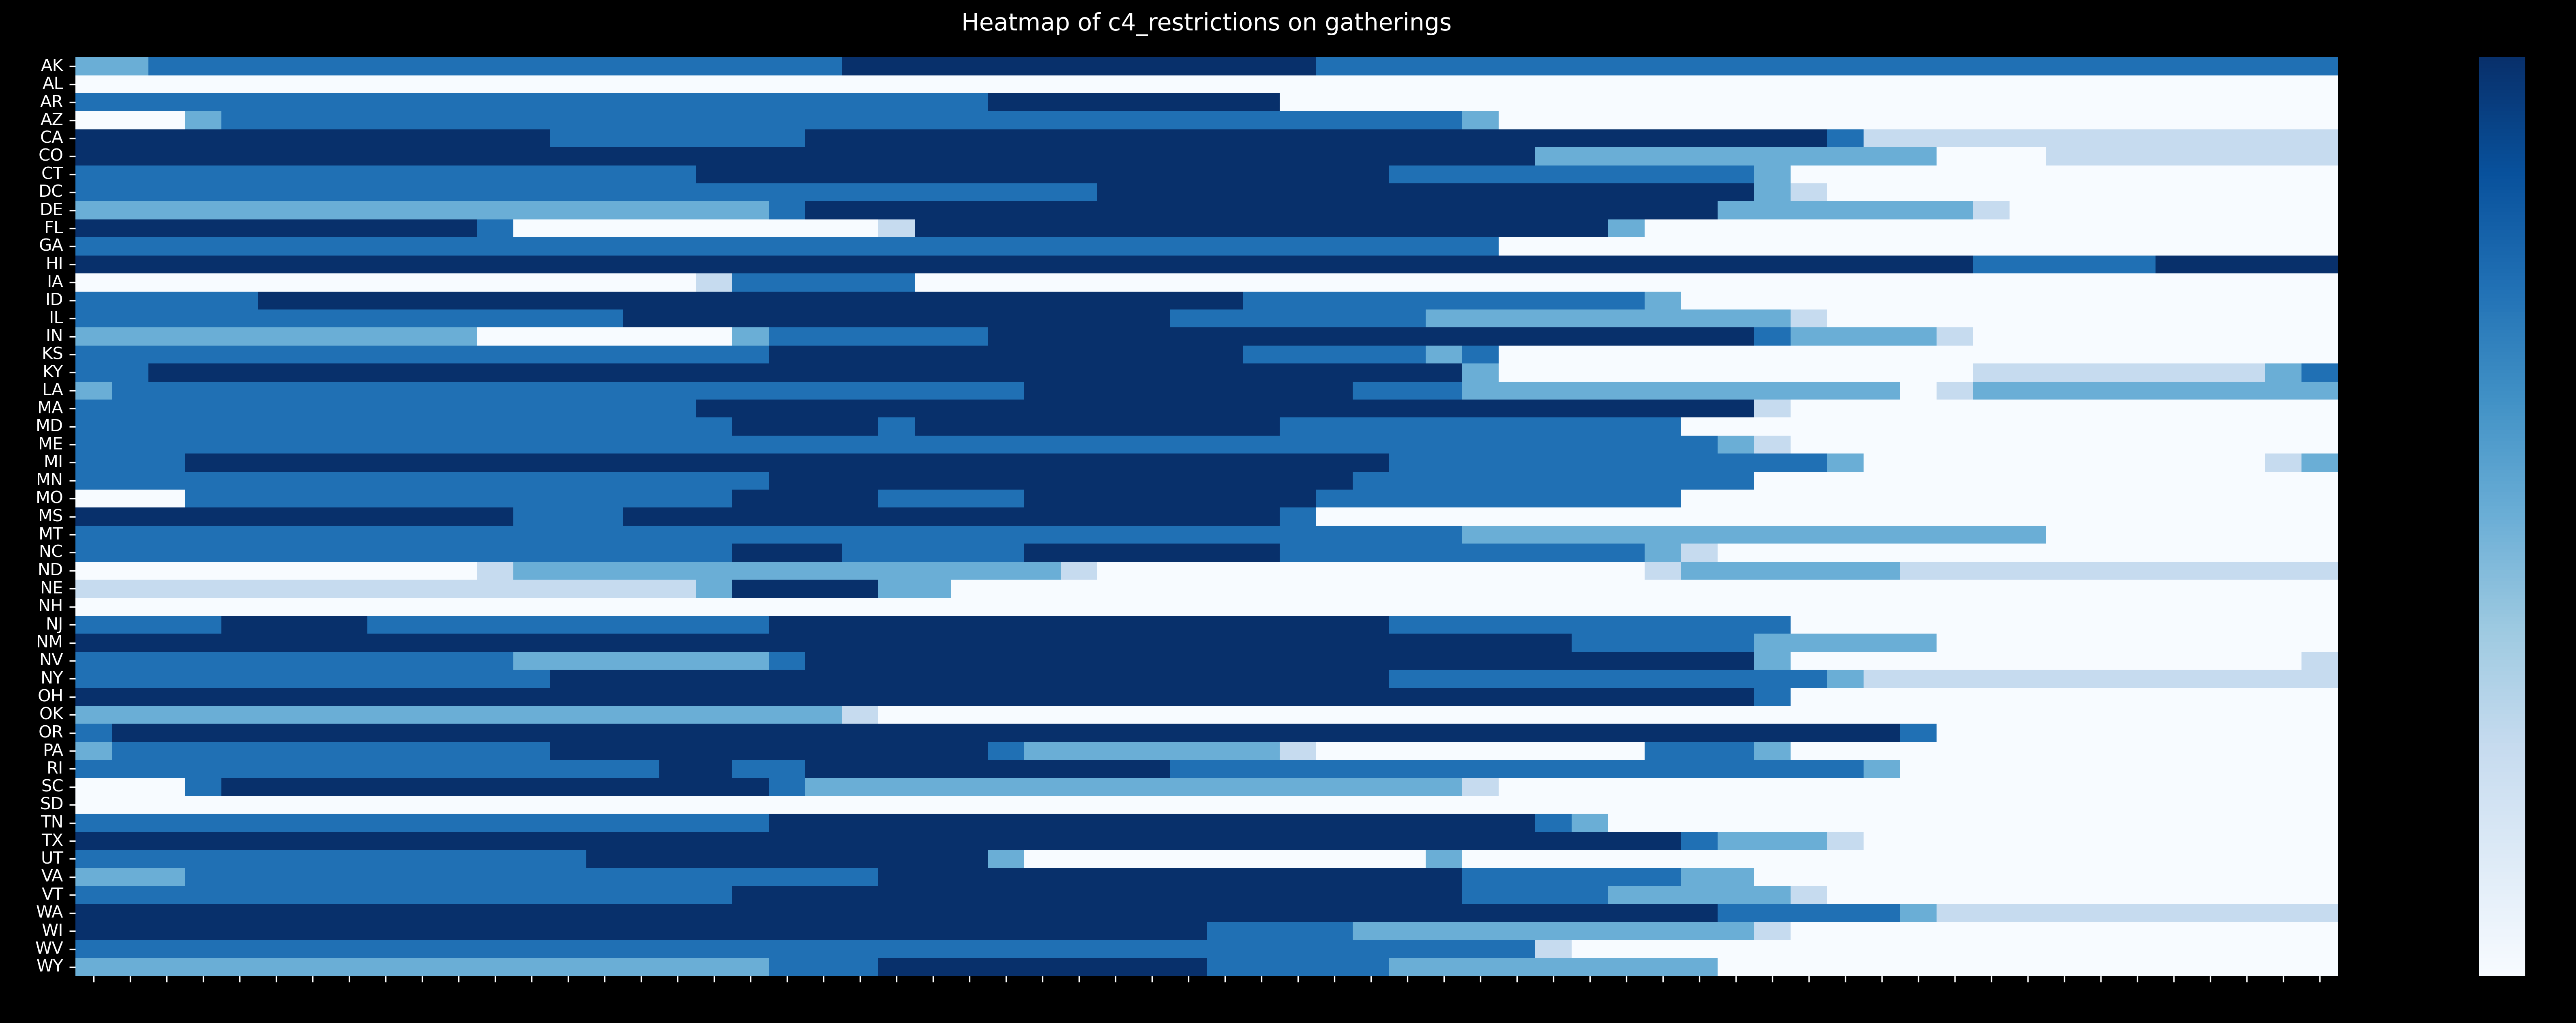

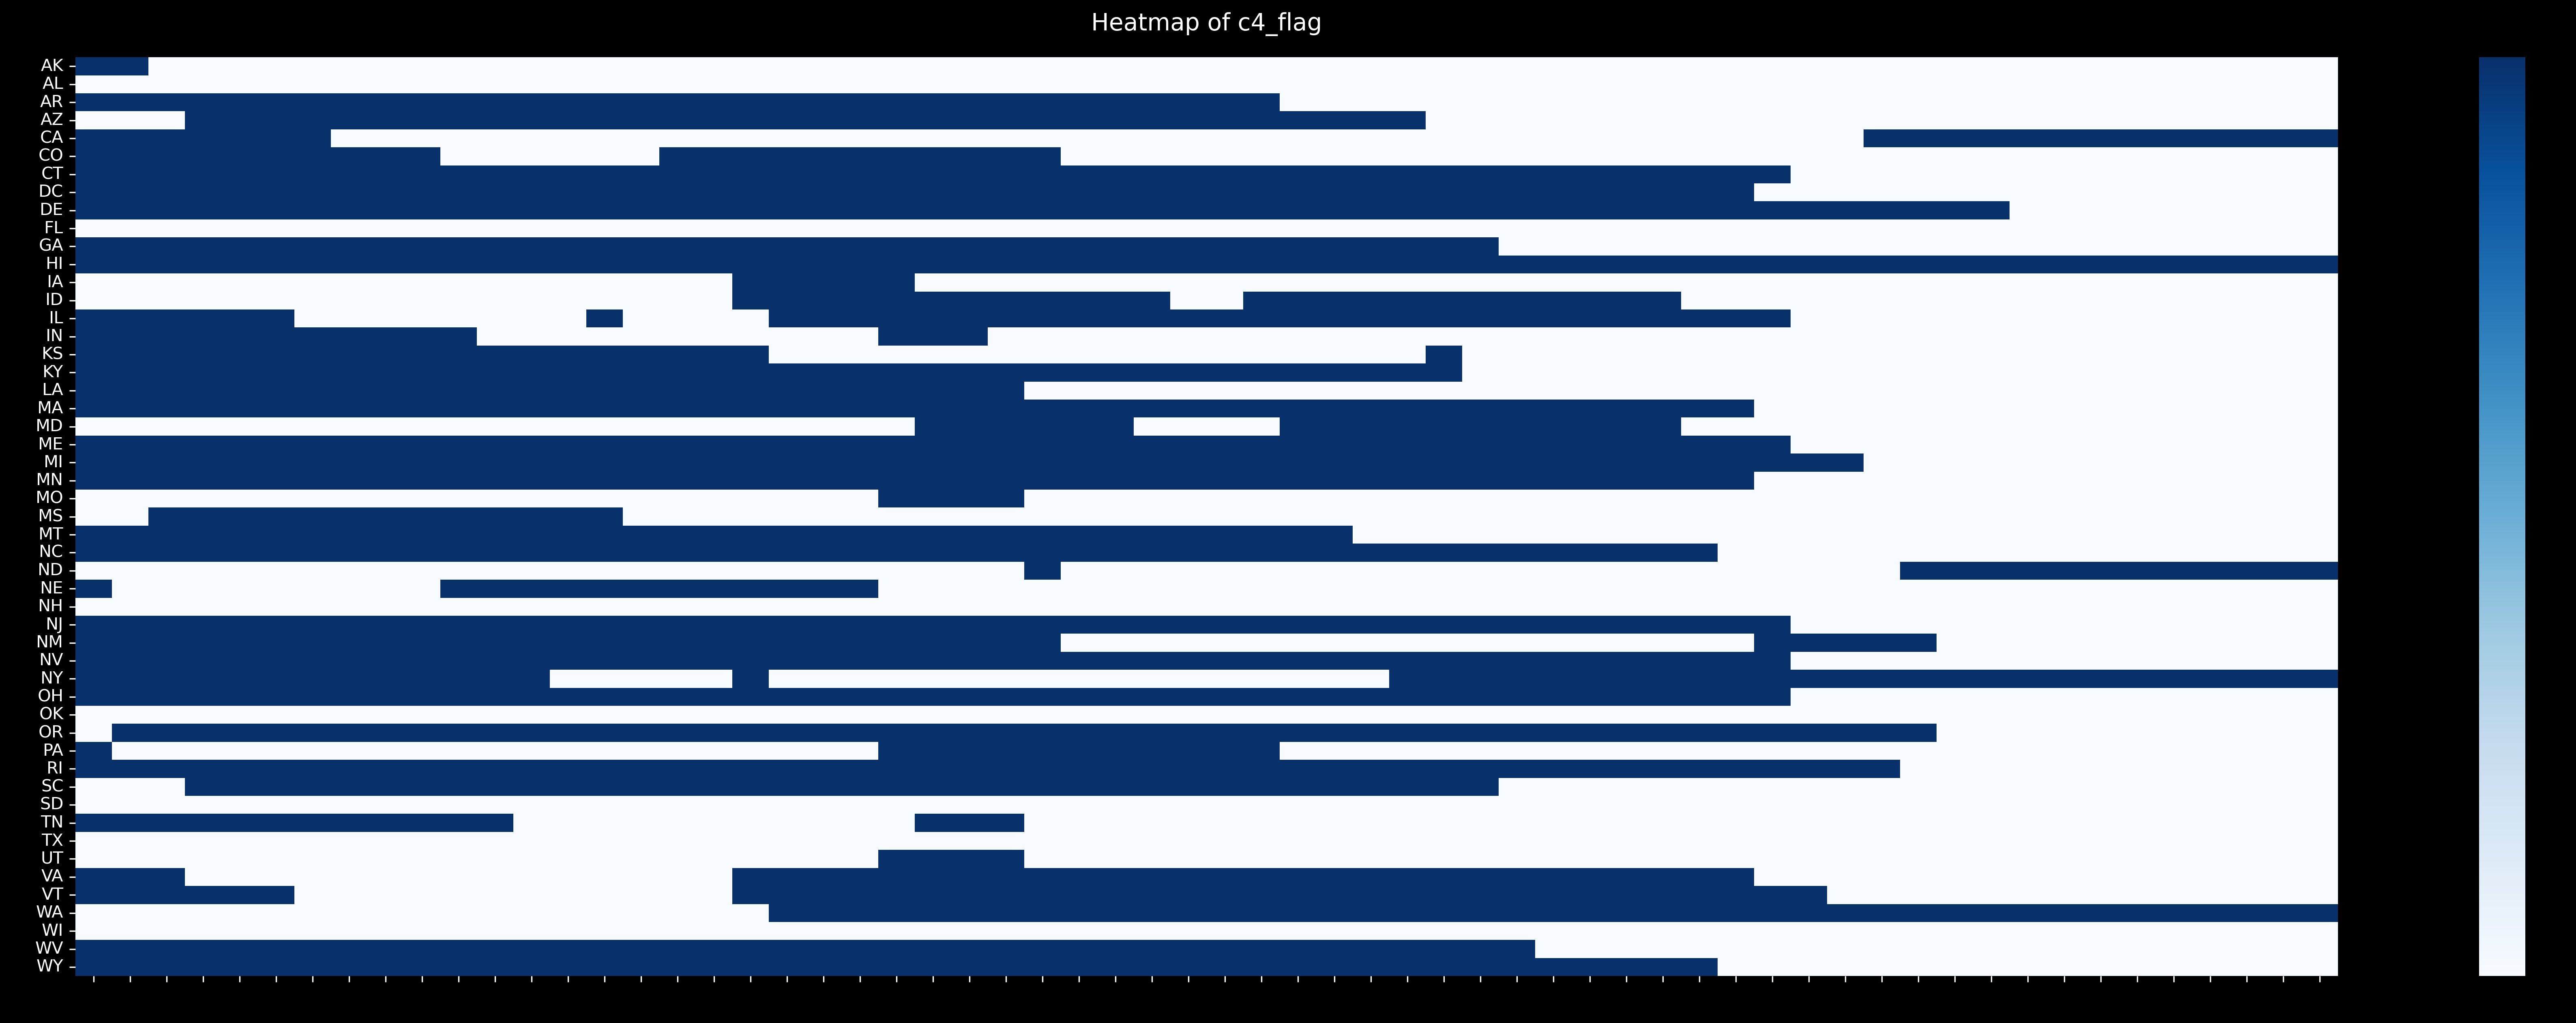

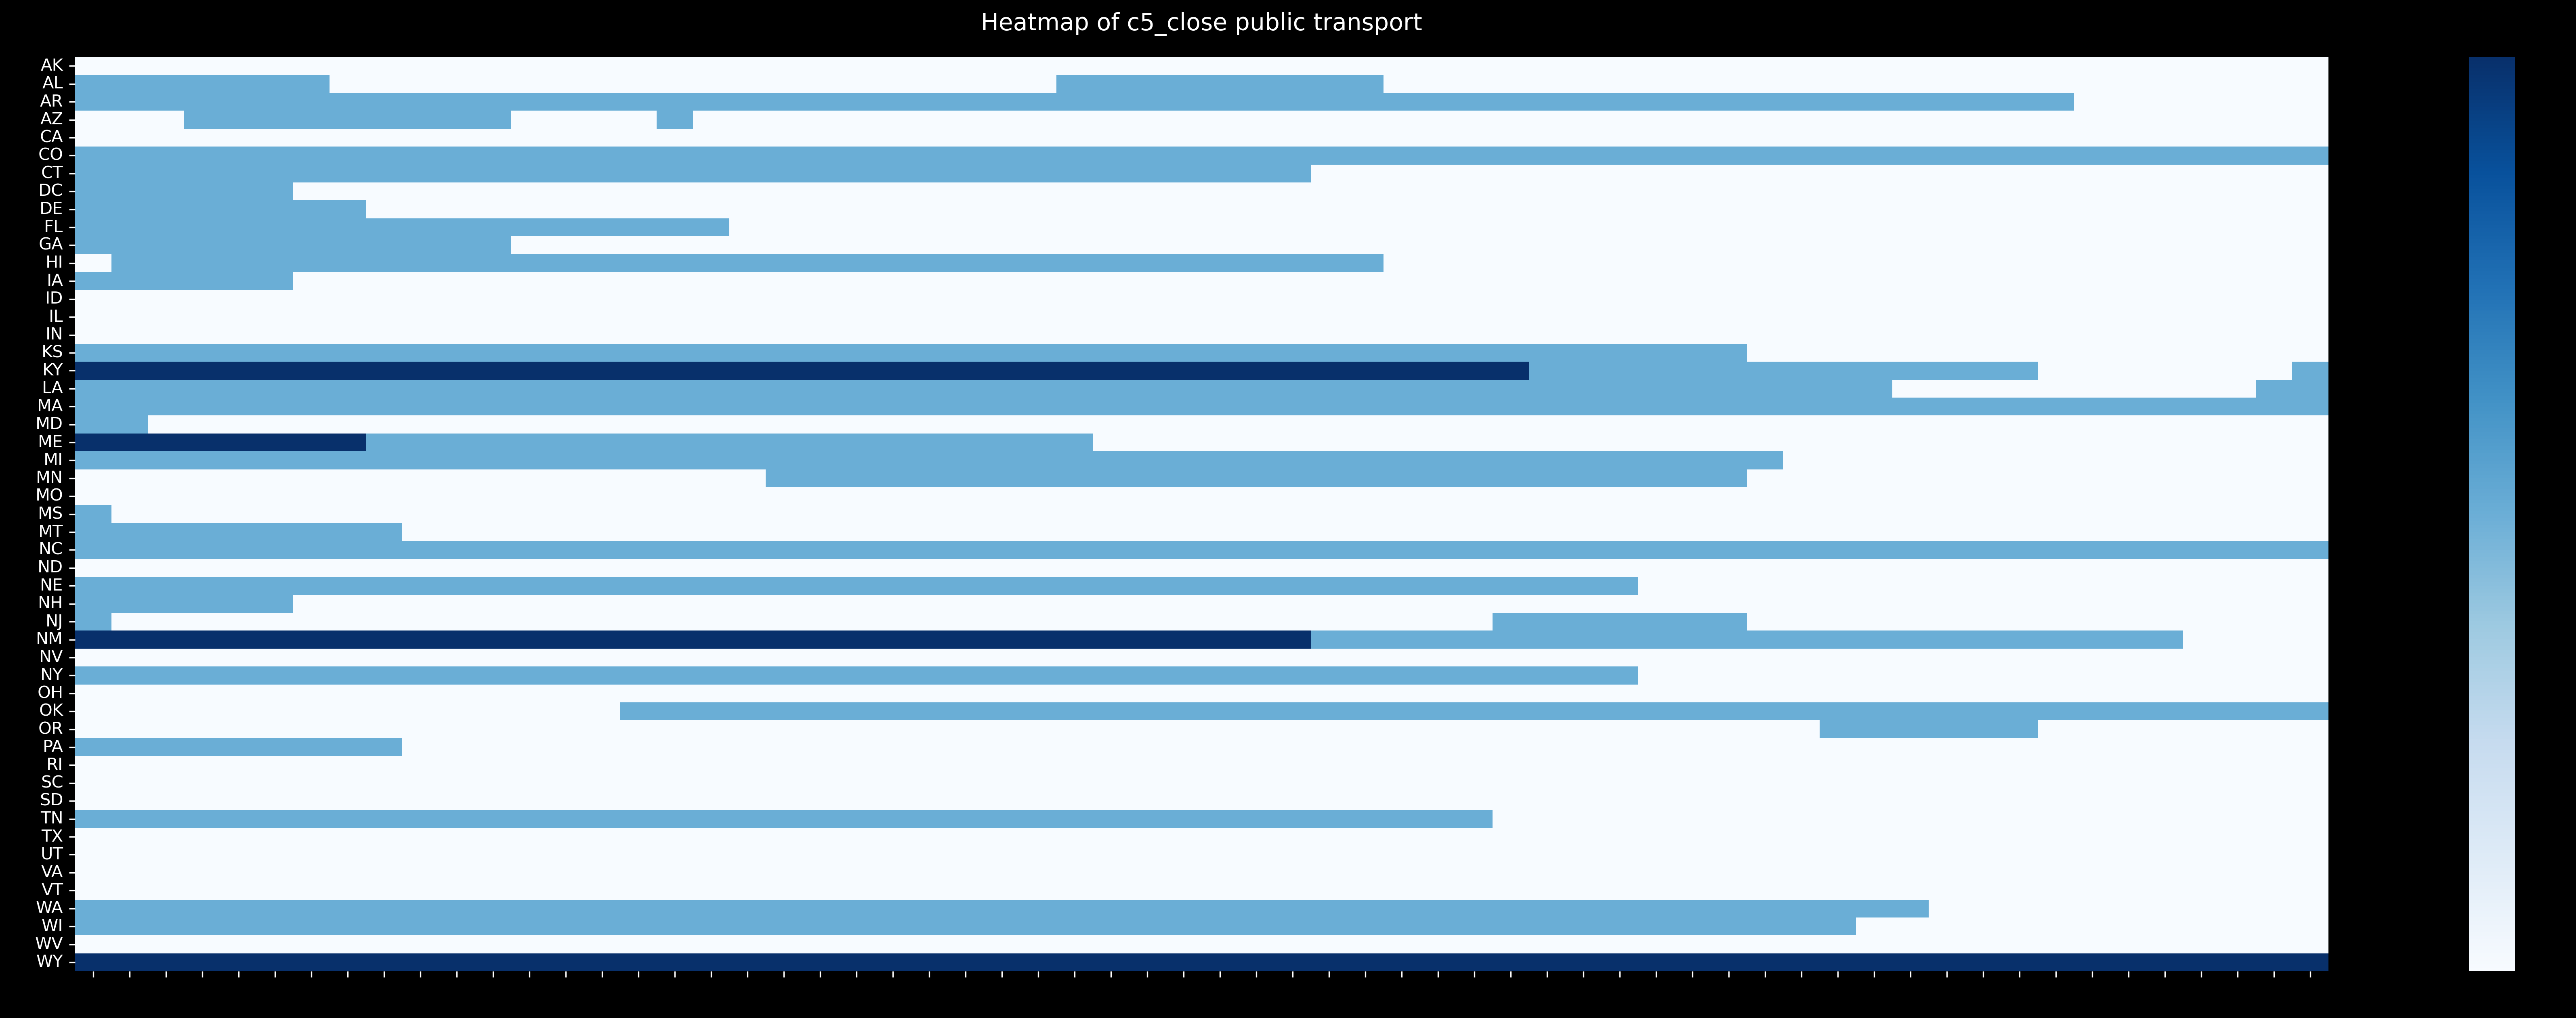

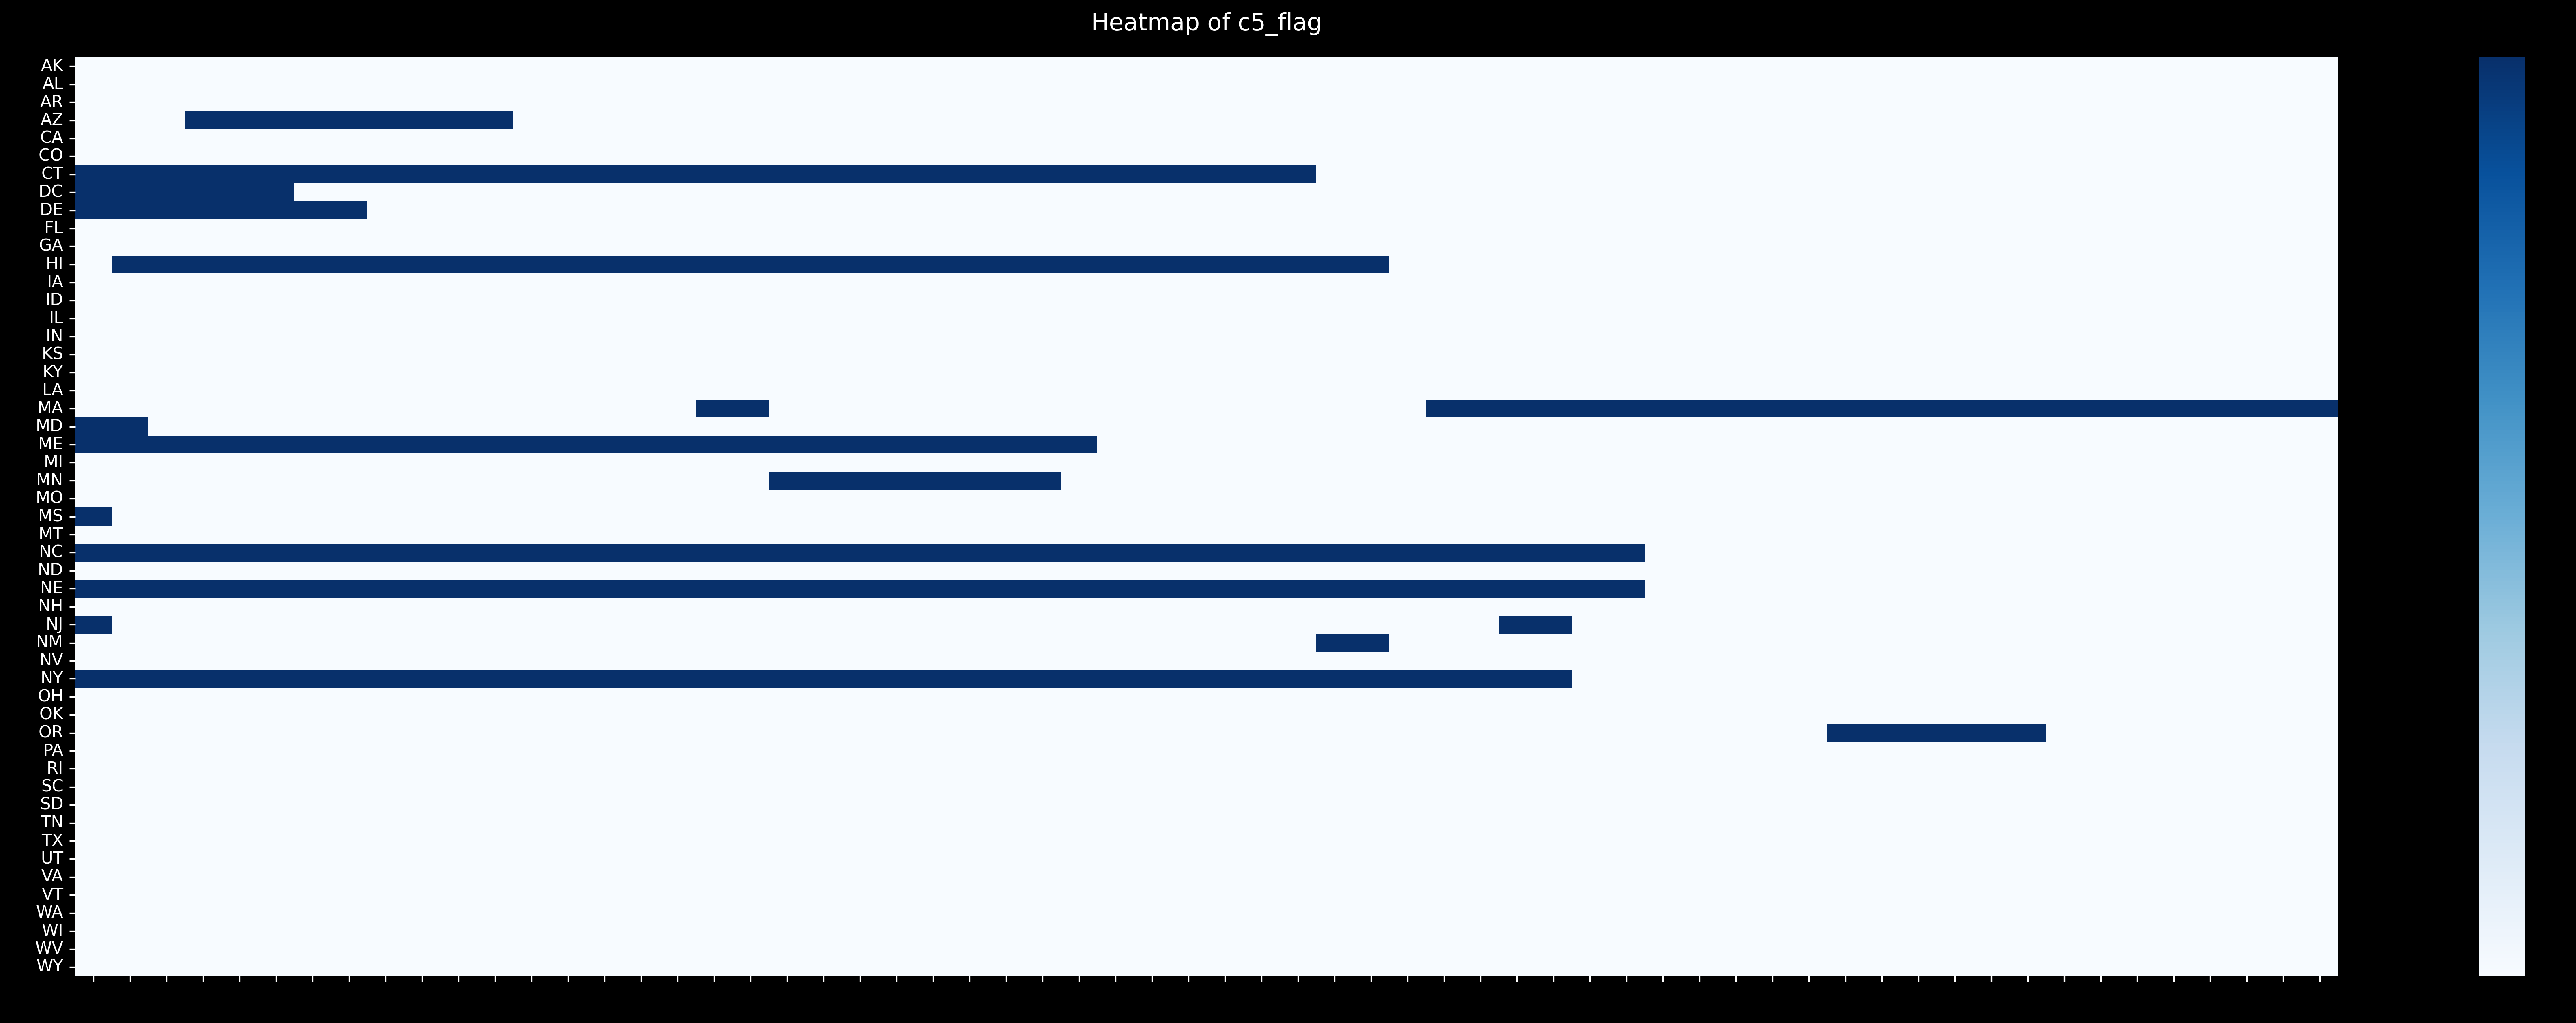

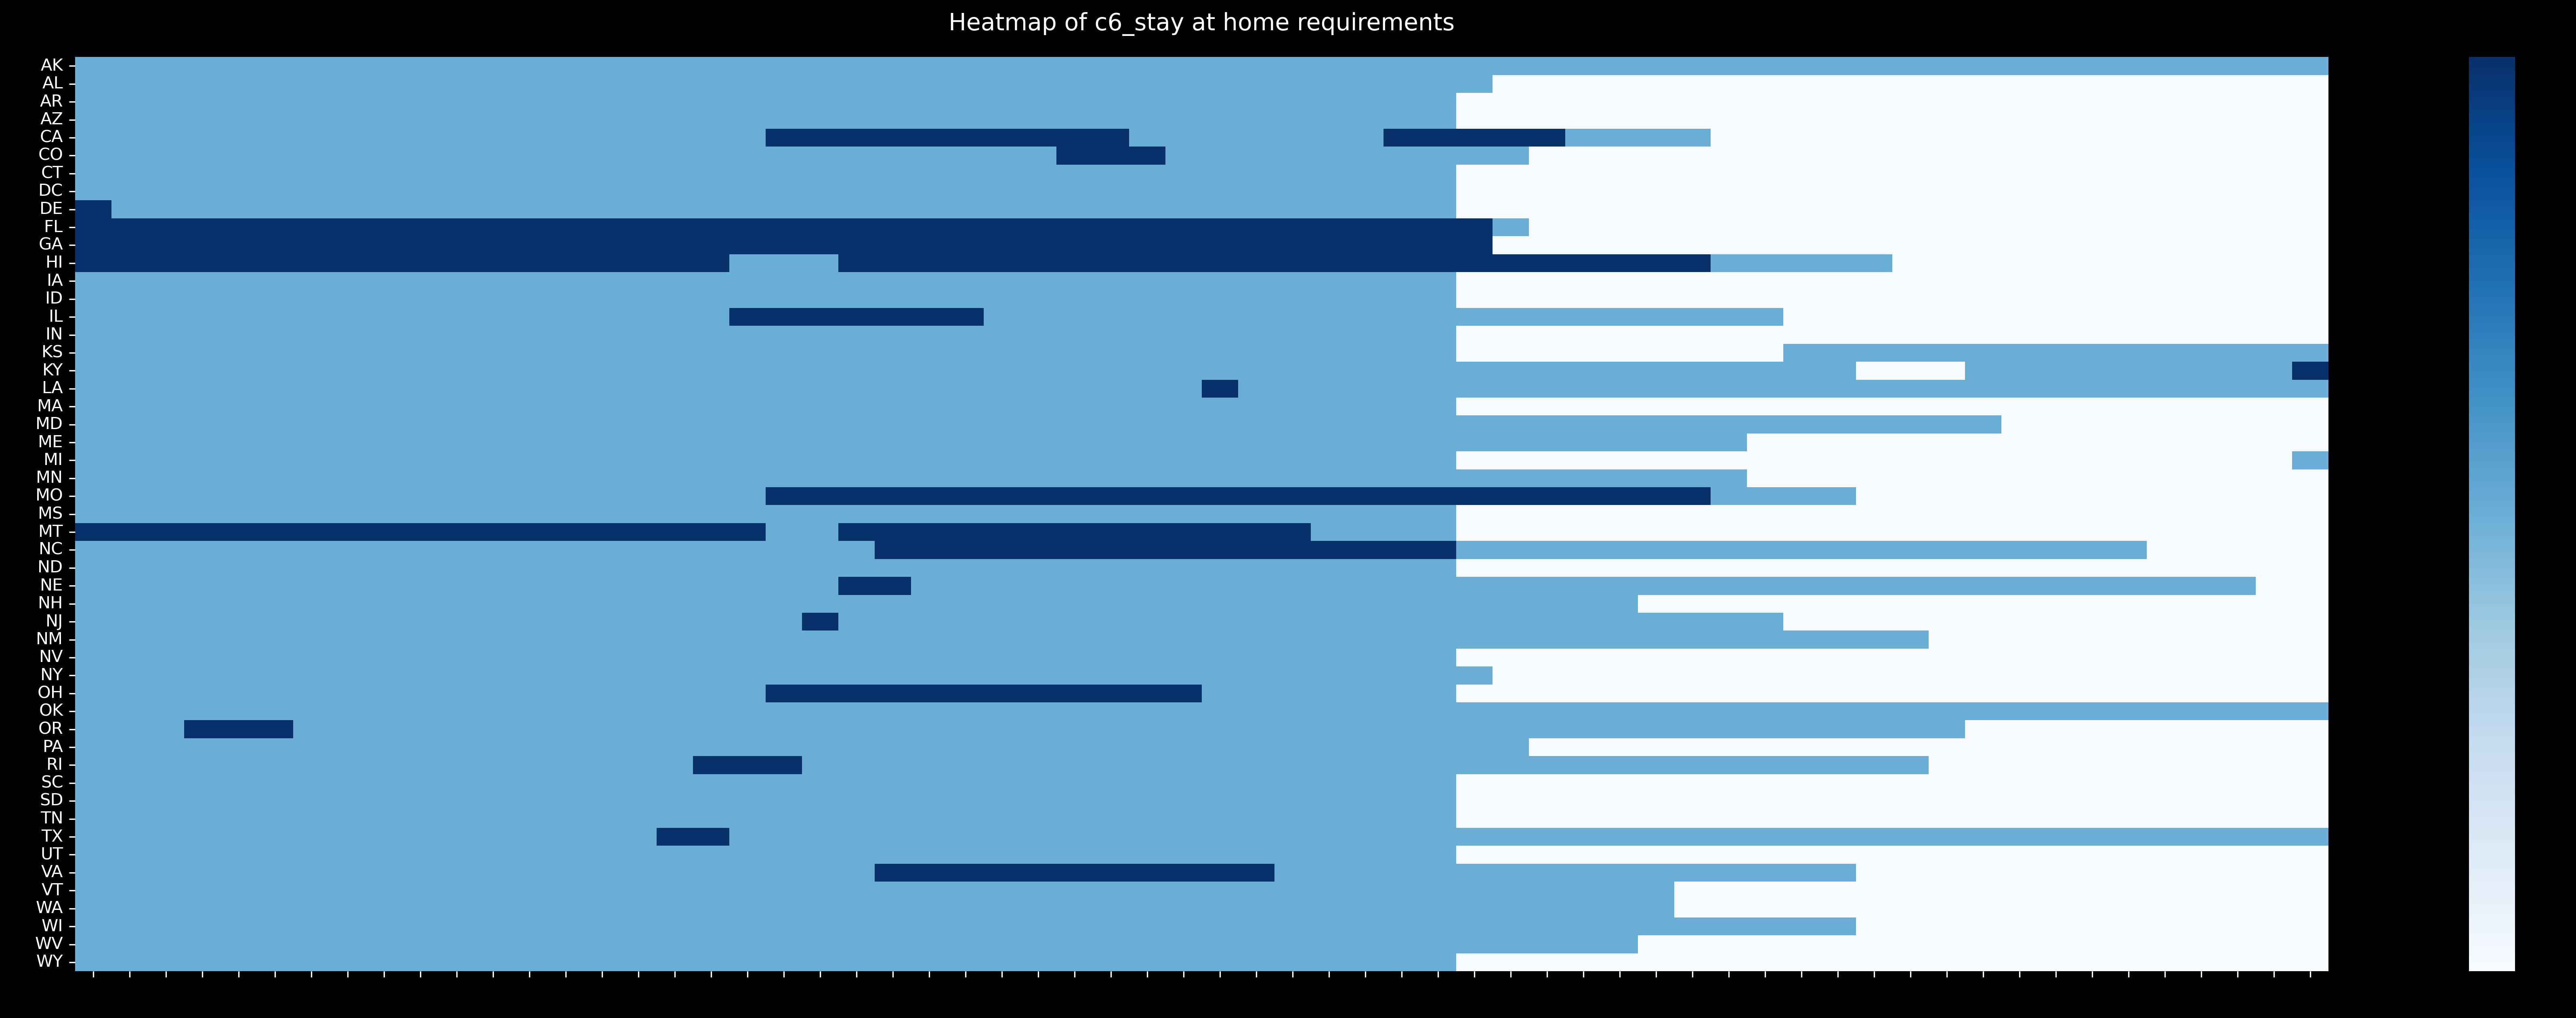

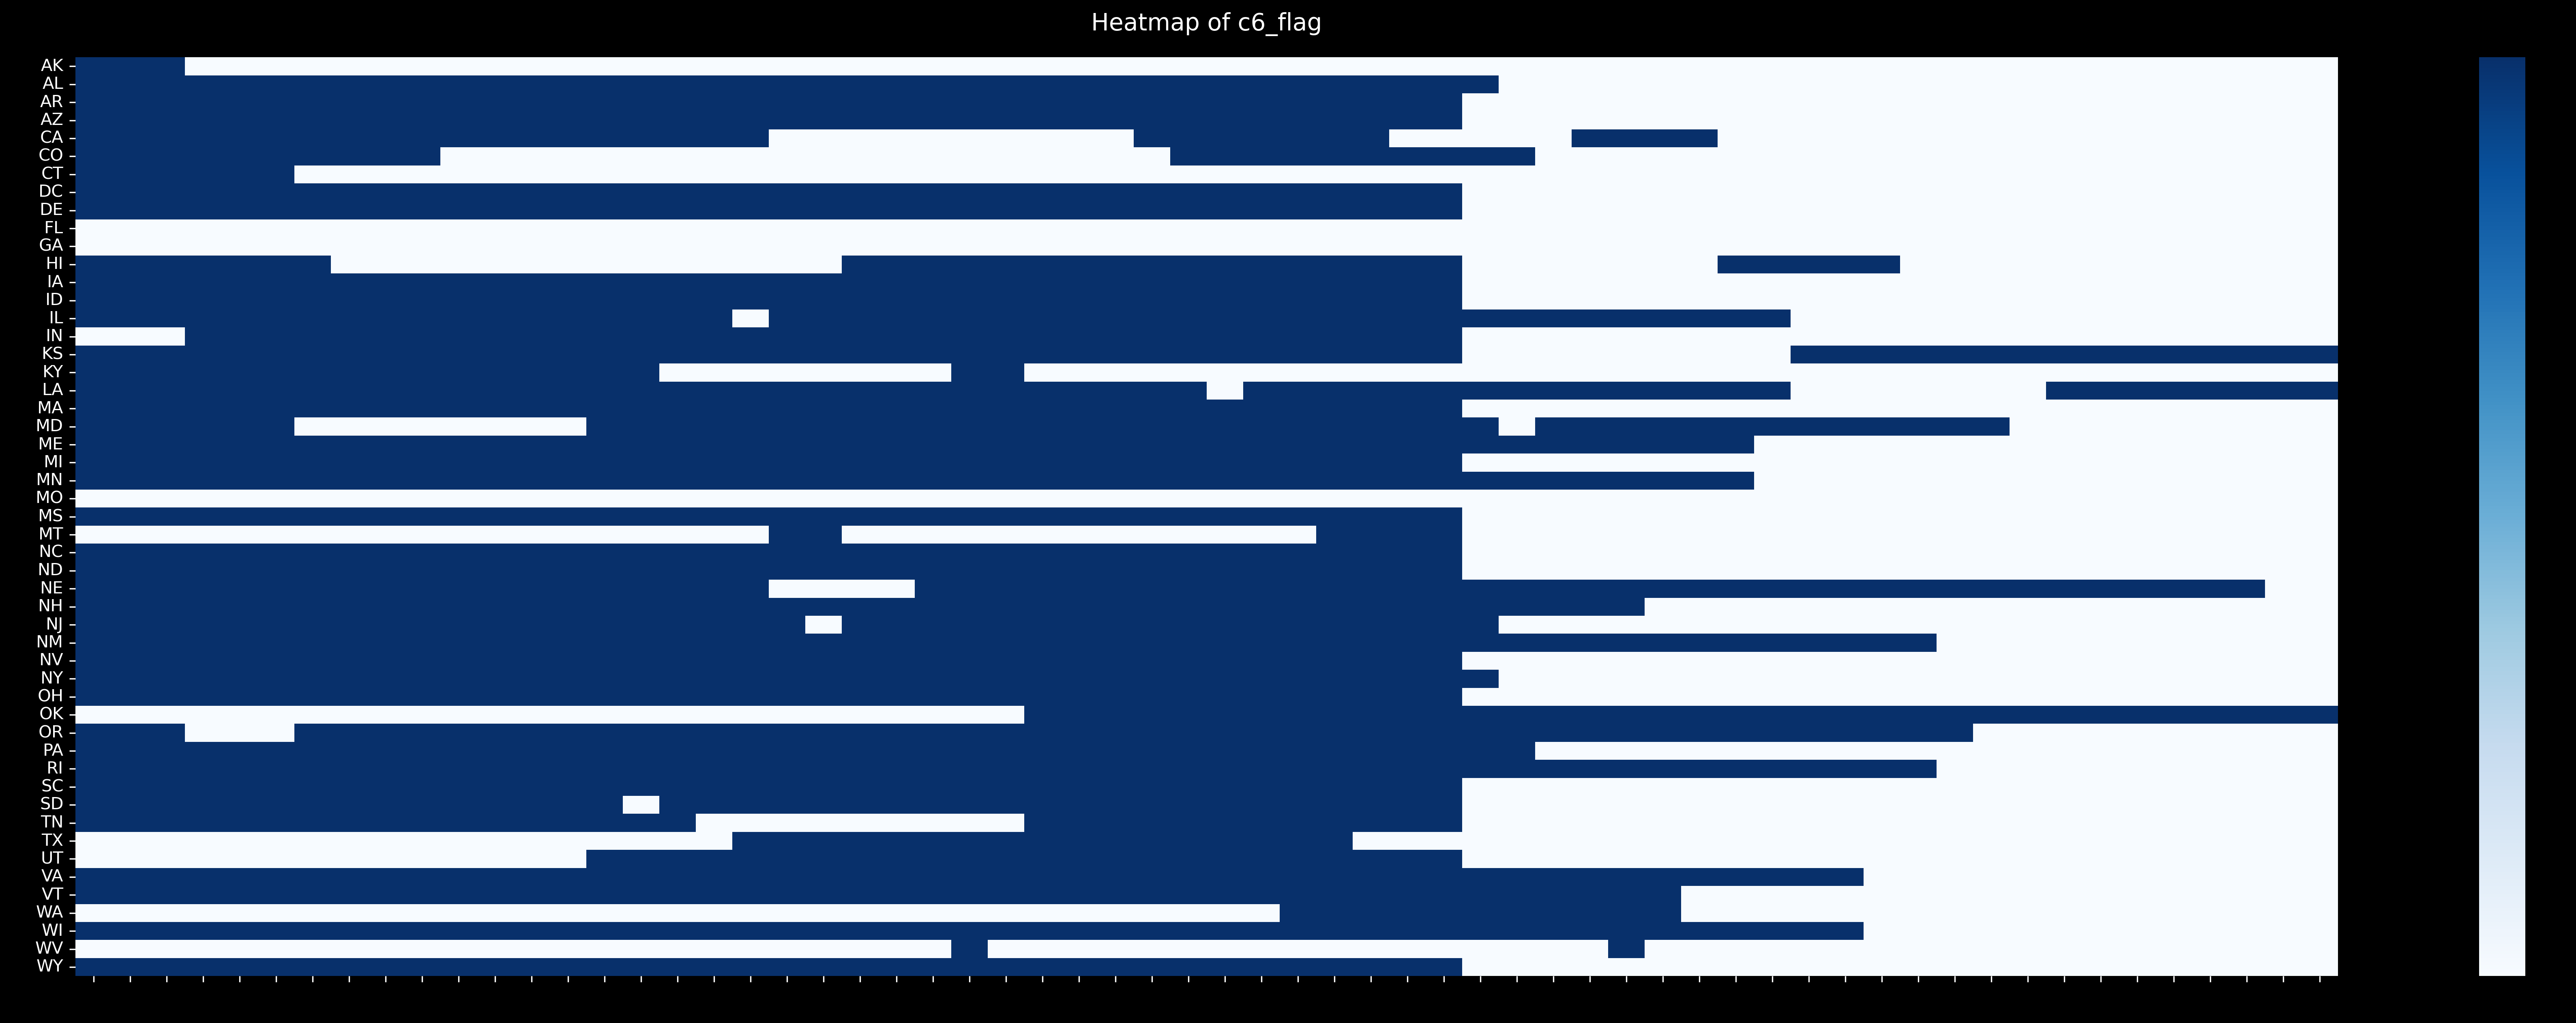

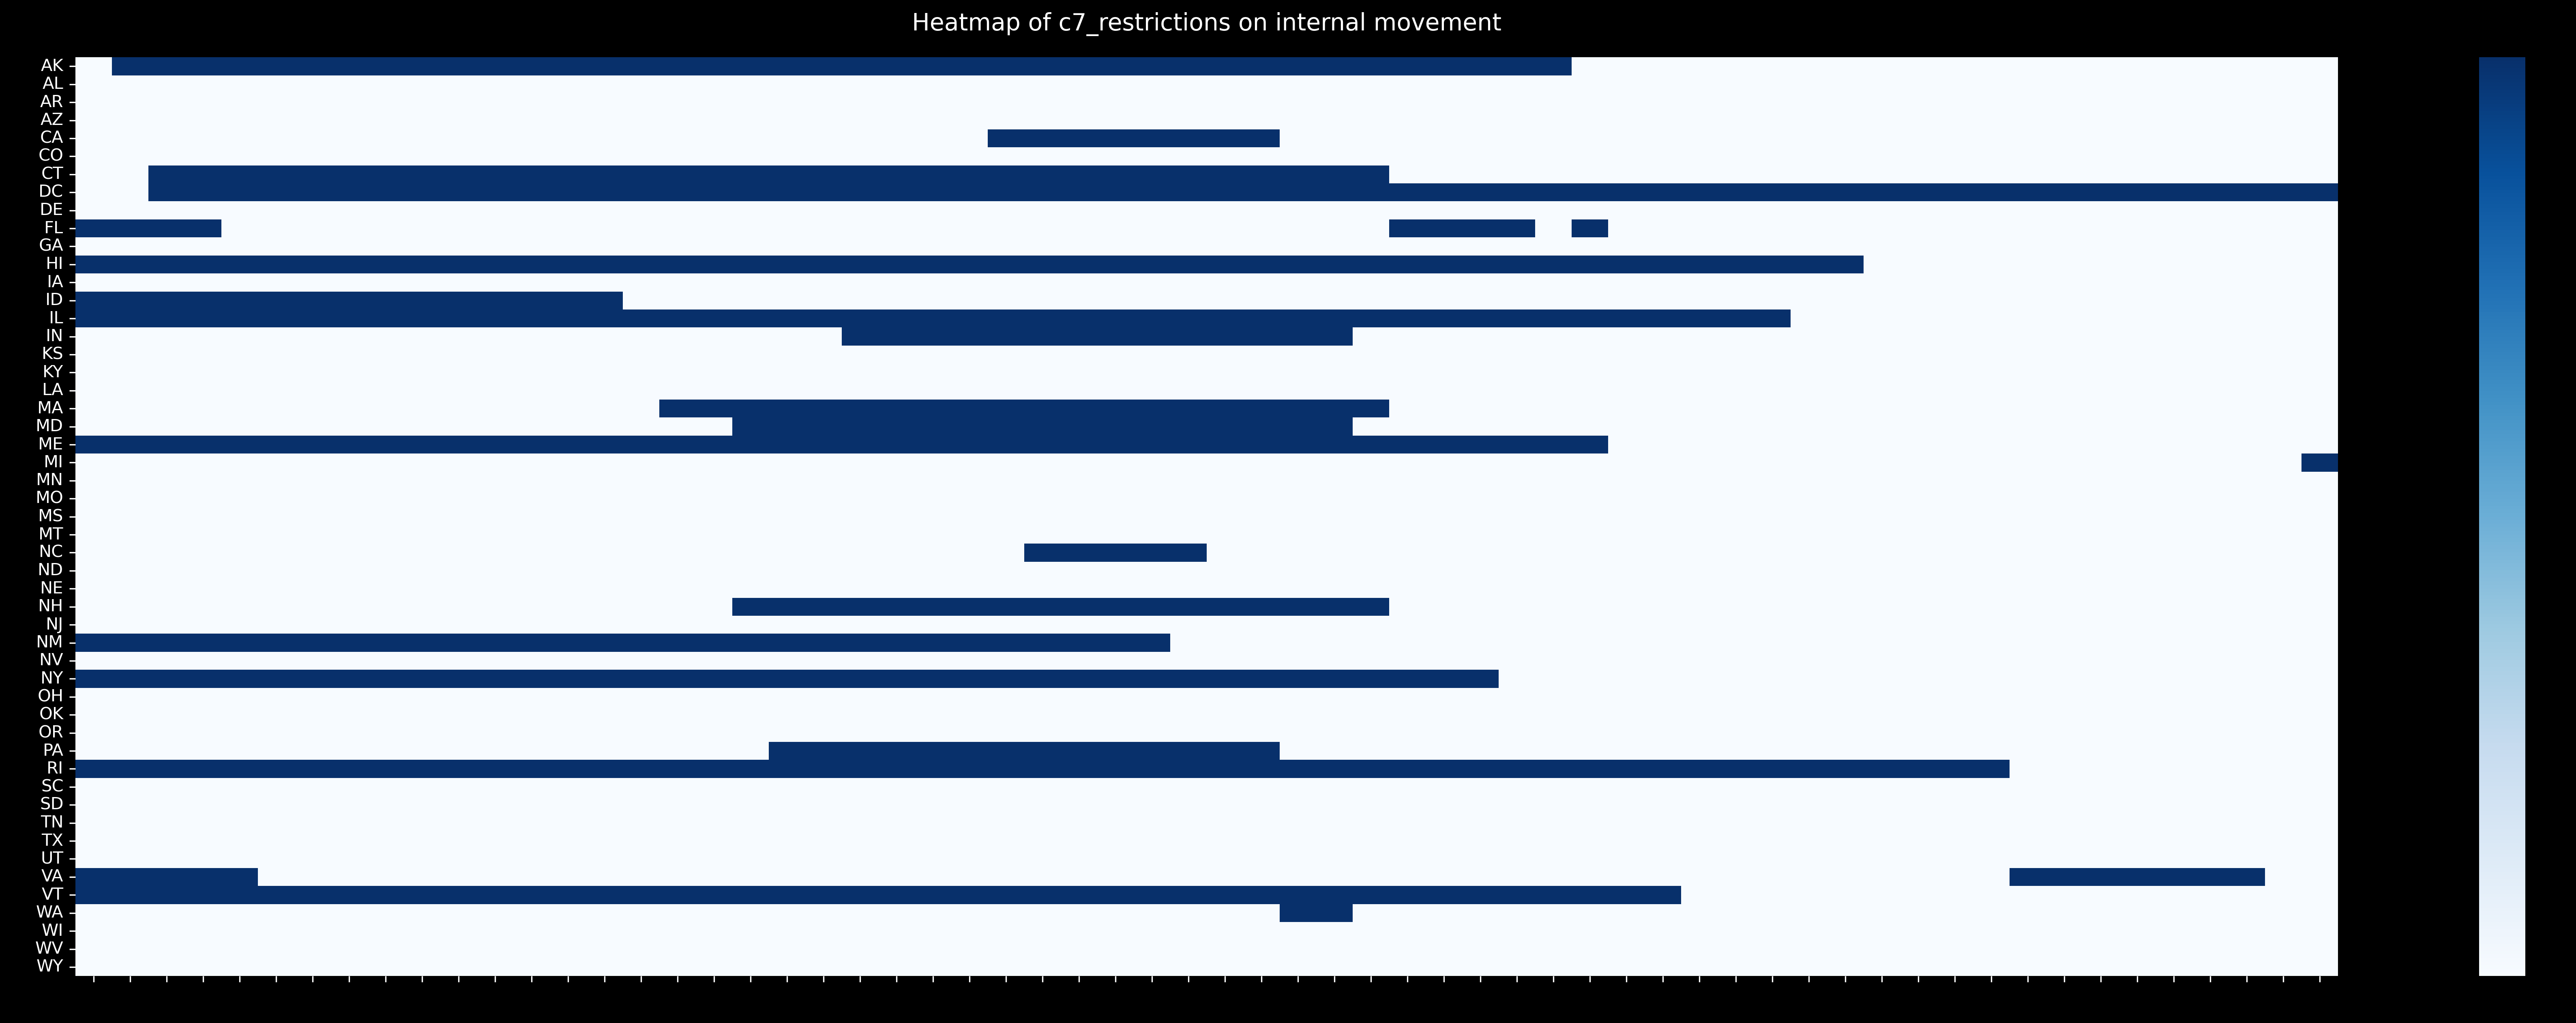

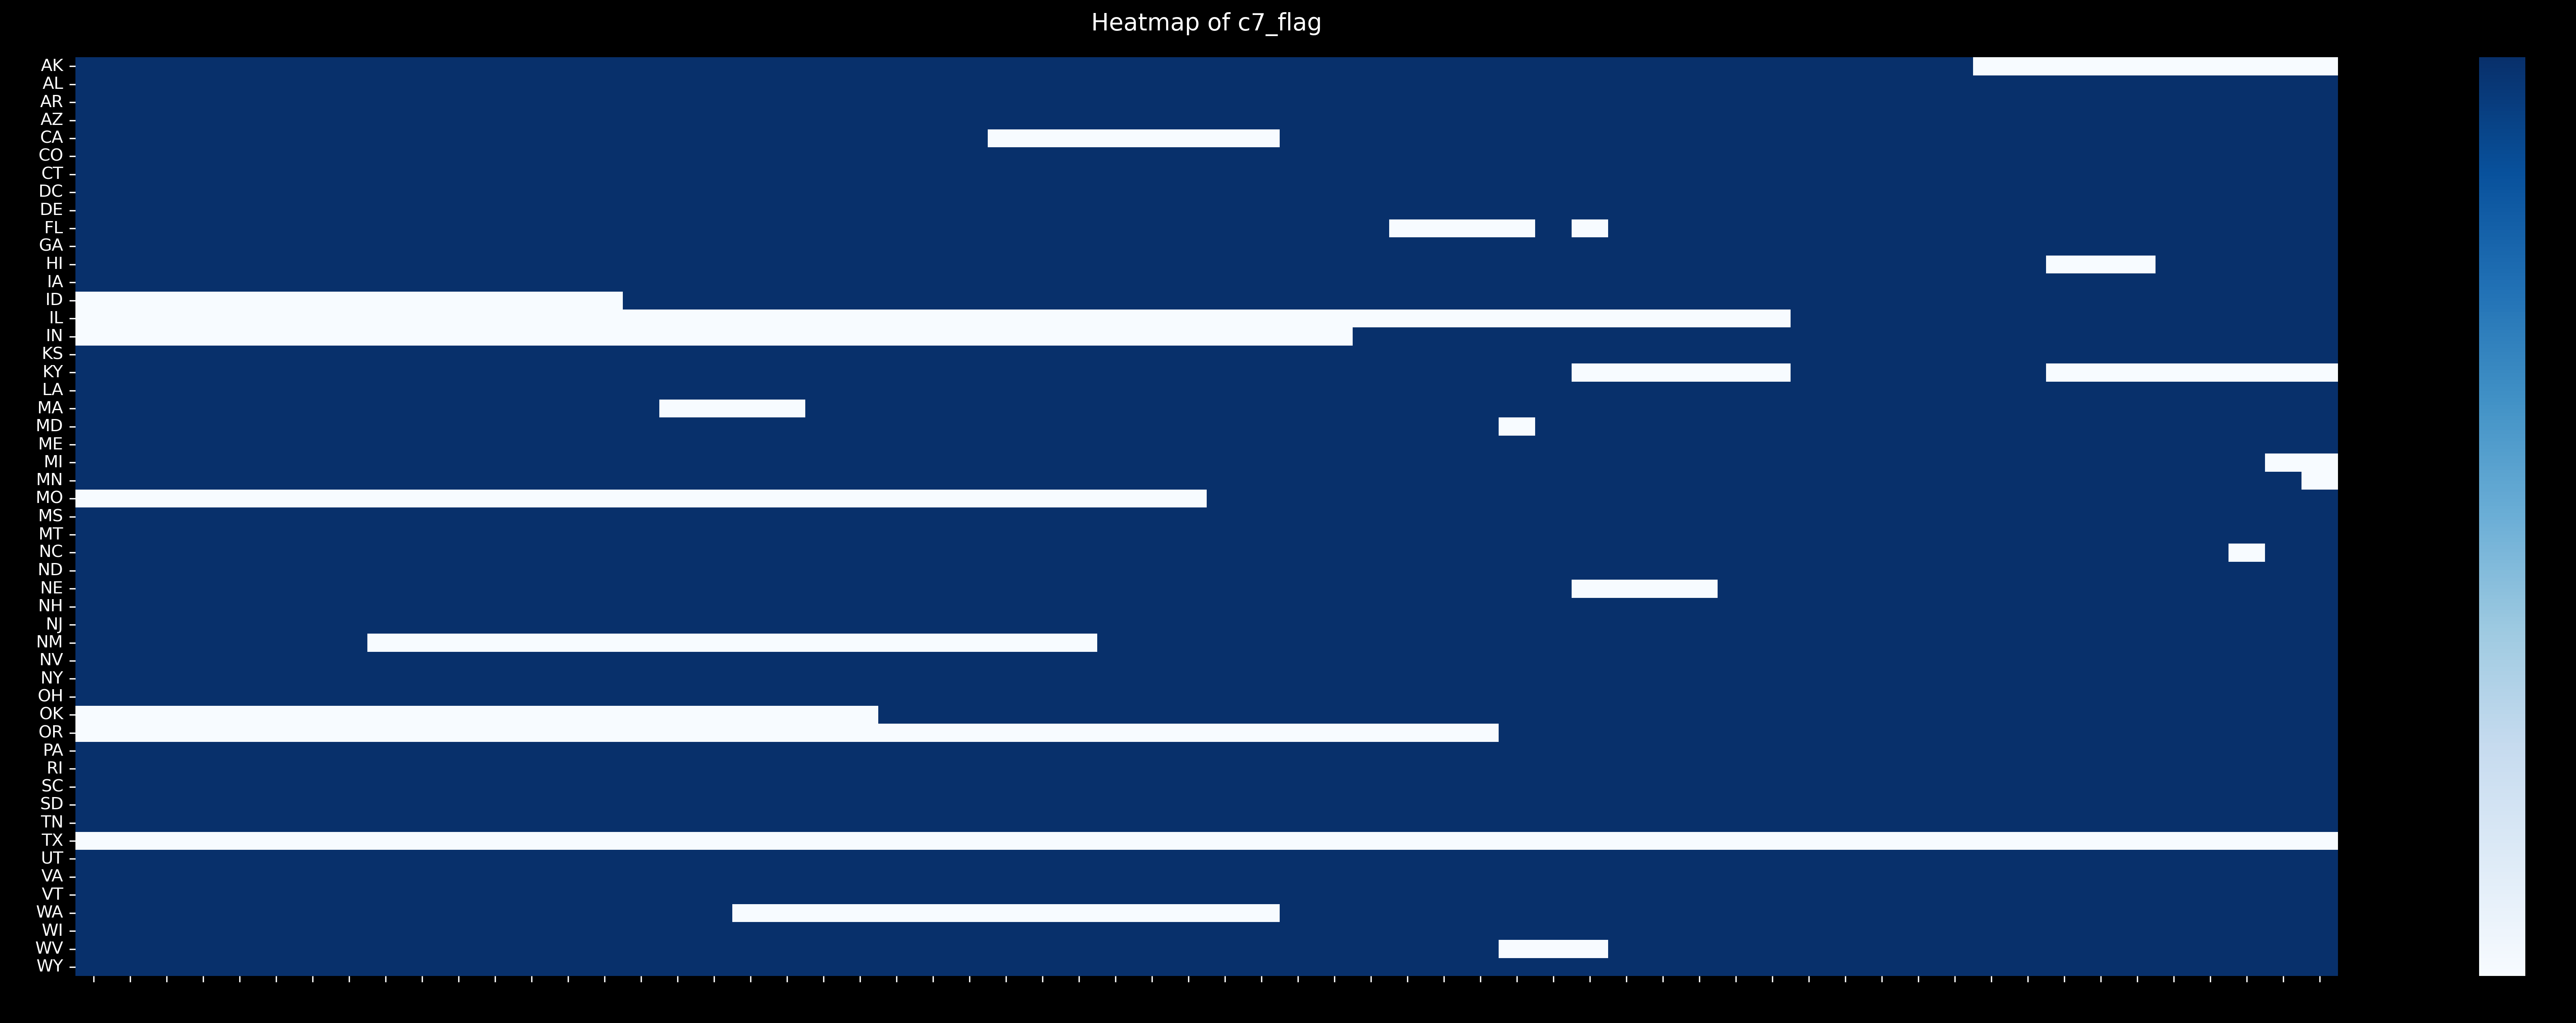

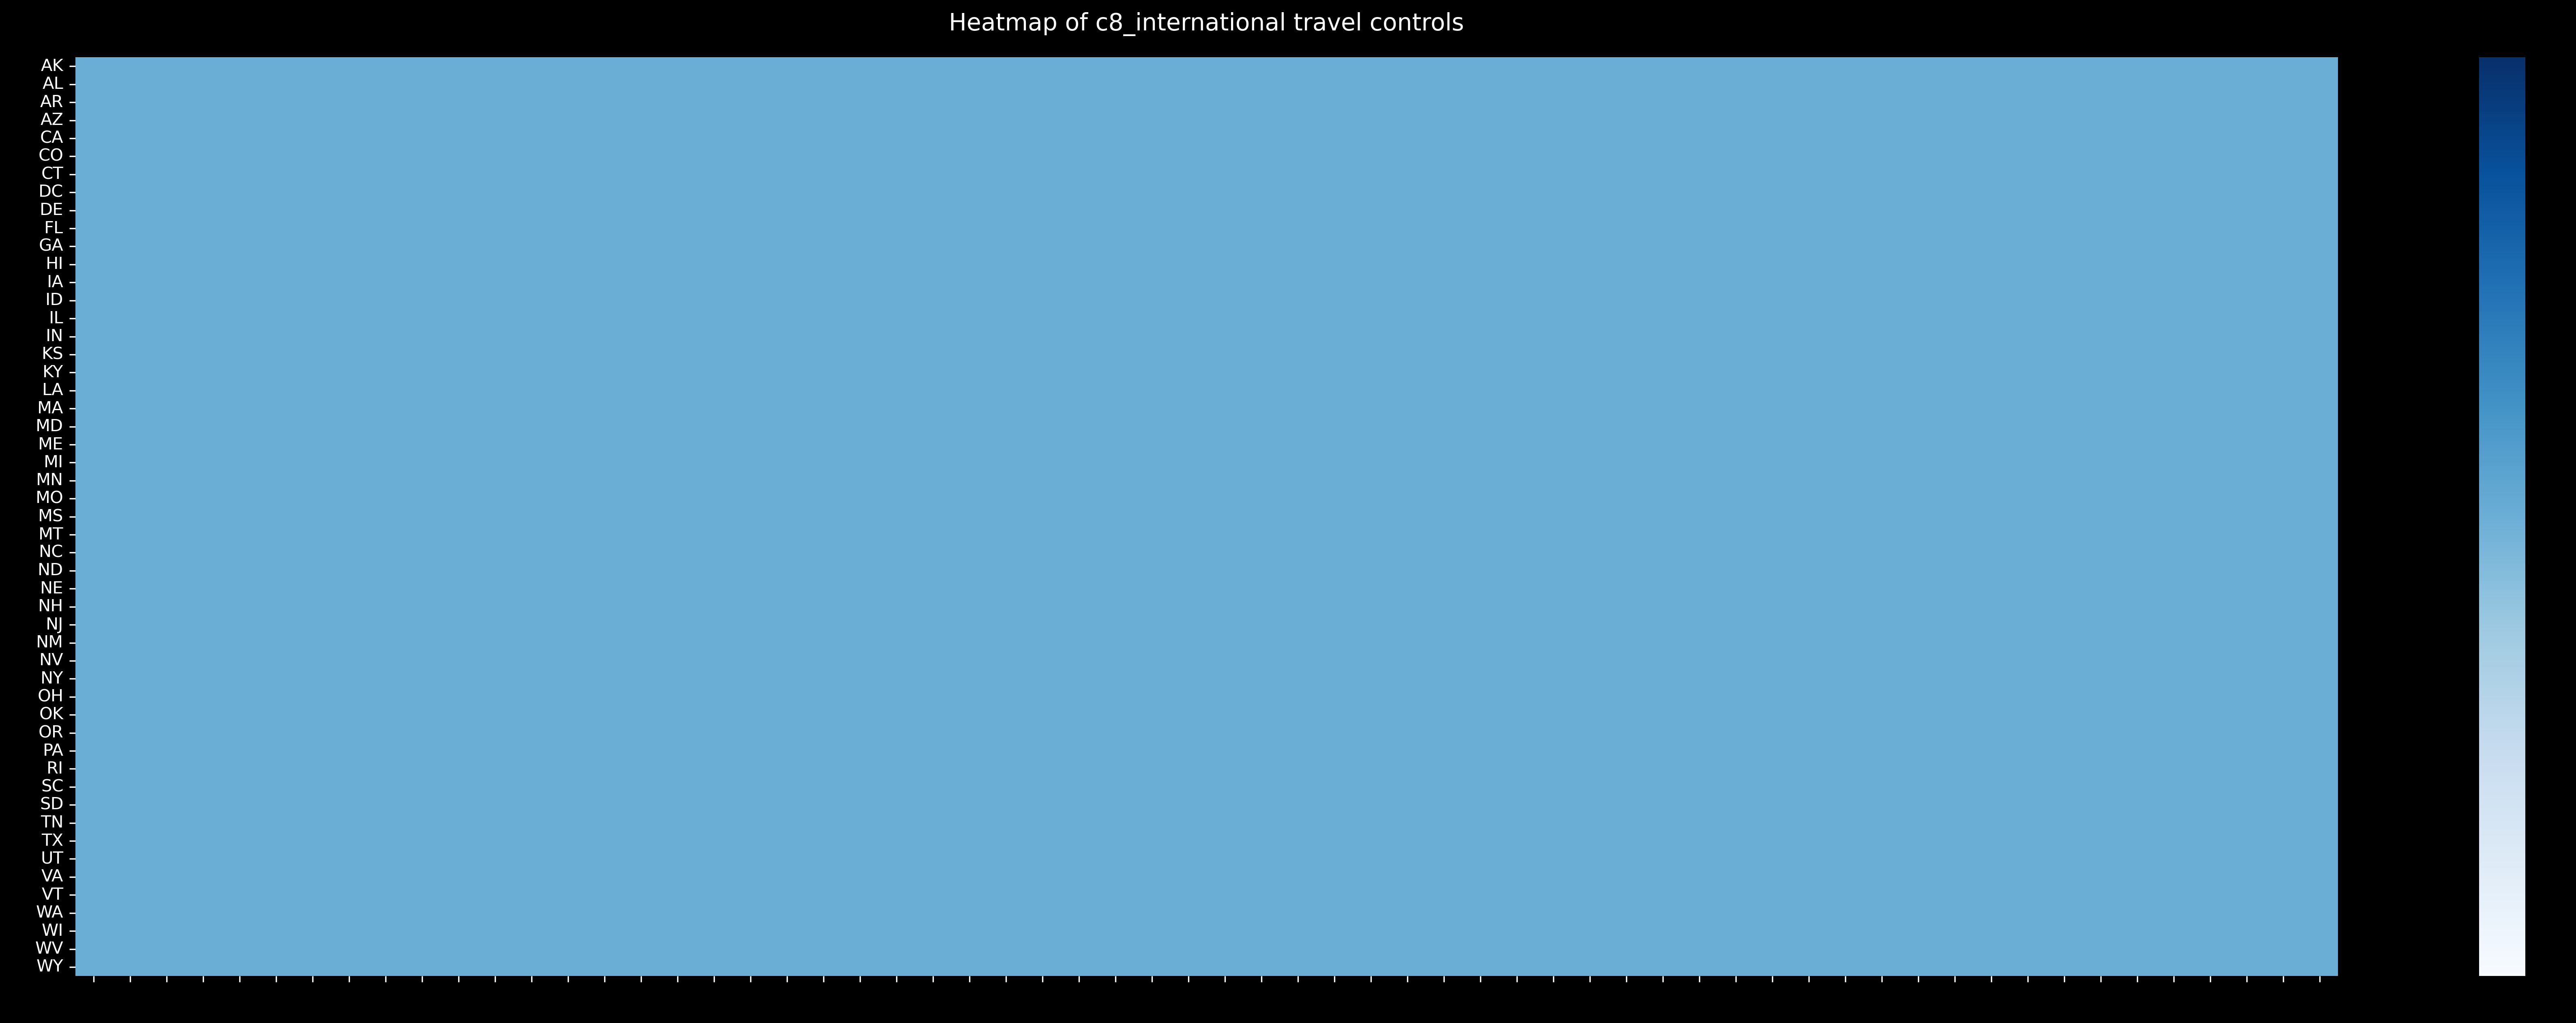

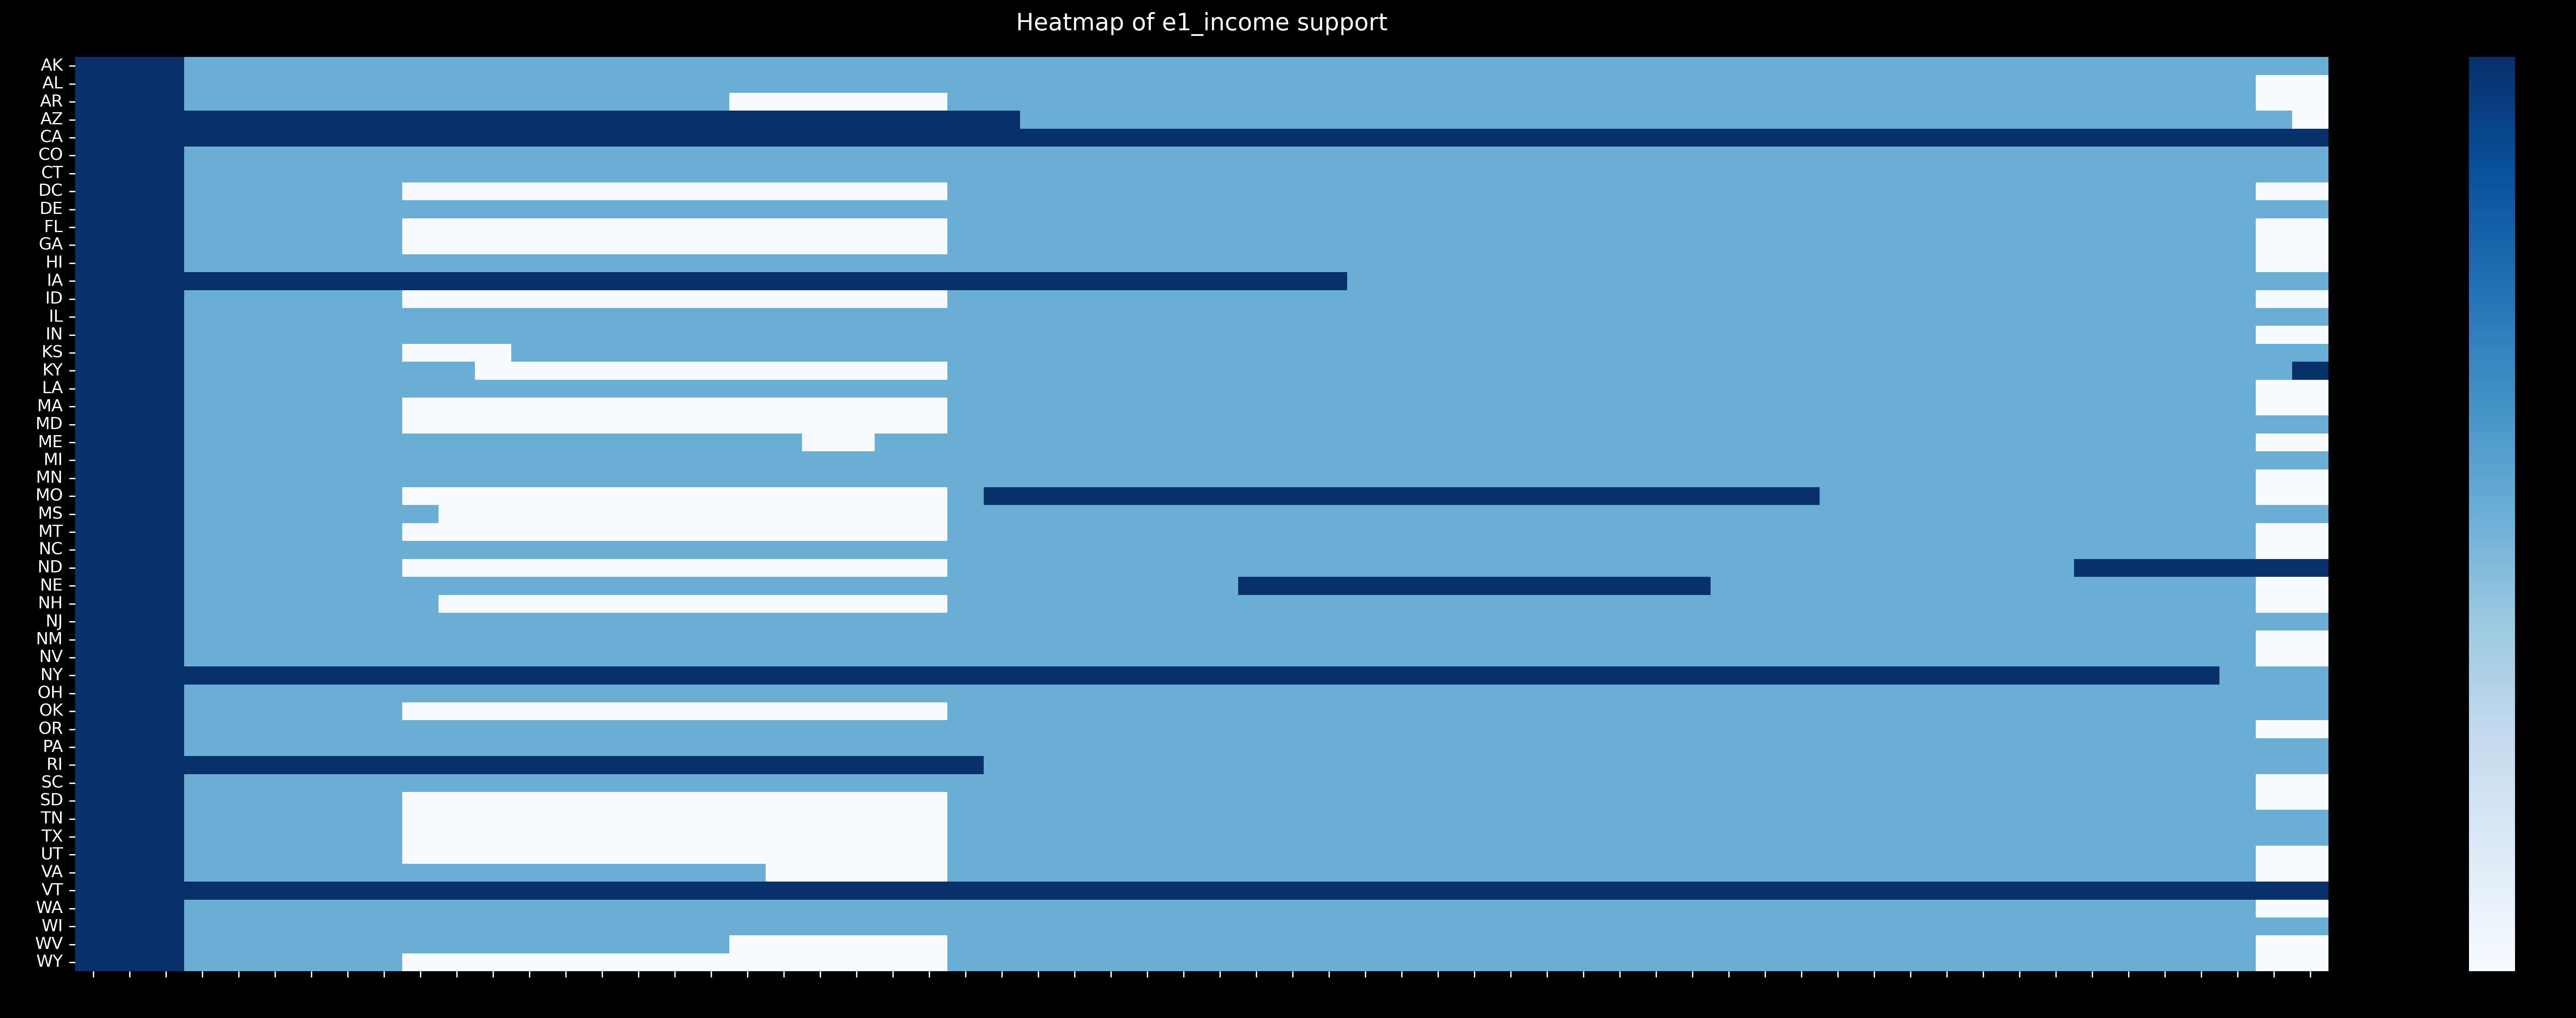

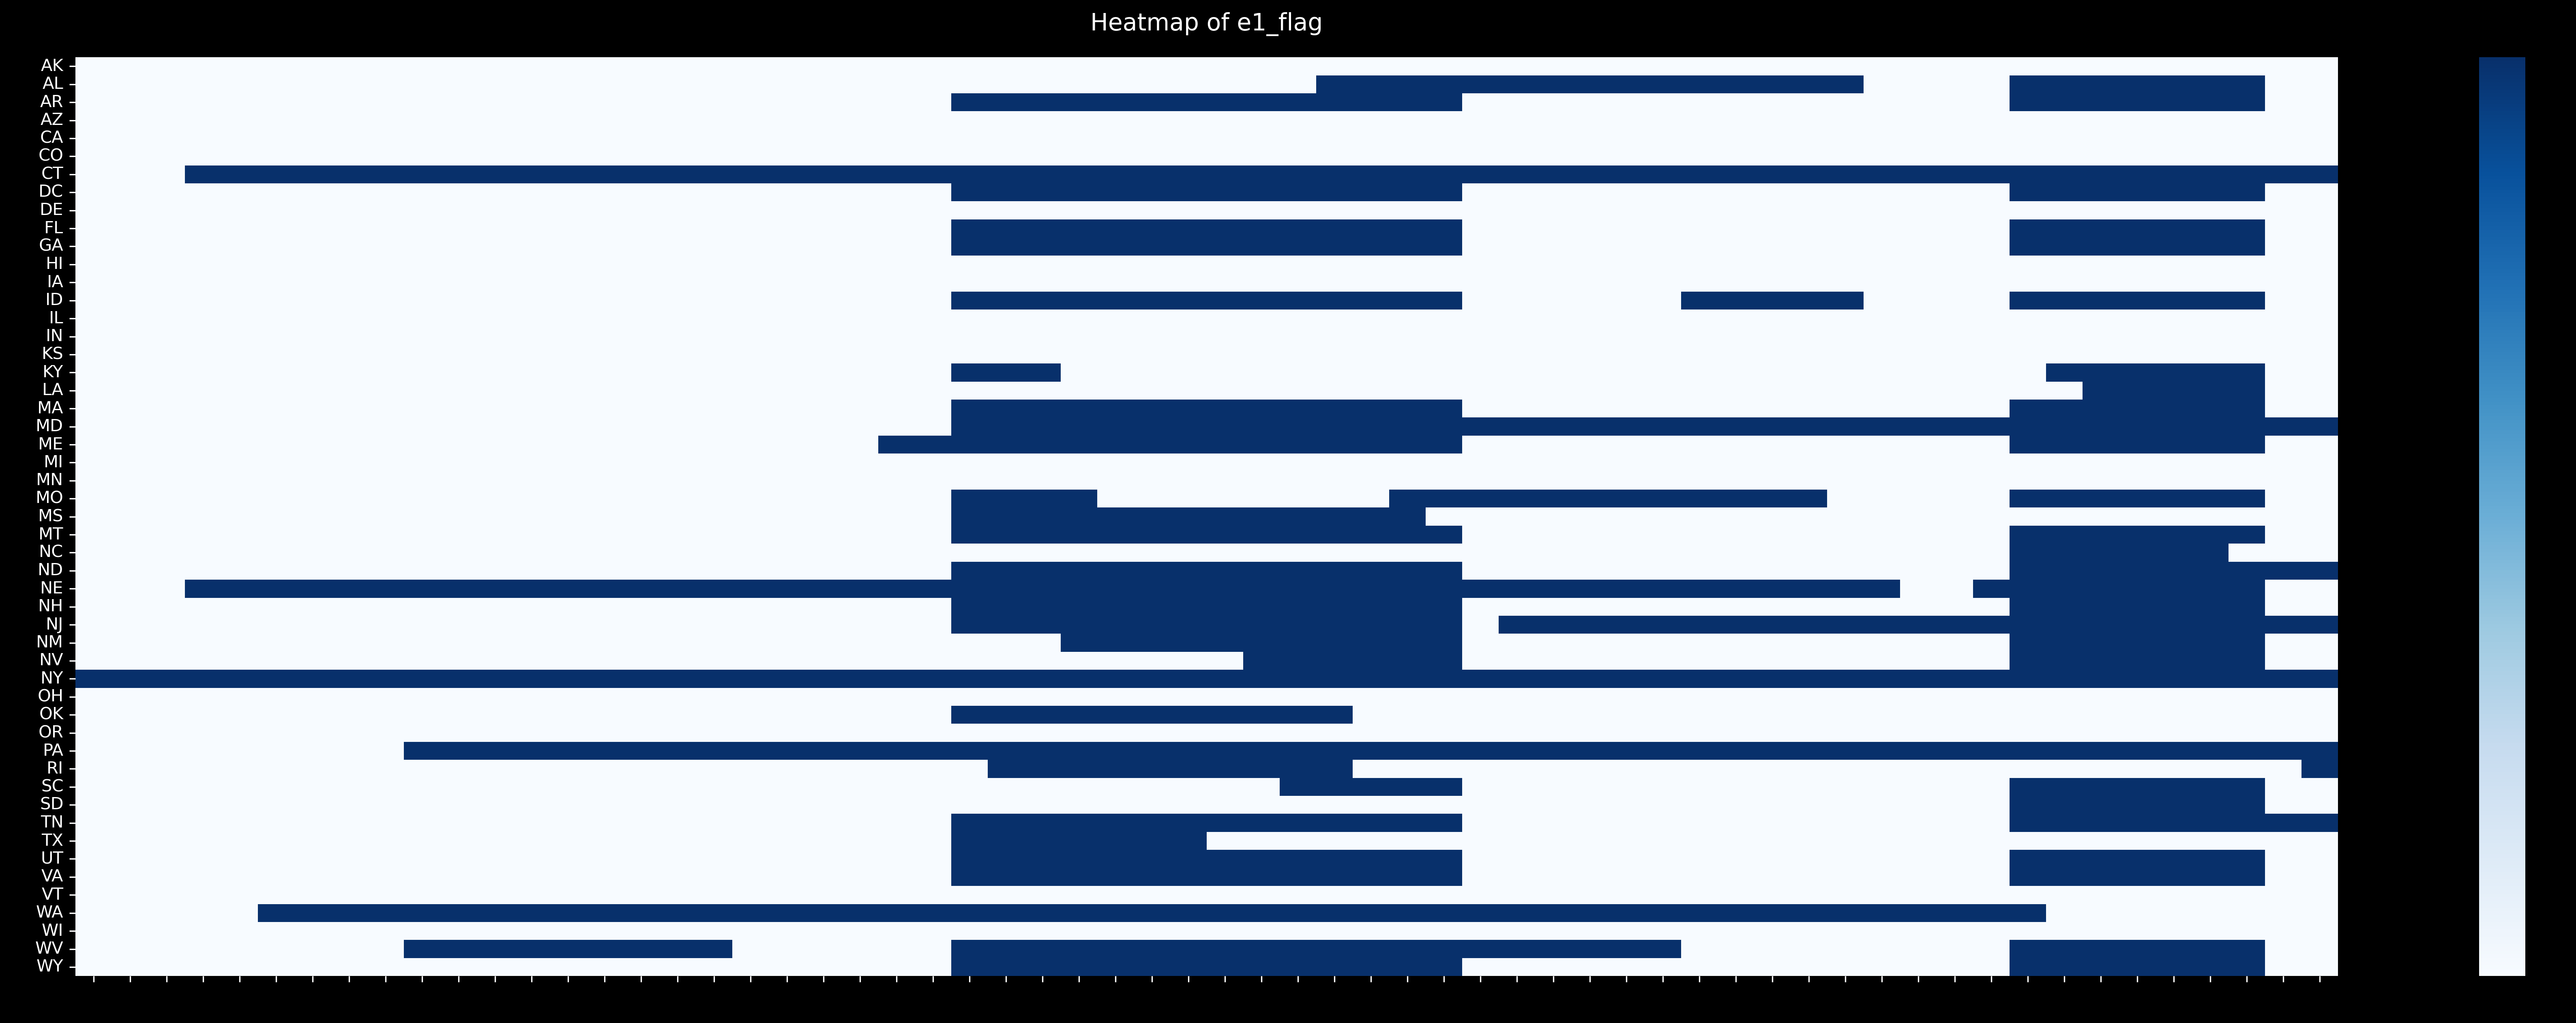

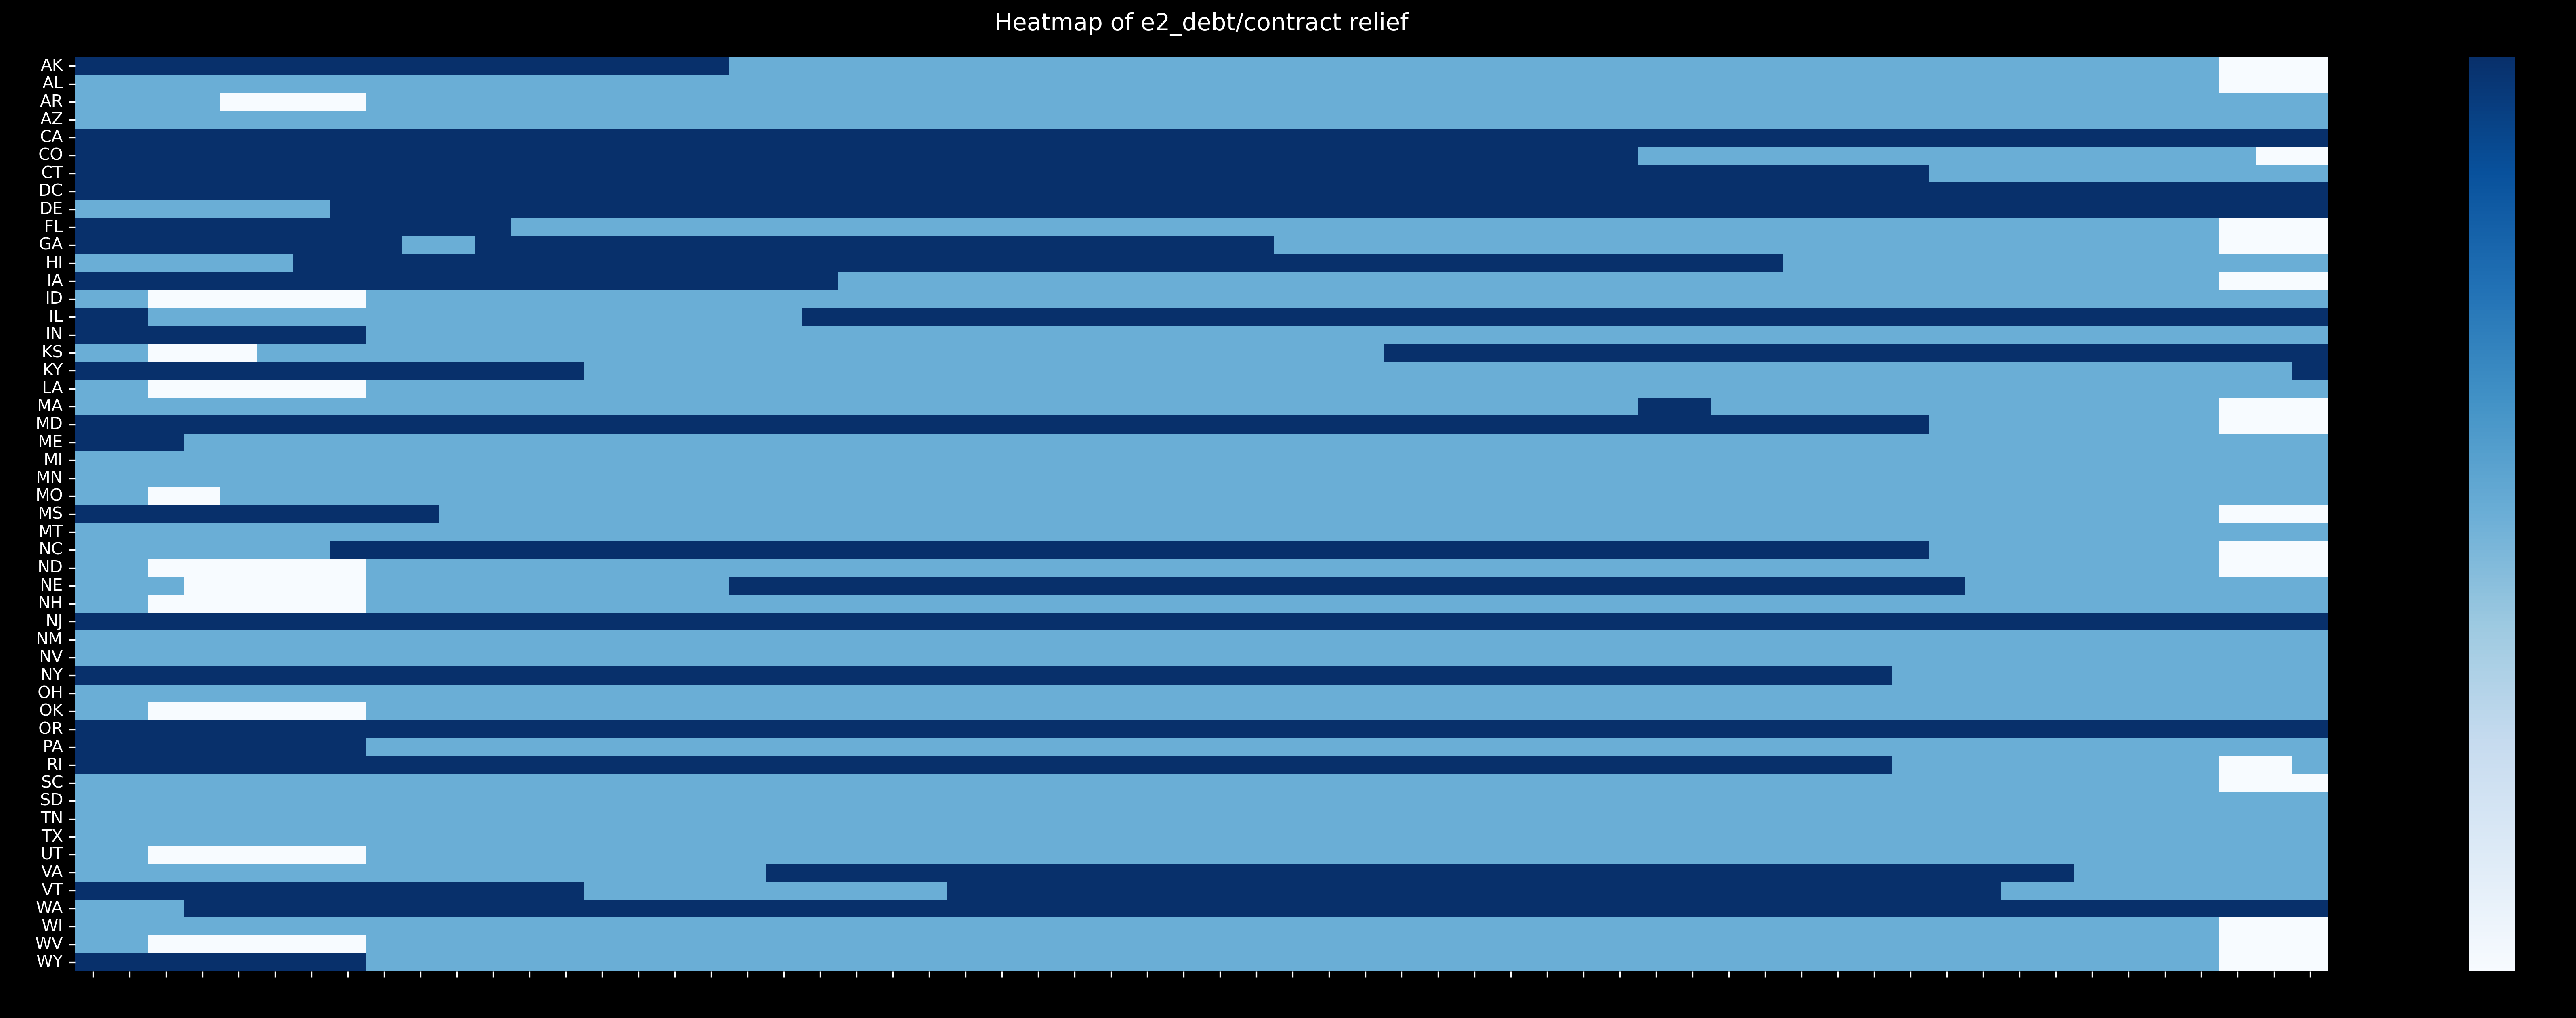

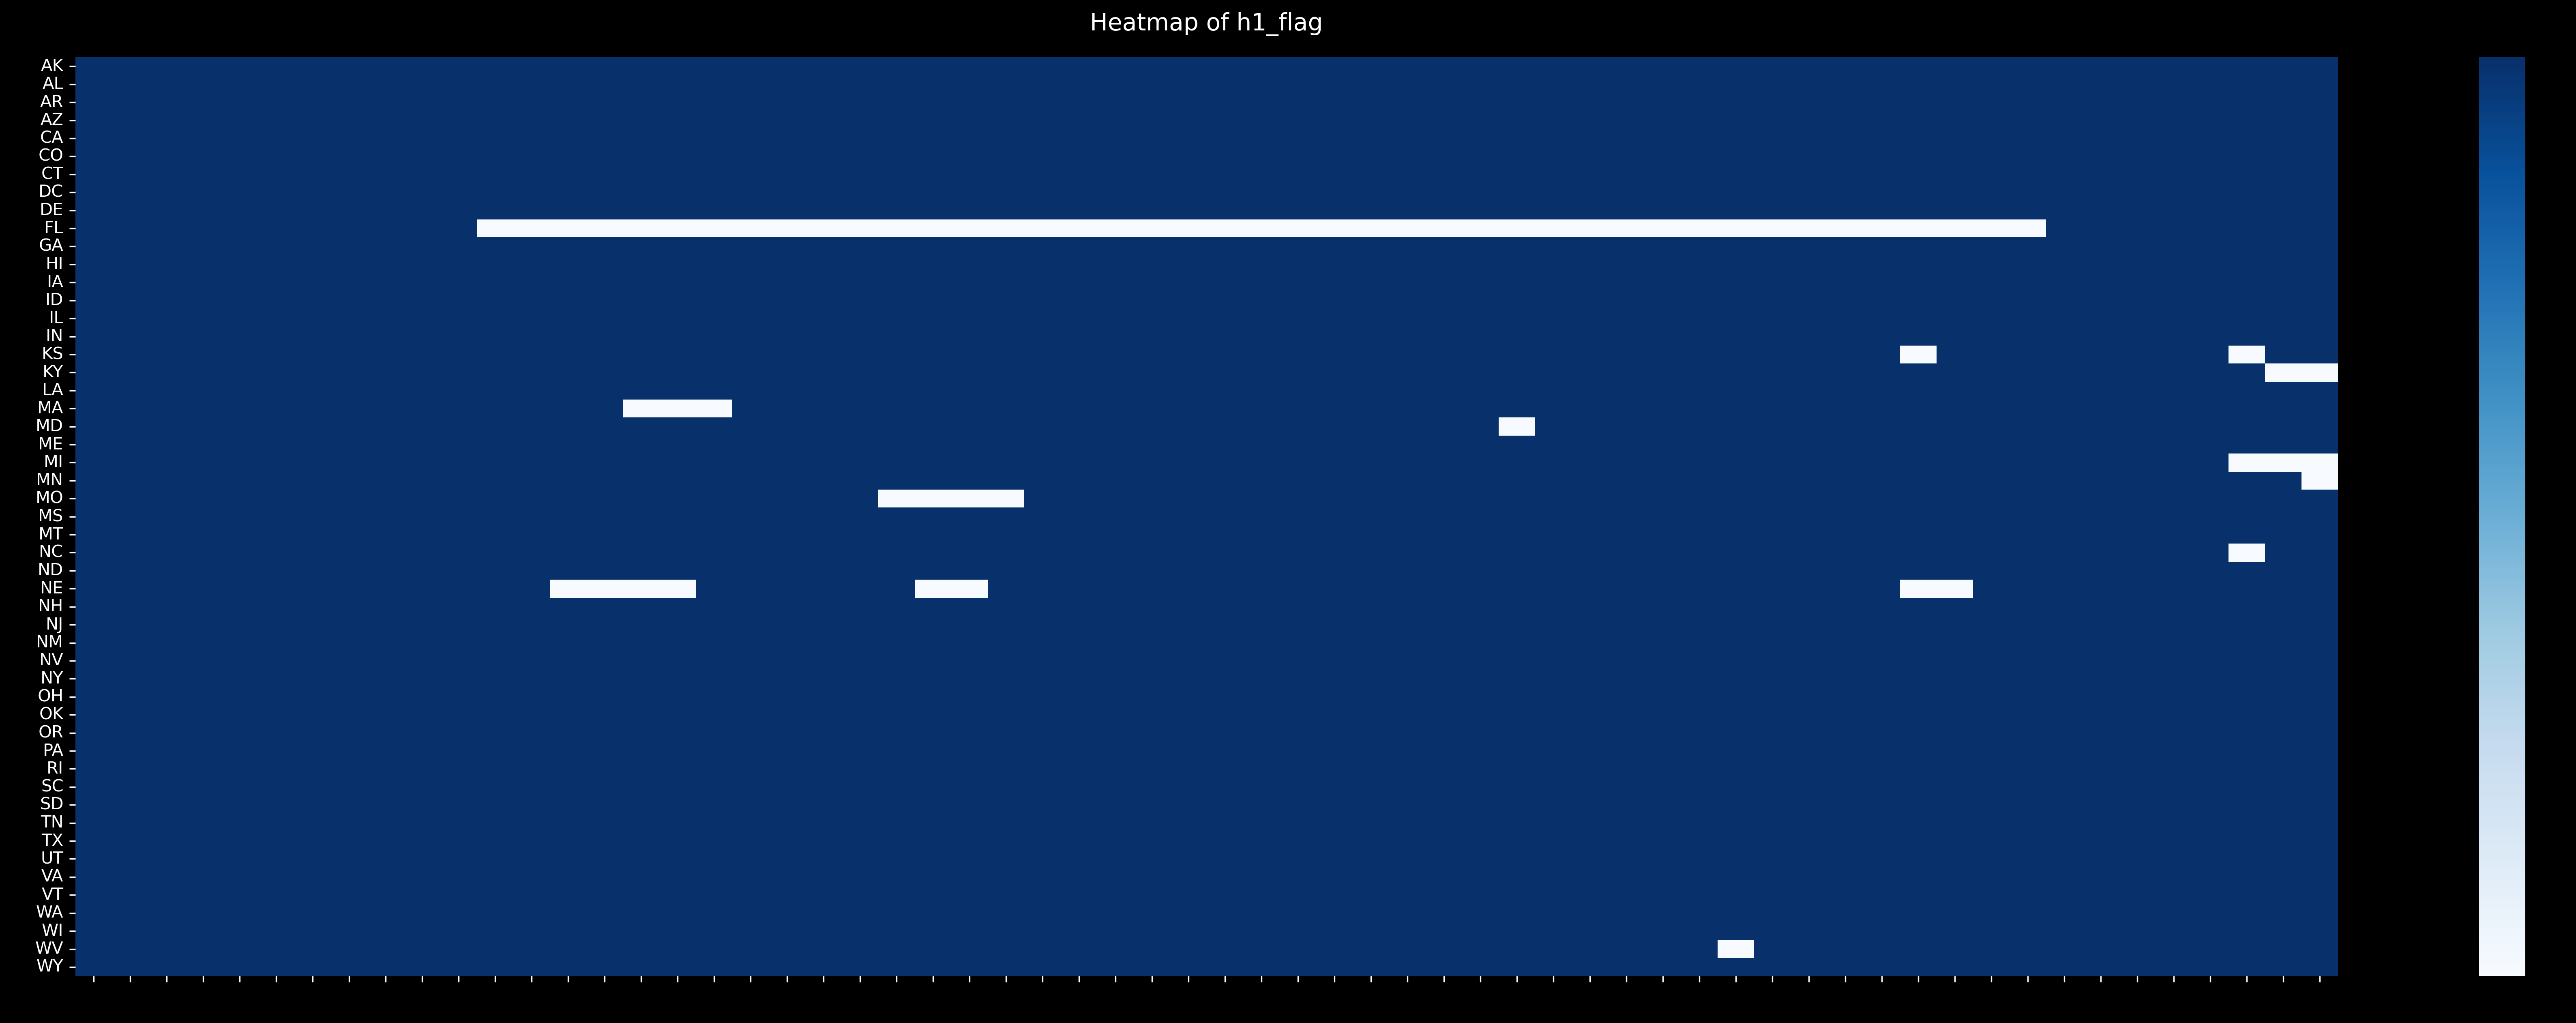

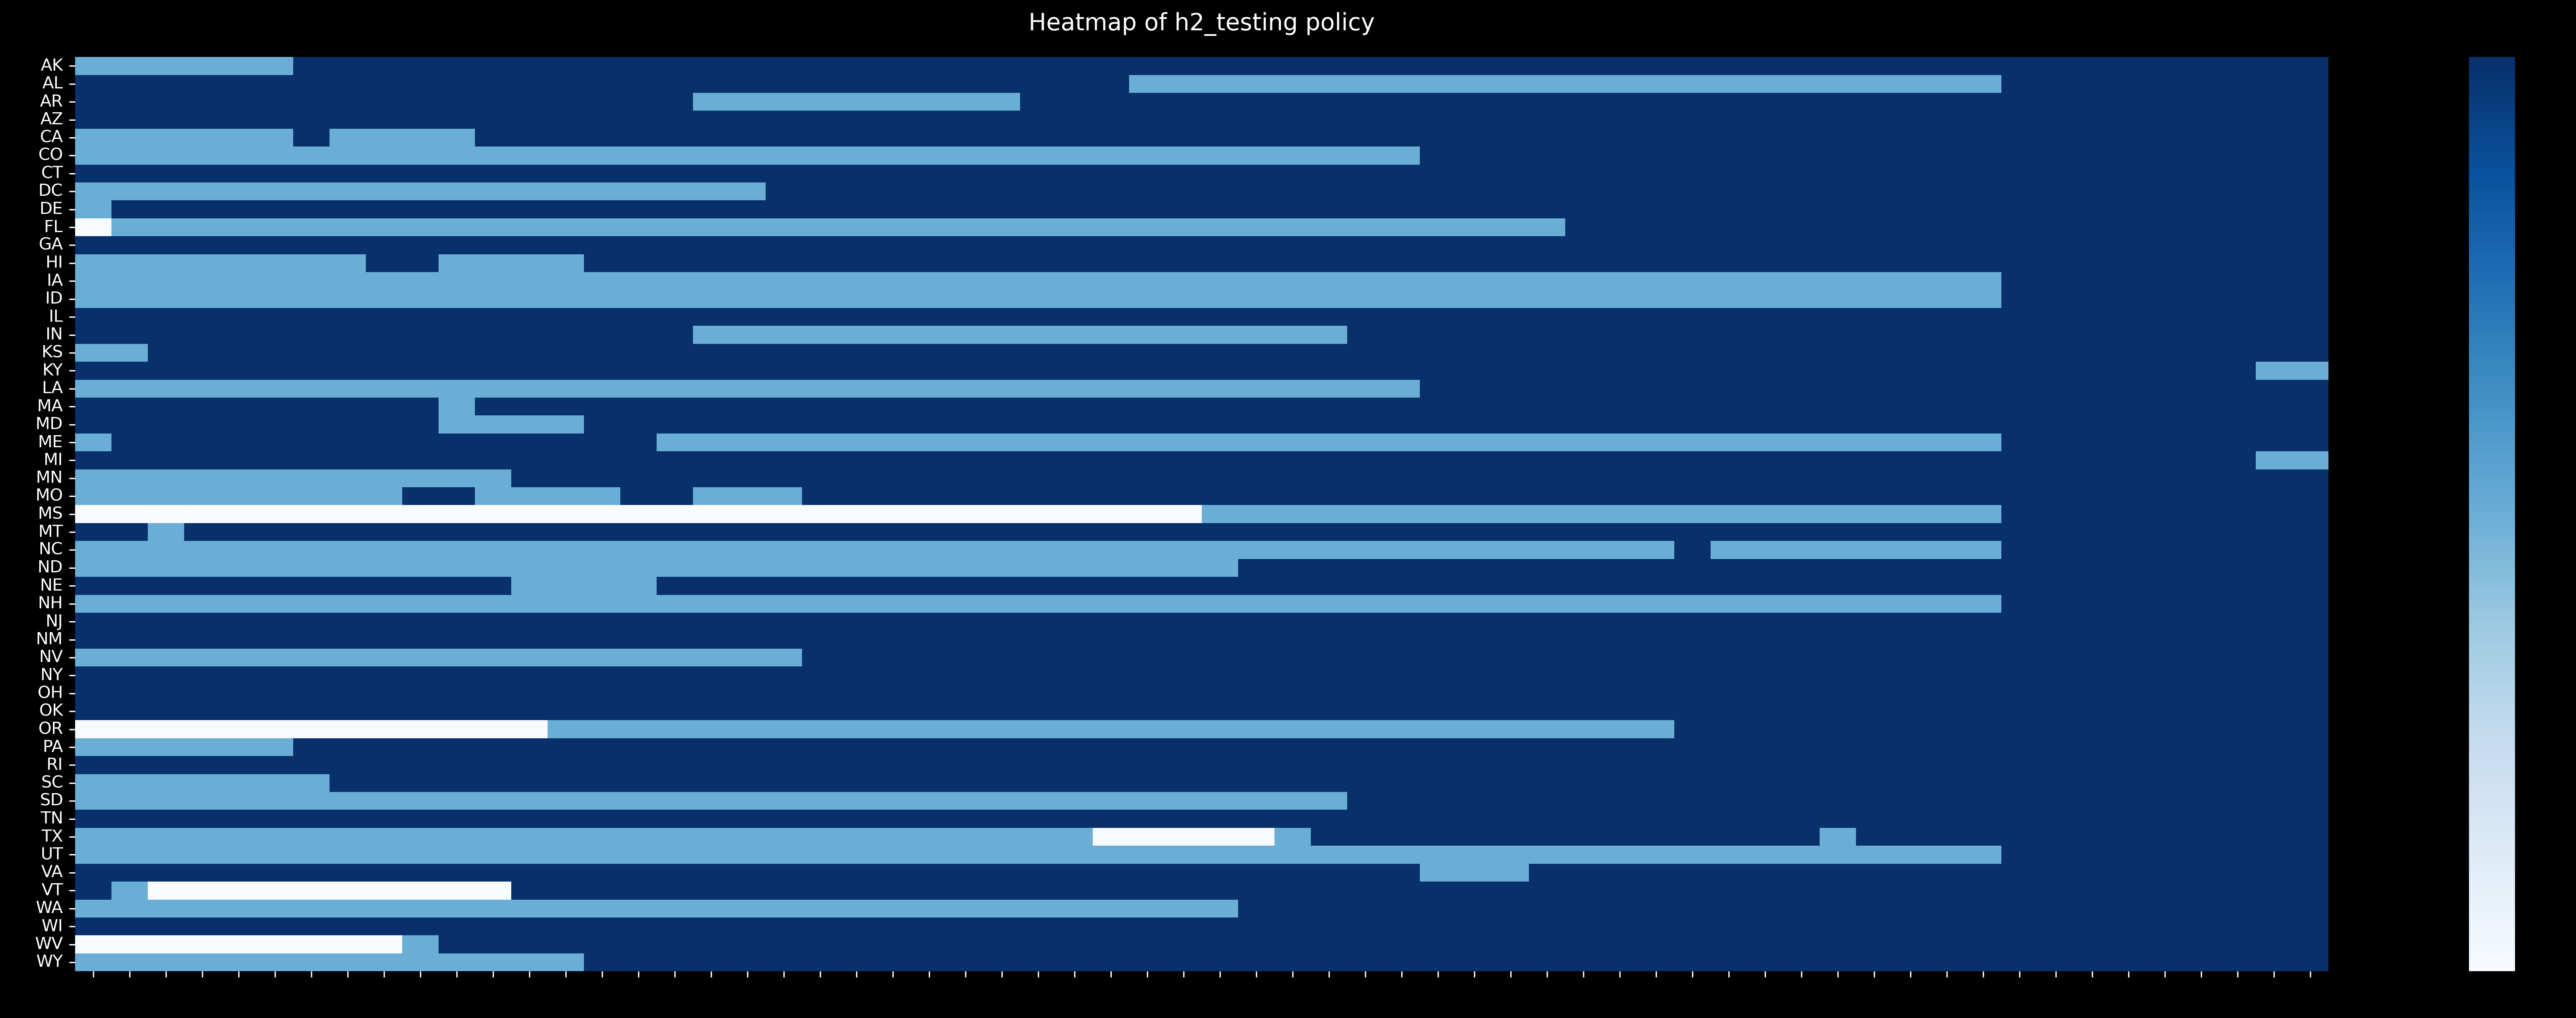

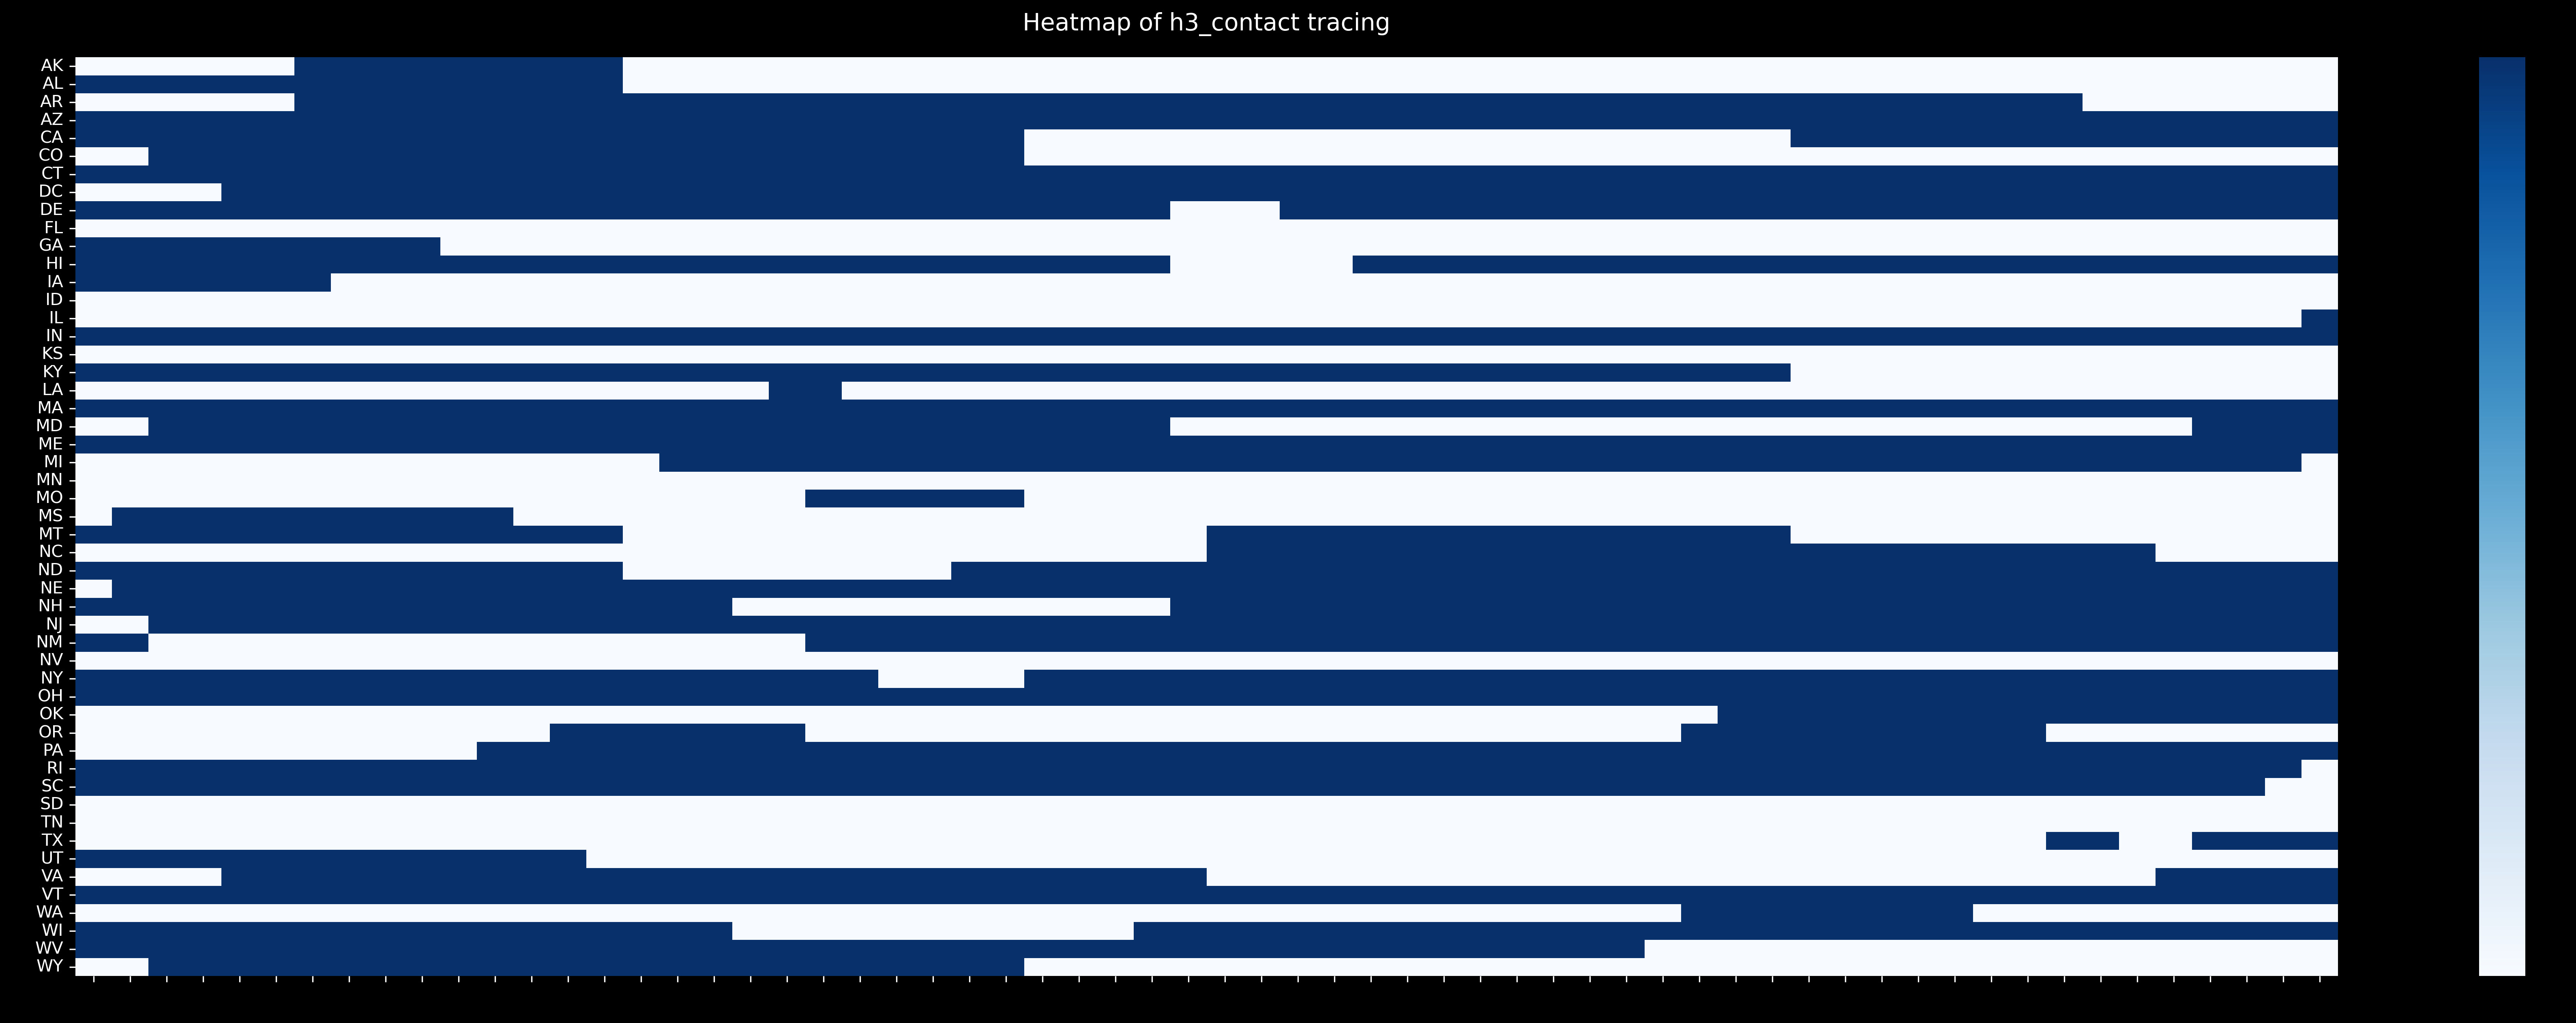

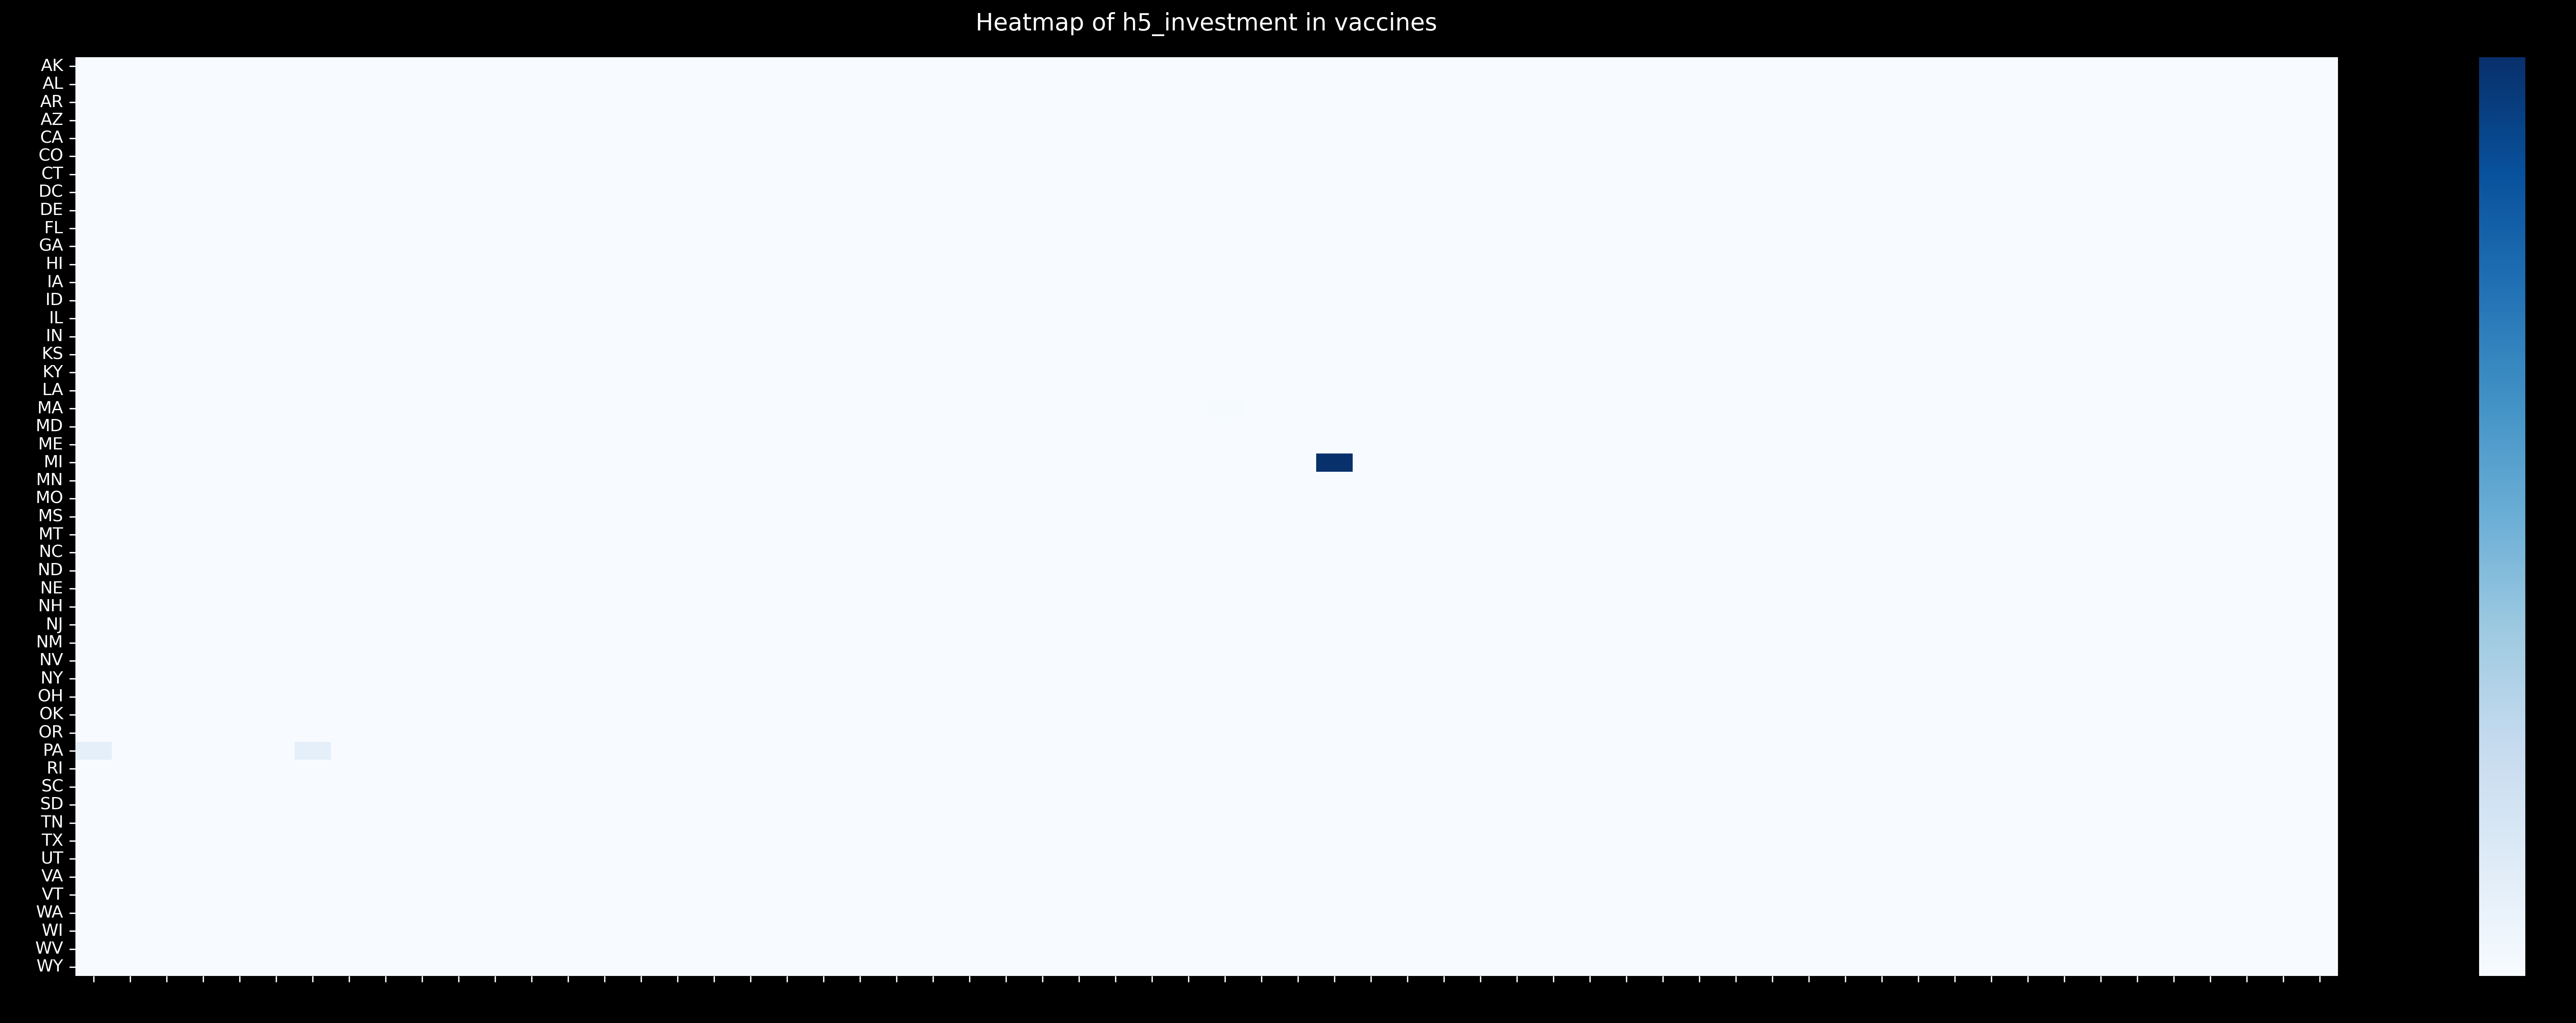

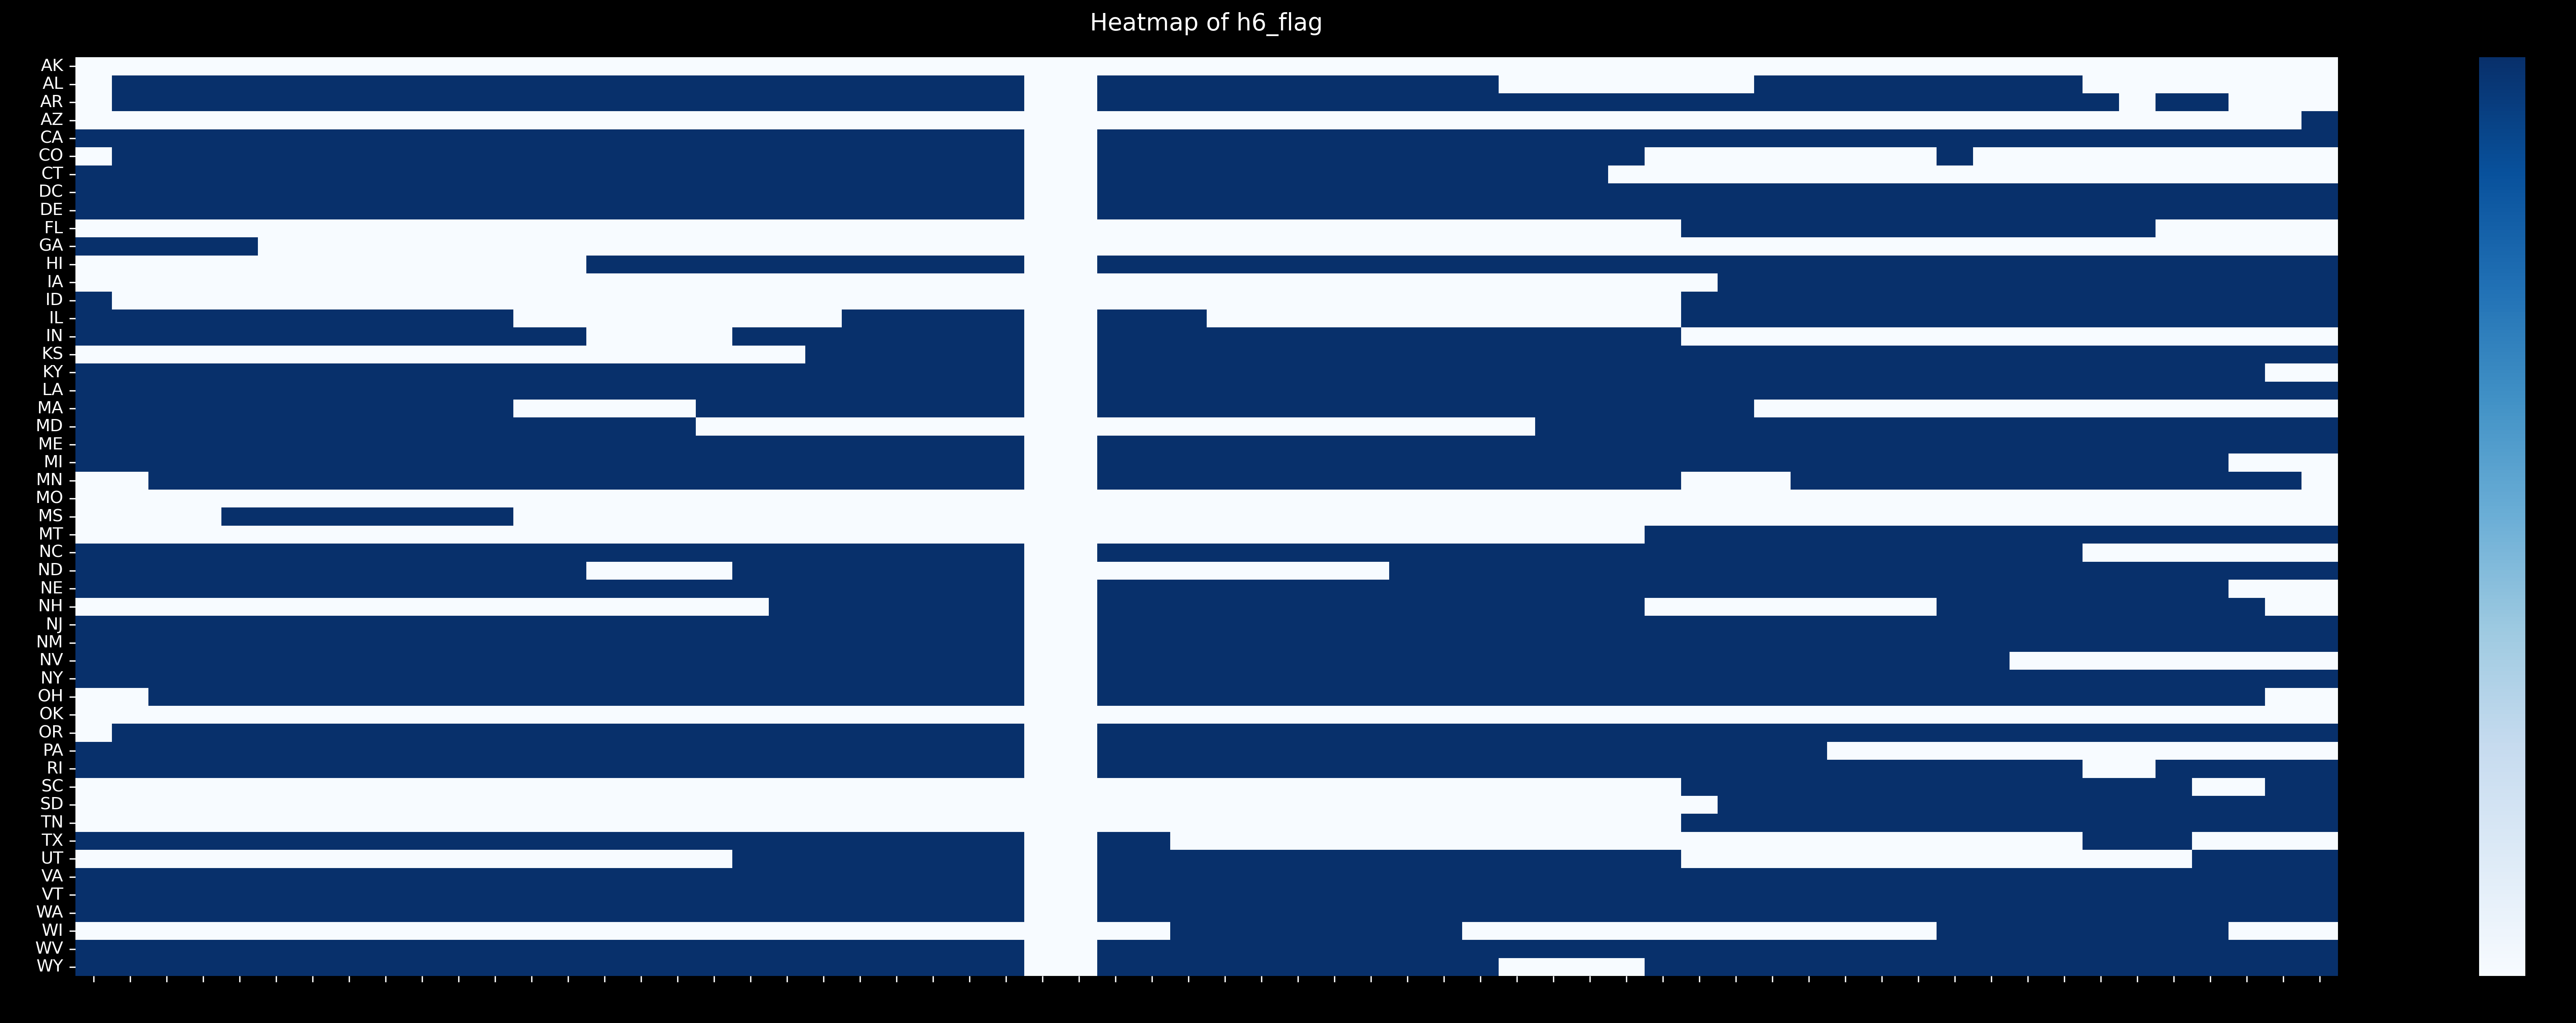

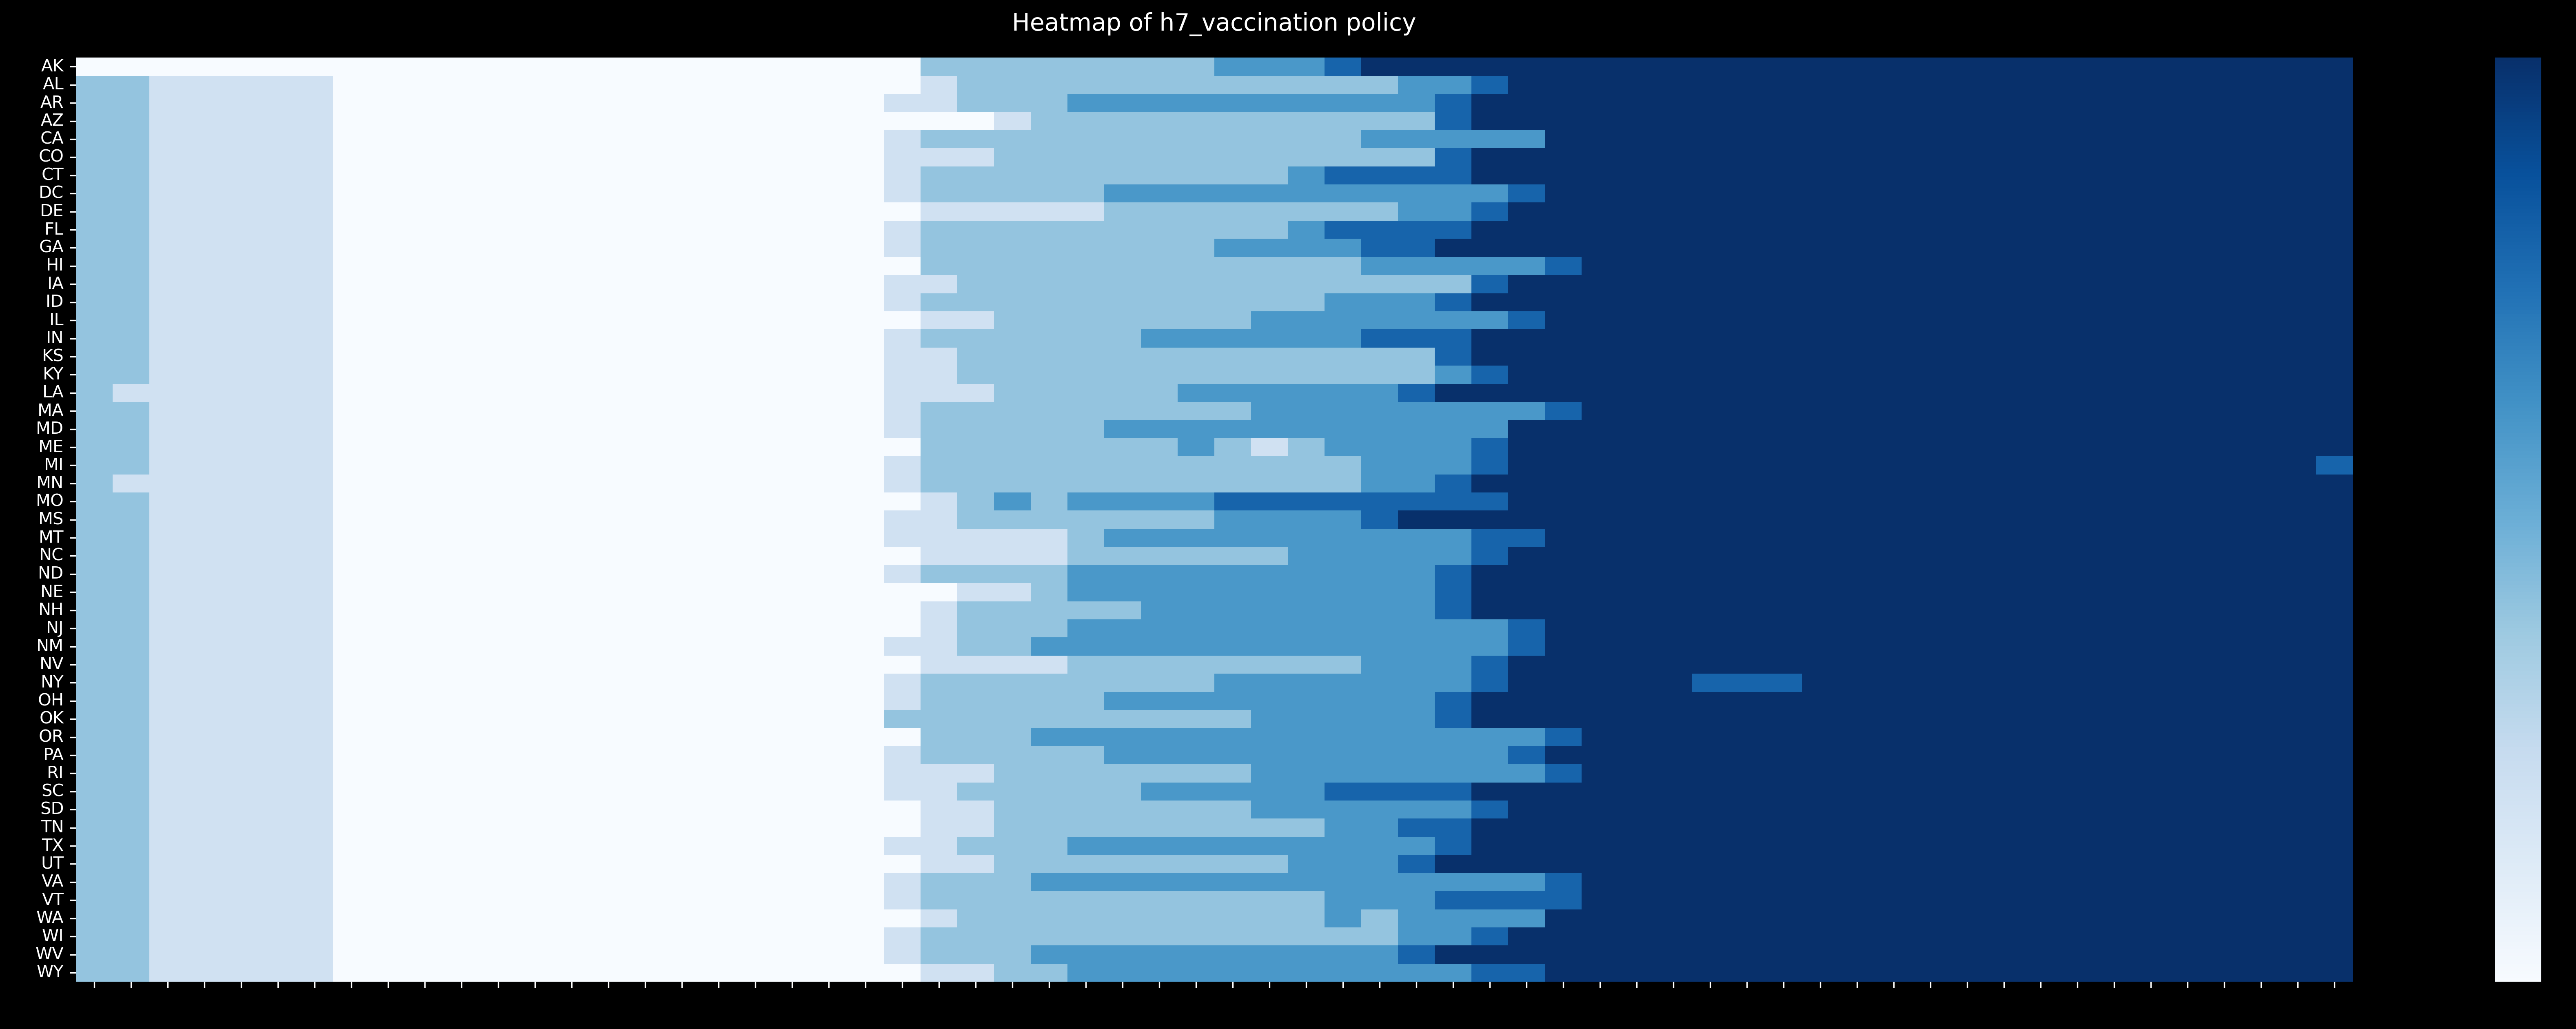

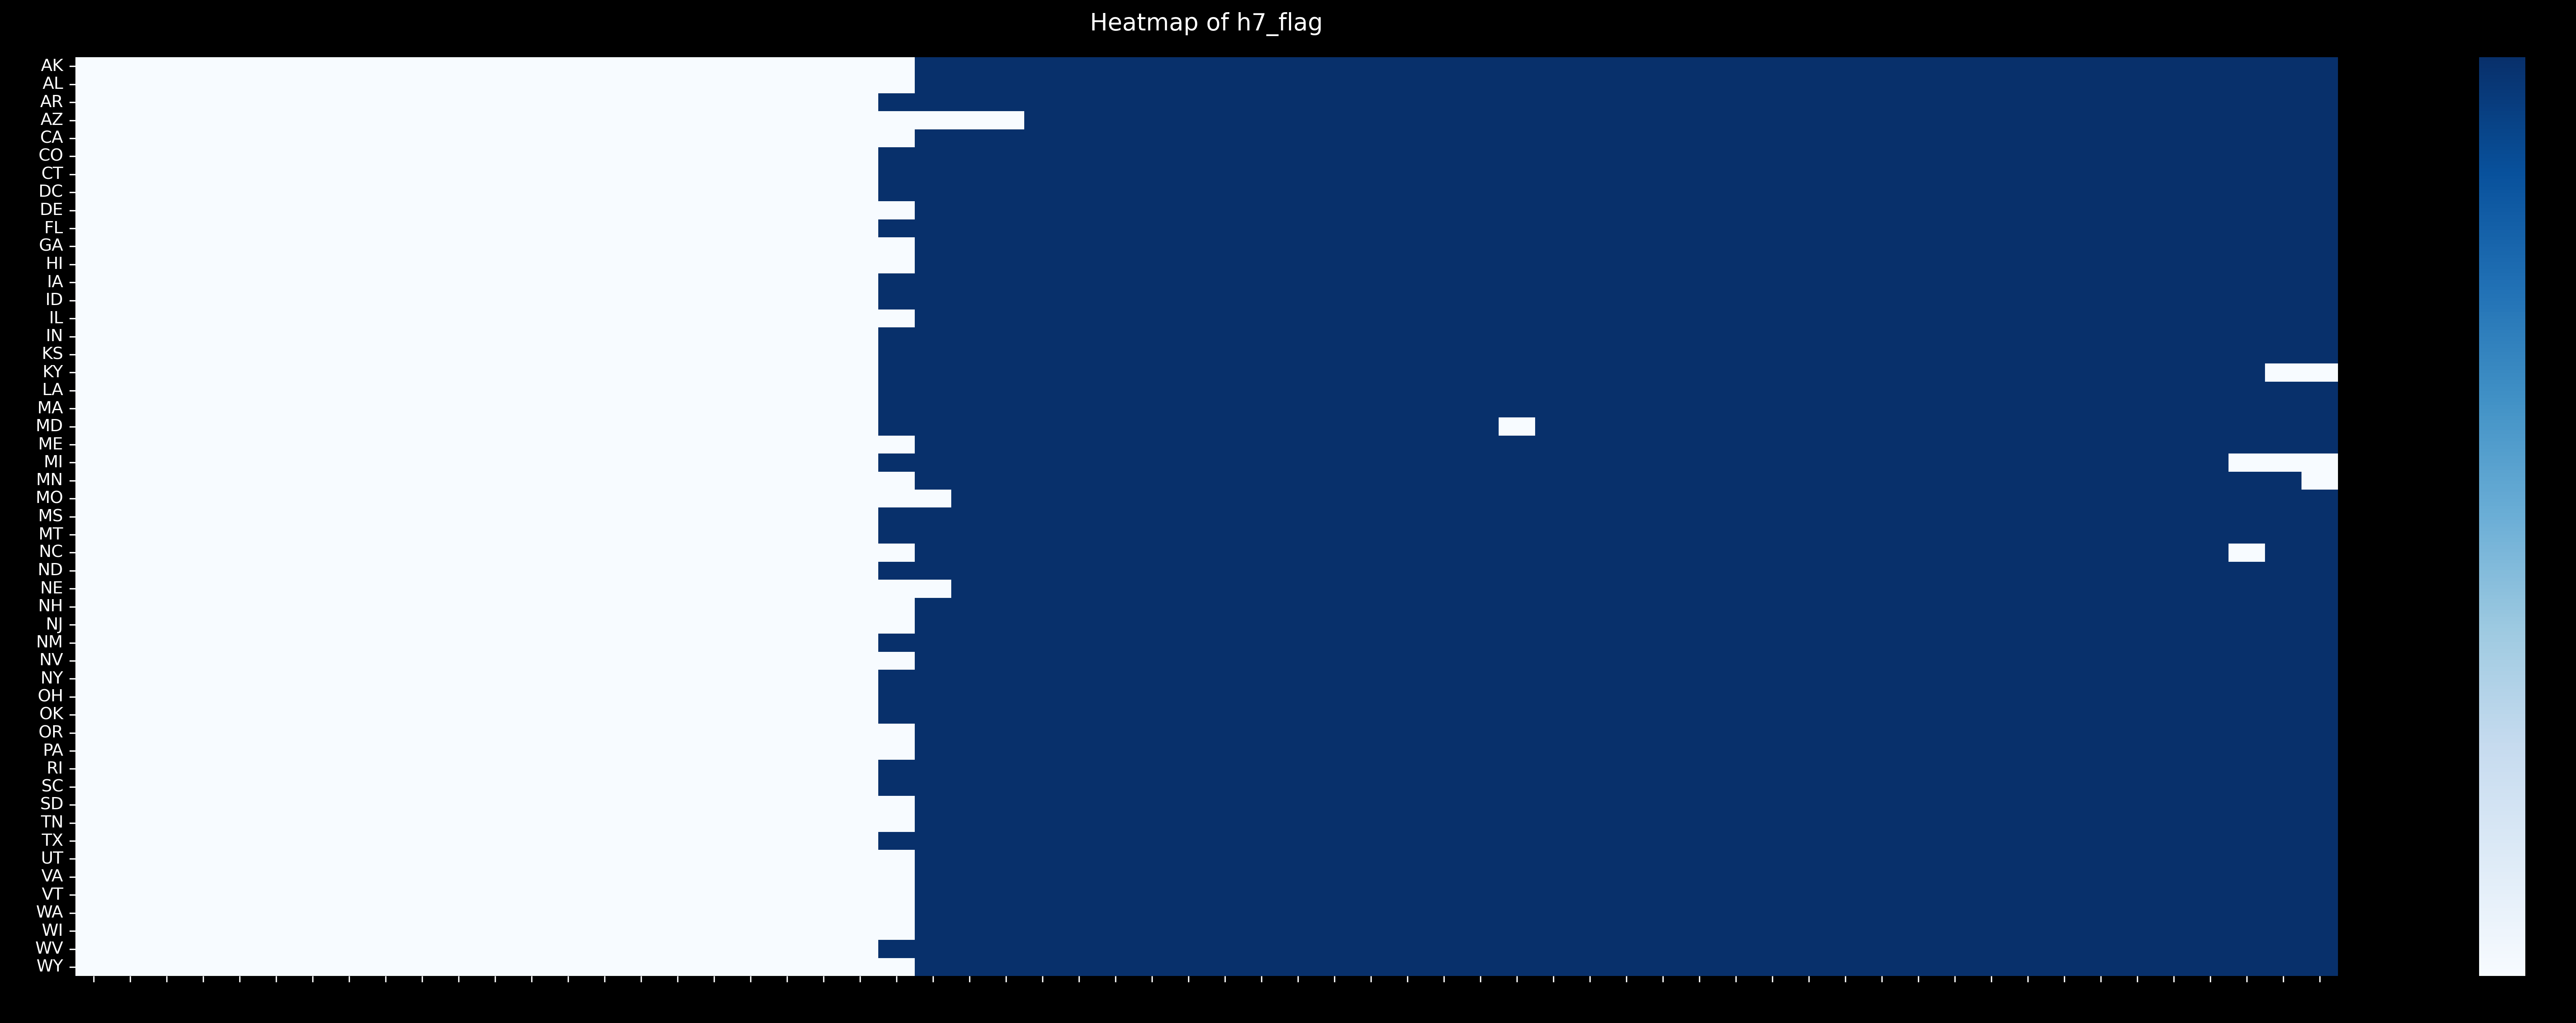

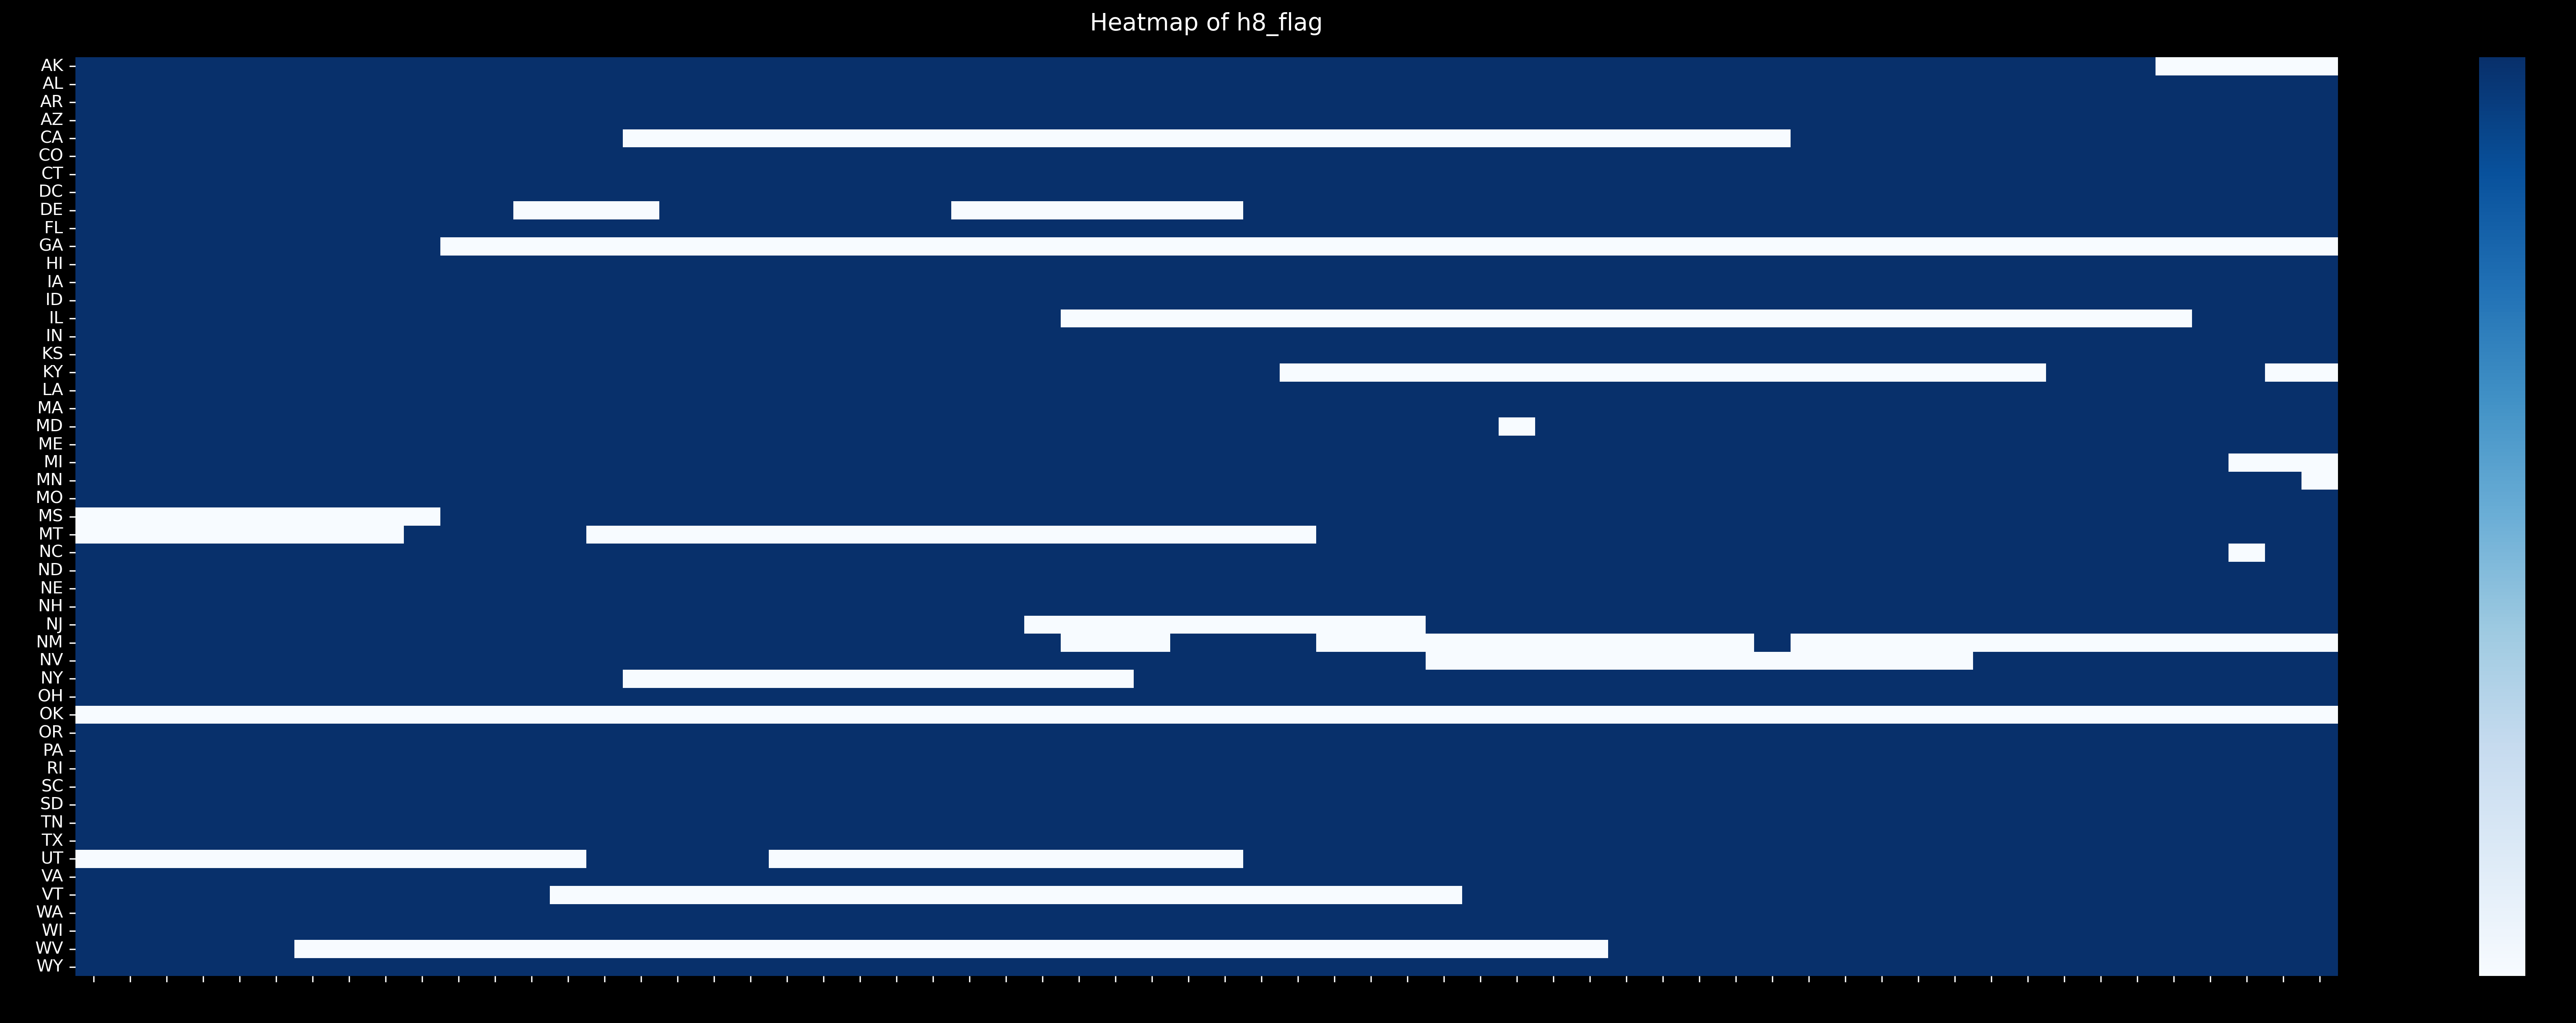

In [68]:
#covid.columns
args = ['c1_school closing', 'c1_flag', 'c2_workplace closing',
       'c2_flag', 'c3_cancel public events', 'c3_flag',
       'c4_restrictions on gatherings', 'c4_flag', 'c5_close public transport',
       'c5_flag', 'c6_stay at home requirements', 'c6_flag',
       'c7_restrictions on internal movement', 'c7_flag',
       'c8_international travel controls', 'e1_income support', 'e1_flag',
       'e2_debt/contract relief', 'h1_public information campaigns', 'h1_flag',
       'h2_testing policy', 'h3_contact tracing', 'h5_investment in vaccines',
       'h6_facial coverings', 'h6_flag', 'h7_vaccination policy', 'h7_flag',
       'h8_protection of elderly people', 'h8_flag']


indicator_heatmap(covid_state, args)

In [69]:
# remove the indicators that are not showing any sort of variability
def dropcols(covid):
    covid = covid.drop(columns = ['c8_international travel controls','h1_public information campaigns','h1_flag','h5_investment in vaccines'])
    return covid

covid = dropcols(covid)
covid_state = dropcols(covid_state)


In [70]:
# helper function: look at correlation heatmap

def corr_map(data):
    corr = data.corr()
    matrix = np.triu(corr)
    mpl.rcParams.update(mpl.rcParamsDefault)

    f, ax = plt.subplots(figsize=(30,12), dpi = 300, facecolor = 'black')
    heatmap = sns.heatmap(corr, annot=False, mask=matrix, cmap='Blues')   # BrBG color
    heatmap.set_title('Feature Correlation Heatmap', fontdict={'fontsize':14, 'color':'white'}, pad=16)
    heatmap.tick_params(axis = 'both', color = 'white', labelcolor = 'white')
    heatmap.set_facecolor('black')
    heatmap.set_xticklabels([])#heatmap.get_xmajorticklabels(), fontsize = 10)
    heatmap.set_yticklabels([])#heatmap.get_ymajorticklabels(), fontsize = 10)

    
    plt.show()

########################################################################

# automating the process of removing highly correlated variables
# returns a list of features that are correlated above the percentage fed into the function

def auto_corr(data, corr_percentage):
    corr_matrix = data.corr().abs() #get the correlation matrix with absolute values

    # select just the upper triangle of the correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) 
    #print(upper_tri) # view the columns

    # get columns with over 0.95 (95%) correlation

    #use list comprehension to get a list of ultra high correlated variables
    to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > corr_percentage)] 

    # print list of variables to drop from dataframe
    print('\n These are the variables that are correlated over %s:' % corr_percentage,to_drop)
    corrs = len(to_drop)
    print('\nThere are a total of %d variables to drop due to a correlation over %s' % (corrs, corr_percentage))
    return to_drop


In [71]:
#covid_state.info()

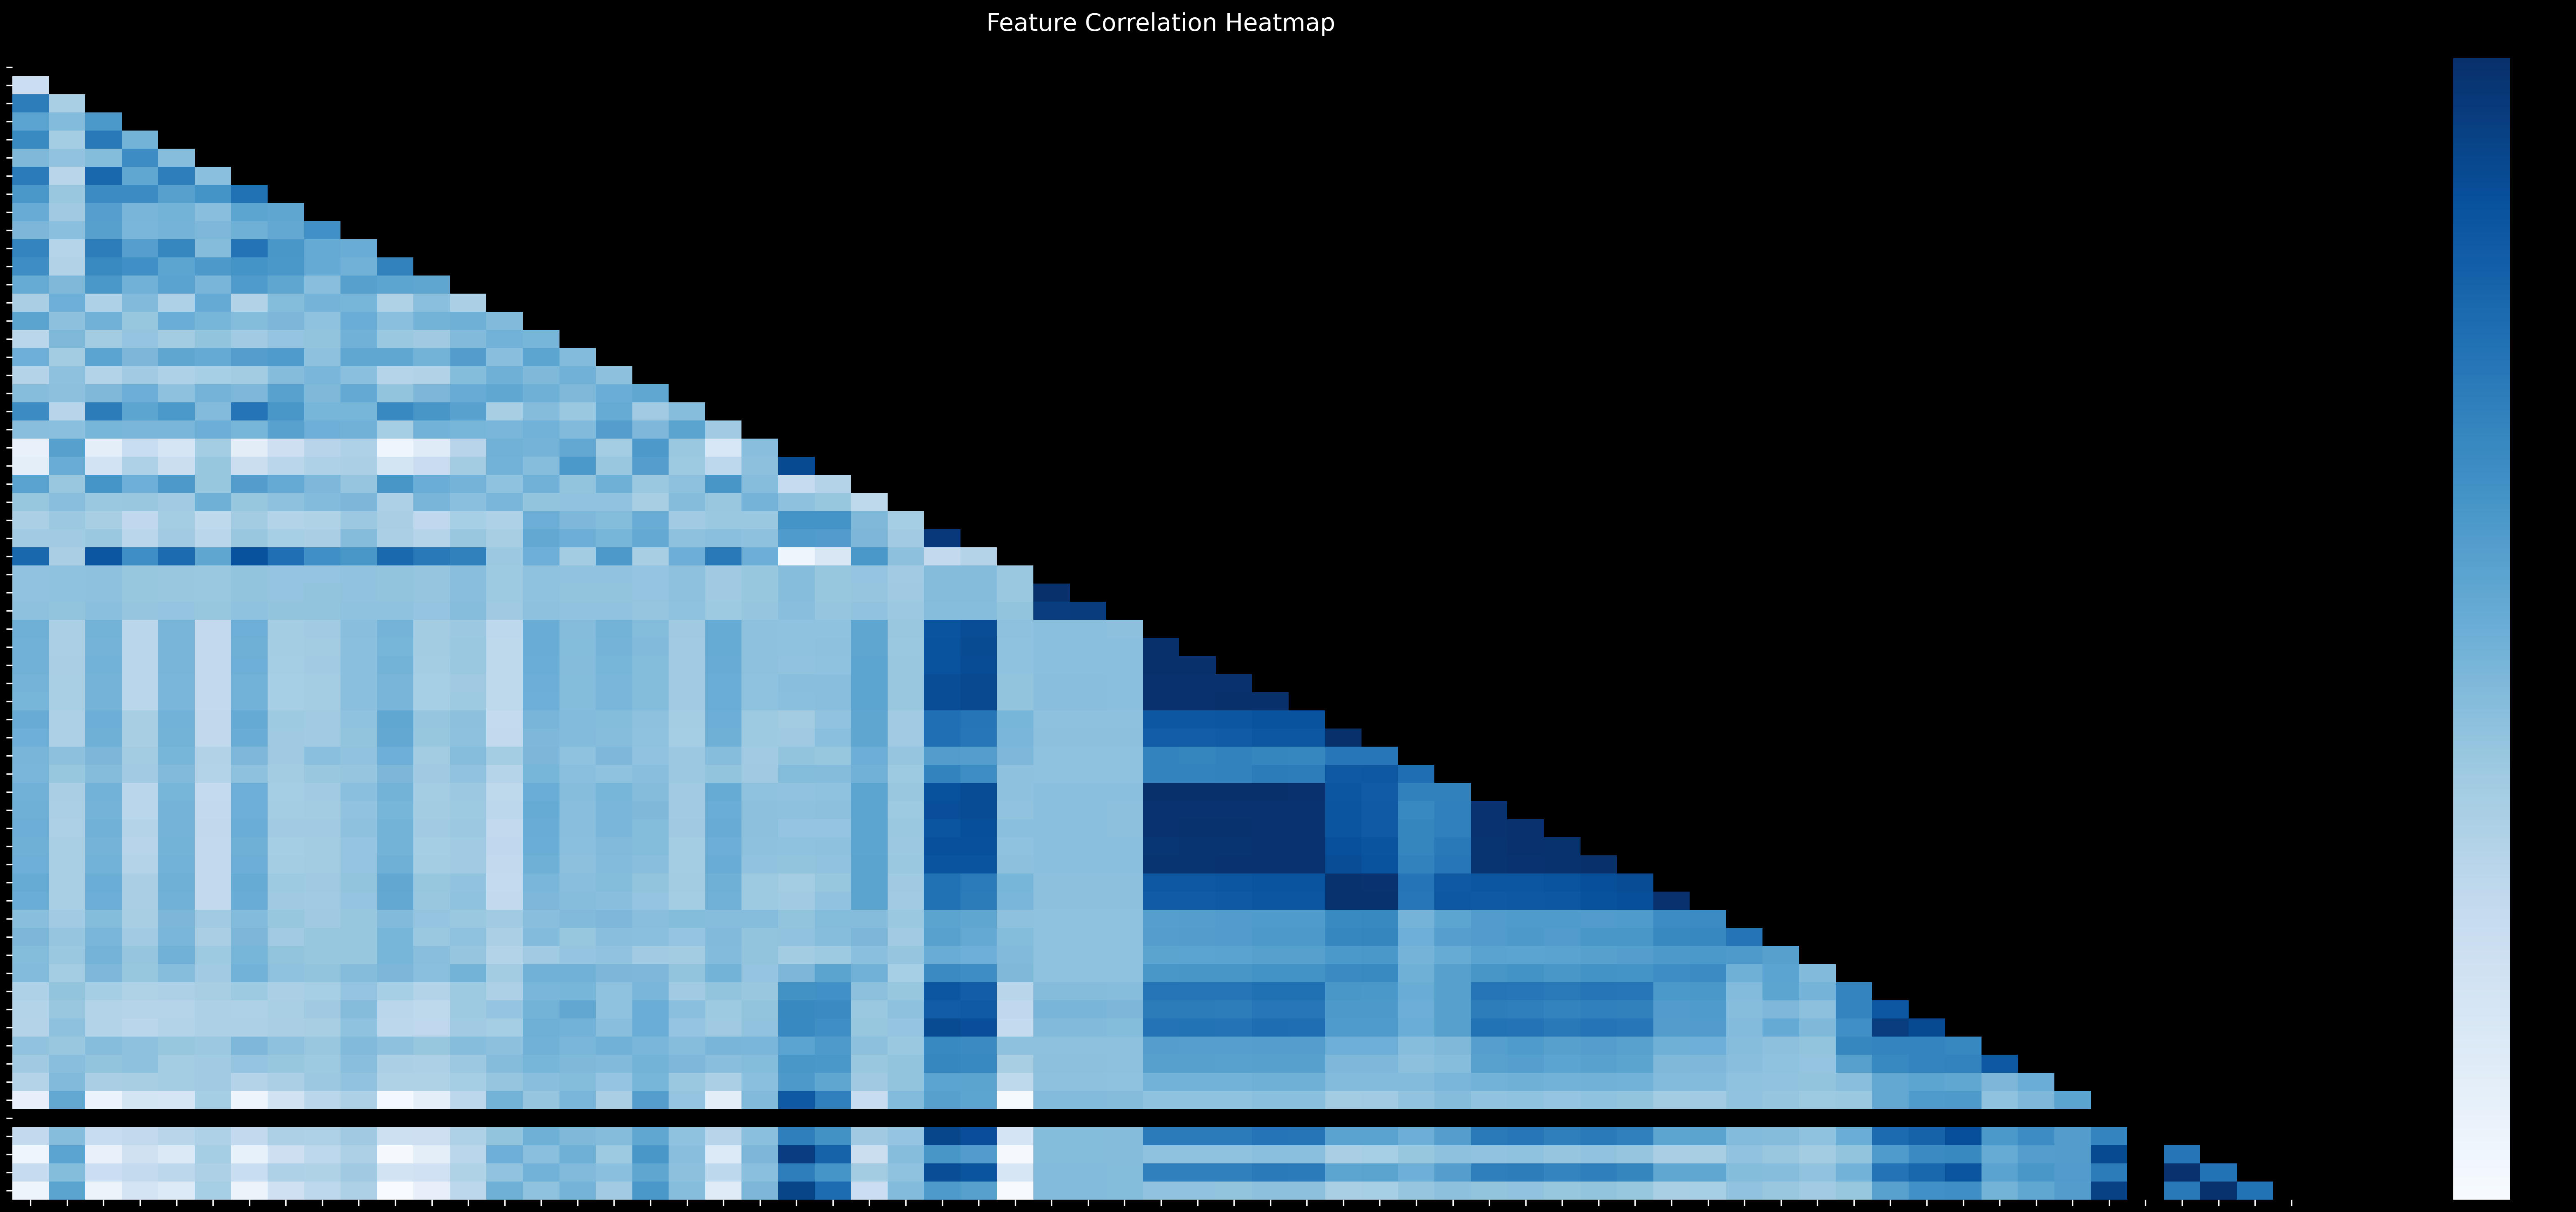

In [72]:
# Call correlation heatmap function

#corr_map(covid)
corr_map(covid_state)


In [73]:
auto_corr(covid_state, .9)


 These are the variables that are correlated over 0.9: ['confirmeddeaths', 'containmenthealthindexfordisplay', 'economicsupportindexfordisplay', 'all_adult_hospital_beds_7_day_avg', 'all_adult_hospital_inpatient_beds_7_day_avg', 'inpatient_beds_used_7_day_avg', 'all_adult_hospital_inpatient_bed_occupied_7_day_avg', 'total_adult_patients_hospitalized_confirmed_covid_7_day_avg', 'inpatient_beds_7_day_avg', 'total_icu_beds_7_day_avg', 'total_staffed_adult_icu_beds_7_day_avg', 'icu_beds_used_7_day_avg', 'staffed_adult_icu_bed_occupancy_7_day_avg', 'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg', 'staffed_icu_adult_patients_confirmed_covid_7_day_avg', 'total_personnel_covid_vaccinated_doses_all_7_day', 'administered_dose1_pop_pct', 'series_complete_yes', 'series_complete_pop_pct']

There are a total of 19 variables to drop due to a correlation over 0.9


['confirmeddeaths',
 'containmenthealthindexfordisplay',
 'economicsupportindexfordisplay',
 'all_adult_hospital_beds_7_day_avg',
 'all_adult_hospital_inpatient_beds_7_day_avg',
 'inpatient_beds_used_7_day_avg',
 'all_adult_hospital_inpatient_bed_occupied_7_day_avg',
 'total_adult_patients_hospitalized_confirmed_covid_7_day_avg',
 'inpatient_beds_7_day_avg',
 'total_icu_beds_7_day_avg',
 'total_staffed_adult_icu_beds_7_day_avg',
 'icu_beds_used_7_day_avg',
 'staffed_adult_icu_bed_occupancy_7_day_avg',
 'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg',
 'staffed_icu_adult_patients_confirmed_covid_7_day_avg',
 'total_personnel_covid_vaccinated_doses_all_7_day',
 'administered_dose1_pop_pct',
 'series_complete_yes',
 'series_complete_pop_pct']

In [74]:
#Selecting variables to keep instead
#Removed 'ConfirmedCases', 'ConfirmedDeaths' since they're from Oxford dataset
#Removed flu season stuff'total_patients_hospitalized_confirmed_influenza_7_day_avg','flu_season'
#Removed 'total_beds_7_day_avg' 

cols = ['state', 'Date',
               'C1_School closing', 'C1_Flag', 'C2_Workplace closing','C2_Flag','C3_Cancel public events', 'C3_Flag',
               'C4_Restrictions on gatherings','C4_Flag','C5_Close public transport','C5_Flag',
               'C6_Stay at home requirements','C6_Flag','C7_Restrictions on internal movement','C7_Flag',
               'E1_Income support','E1_Flag','E2_Debt/contract relief',
               'H2_Testing policy','H3_Contact tracing',
               'H6_Facial Coverings','H6_Flag','H7_Vaccination policy','H7_Flag',
               'H8_Protection of elderly people','H8_Flag',
               'StringencyIndexForDisplay','GovernmentResponseIndexForDisplay','EconomicSupportIndexForDisplay',
               'inpatient_beds_7_day_avg', 'inpatient_beds_used_7_day_avg',
               'total_adult_patients_hospitalized_confirmed_covid_7_day_avg',
               'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg',
               'total_personnel_covid_vaccinated_doses_none_7_day','pfizer_auth',
               'is_corrected','week', 'administered_dose1_recip', 'administered_dose1_pop_pct','series_complete_yes', 'series_complete_pop_pct']

cols = [x.lower() for x in cols]
#covid = covid[cols]
covid_state = covid_state[cols]
covid_state


state       date  c1_school closing  c1_flag  c2_workplace closing  \
0       AK 2020-07-10                3.0      1.0                   1.0   
1       AK 2020-07-17                3.0      1.0                   1.0   
2       AK 2020-07-24                3.0      0.0                   1.0   
3       AK 2020-07-31                3.0      0.0                   2.0   
4       AK 2020-08-07                3.0      0.0                   2.0   
...    ...        ...                ...      ...                   ...   
3157    WY 2021-08-13                0.0      0.0                   0.0   
3158    WY 2021-08-20                0.0      0.0                   0.0   
3159    WY 2021-08-27                0.0      0.0                   0.0   
3160    WY 2021-09-03                0.0      0.0                   0.0   
3161    WY 2021-09-10                0.0      0.0                   0.0   

      c2_flag  c3_cancel public events  c3_flag  \
0         1.0                      1.0      1.0   
1         1.0                      1.0      1.0   
2         0.0                      1.0      1.0   
3         0.0                      1.0      1.0   
4         0.0                      1.0      1.0   
...       ...                      ...      ...   
3157      0.0                      0.0      0.0   
3158      0.0                      0.0      0.0   
3159      0.0                      0.0      0.0   
3160      0.0                      0.0      0.0   
3161      0.0                      0.0      0.0   

      c4_restrictions on gatherings  c4_flag  ...  \
0                               2.0      1.0  ...   
1                               2.0      1.0  ...   
2                               3.0      0.0  ...   
3                               3.0      0.0  ...   
4                               3.0      0.0  ...   
...                             ...      ...  ...   
3157                            0.0      0.0  ...   
3158                            0.0      0.0  ...   
3159                            0.0      0.0  ...   
3160                            0.0      0.0  ...   
3161                            0.0      0.0  ...   

      total_adult_patients_hospitalized_confirmed_covid_7_day_avg  \
0                                             33.250000             
1                                              8.400000             
2                                             35.750000             
3                                             25.200000             
4                                             36.000000             
...                                                 ...             
3157                                         238.650000             
3158                                         264.100000             
3159                                         296.914286             
3160                                         385.885714             
3161                                         334.300000             

      total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg  \
0                                                   0.0                 
1                                                   0.0                 
2                                                   0.0                 
3                                                   0.0                 
4                                                   0.0                 
...                                                 ...                 
3157                                                0.0                 
3158                                                0.0                 
3159                                                0.0                 
3160                                                0.0                 
3161                                                0.0                 

      total_personnel_covid_vaccinated_doses_none_7_day  pfizer_auth  \
0                                                   0.0            0   
1   

In [75]:
corr_map(covid_state)

In [76]:
# call auto correlation fucnction

correlated_features = auto_corr(covid_state, 0.9)


 These are the variables that are correlated over 0.9: ['economicsupportindexfordisplay', 'inpatient_beds_used_7_day_avg', 'administered_dose1_pop_pct', 'series_complete_yes', 'series_complete_pop_pct']

There are a total of 5 variables to drop due to a correlation over 0.9


In [77]:
#covid = covid.drop(columns = correlated_features)


# for now, leaving this out to see how it affects the models
covid_state = covid_state.drop(columns = correlated_features)



In [78]:
list(covid_state.columns)


['state',
 'date',
 'c1_school closing',
 'c1_flag',
 'c2_workplace closing',
 'c2_flag',
 'c3_cancel public events',
 'c3_flag',
 'c4_restrictions on gatherings',
 'c4_flag',
 'c5_close public transport',
 'c5_flag',
 'c6_stay at home requirements',
 'c6_flag',
 'c7_restrictions on internal movement',
 'c7_flag',
 'e1_income support',
 'e1_flag',
 'e2_debt/contract relief',
 'h2_testing policy',
 'h3_contact tracing',
 'h6_facial coverings',
 'h6_flag',
 'h7_vaccination policy',
 'h7_flag',
 'h8_protection of elderly people',
 'h8_flag',
 'stringencyindexfordisplay',
 'governmentresponseindexfordisplay',
 'inpatient_beds_7_day_avg',
 'total_adult_patients_hospitalized_confirmed_covid_7_day_avg',
 'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg',
 'total_personnel_covid_vaccinated_doses_none_7_day',
 'pfizer_auth',
 'is_corrected',
 'week',
 'administered_dose1_recip']

---
### Graph to compare Cases and Deaths over time
--

In [79]:
# better explanation of why to switch from non-interactive to interactive matplotlib backend for next chart
# https://gist.github.com/CMCDragonkai/4e9464d9f32f5893d837f3de2c43daa4

import matplotlib.rcsetup as rcsetup

print(rcsetup.interactive_bk)
print(rcsetup.non_interactive_bk)
print(rcsetup.all_backends)

['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo']
['agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']


In [80]:
'''
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) # reset the style sheet that was set for the heatmap above

import matplotlib.dates as dates

fig, ax = plt.subplots(figsize=(12,5))

# ticks every 2 months
ticks_two_mons = dates.MonthLocator(interval = 2)
ax.xaxis.set_major_locator(ticks_two_mons)

# minor ticks in between dates
ax.xaxis.set_minor_locator(dates.MonthLocator())

# format date display
ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))


# plot 7-day average total inpatient beds
ax.set_xlabel('Dates')
ax.plot(covid.groupby(by='Date').sum()['inpatient_beds_7_day_avg'], color = 'black', label = 'Total Inpatient Beds')
ax.tick_params(axis='y', color = 'black')

#plot 7-day inpatient bed occupancy
ax.plot(covid.groupby(by='Date').sum()['inpatient_beds_used_7_day_avg'], color = 'blue', label = 'Occupied Inpatient Beds')
ax.tick_params(axis='y', color = 'black')

#plot 7-day adult inpatients with covid
ax.plot(covid.groupby(by='Date').sum()['total_adult_patients_hospitalized_confirmed_covid_7_day_avg'], color = 'red', label = 'Confirmed Covid Cases - Adults')
ax.tick_params(axis='y', color = 'black')

#plot 7-day pediatric inpatients with covid
ax.plot(covid.groupby(by='Date').sum()['total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg'], color = 'green', label = 'Confirmed Covid Cases - Pediatric')
ax.tick_params(axis='y', color = 'black')

#plot 7-day total flu cases
ax.plot(covid.groupby(by='Date').sum()['total_patients_hospitalized_confirmed_influenza_7_day_avg'], color = 'gray', label = 'All Flu Cases')
ax.tick_params(axis='y', color = 'black')

#plot 7-day total Confirmed cases from Oxford data set
#ax.plot(covid.groupby(by='Date').sum()['ConfirmedCases'], color = 'orange', label = 'Oxford Confirmed Cases')
#ax.tick_params(axis='y', color = 'orange')


#ax.set_title('Total Beds 7-Day Average by Date in the USA 01-01-24 thru 05-28-21')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
mpl.rcParams.update({'font.size': 14})

plt.legend()
plt.show()
'''
print('')

In [81]:
'''
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault) # reset the style sheet that was set for the heatmap above

import matplotlib.dates as dates

fig, ax = plt.subplots(figsize=(12,5))

# ticks every 2 months
ticks_two_mons = dates.MonthLocator(interval = 2)
ax.xaxis.set_major_locator(ticks_two_mons)

# minor ticks in between dates
ax.xaxis.set_minor_locator(dates.MonthLocator())

# format date display
ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))


# plot 7-day average total inpatient beds
ax.set_xlabel('Dates')
ax.plot(covid.groupby(by='Date').sum()['inpatient_beds_7_day_avg'], color = 'black', label = 'Total Inpatient Beds')
ax.tick_params(axis='y', color = 'black')

#plot 7-day inpatient bed occupancy
ax.plot(covid.groupby(by='Date').sum()['inpatient_beds_used_7_day_avg'], color = 'blue', label = 'Occupied Inpatient Beds')
ax.tick_params(axis='y', color = 'black')

#plot 7-day adult inpatients with covid
ax.plot(covid.groupby(by='Date').sum()['total_adult_patients_hospitalized_confirmed_covid_7_day_avg'], color = 'red', label = 'Confirmed Covid Cases - Adults')
ax.tick_params(axis='y', color = 'black')

#plot 7-day pediatric inpatients with covid
ax.plot(covid.groupby(by='Date').sum()['total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg'], color = 'green', label = 'Confirmed Covid Cases - Pediatric')
ax.tick_params(axis='y', color = 'black')

#plot 7-day total flu cases
ax.plot(covid.groupby(by='Date').sum()['total_patients_hospitalized_confirmed_influenza_7_day_avg'], color = 'gray', label = 'All Flu Cases')
ax.tick_params(axis='y', color = 'black')

#plot 7-day total Confirmed cases from Oxford data set
ax.plot(covid.groupby(by='Date').sum()['ConfirmedCases'], color = 'orange', label = 'Oxford Confirmed Cases')
ax.tick_params(axis='y', color = 'orange')


#ax.set_title('Total Beds 7-Day Average by Date in the USA 01-01-24 thru 05-28-21')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
mpl.rcParams.update({'font.size': 14})

plt.legend()
plt.show()
'''
print('')

In [82]:
# get an idea of how the cases and deaths align over time when scaled
'''
mpl.use('Qt5Agg')  # switch to an interactive backend, the default is agg and that is not interactive
mpl.rcParams.update(mpl.rcParamsDefault) # reset the style sheet that was set for the heatmap above

import matplotlib.pyplot as plt  # re-import pyplot

#mpl.rcParams.update(mpl.rcParamsDefault) # reset the style sheet that was set for the heatmap above
fig, ax1 = plt.subplots(figsize=(12,5))

# plot conf_cases
ax1.set_xlabel('Dates')
ax1.set_ylabel('Confirmed Cases')
ax1.plot(oxford.groupby(by='Date').sum()['ConfirmedCases'], '.-', color = 'black', label = 'Conf_Cases')
ax1.tick_params(axis='y', labelcolor = 'black')
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# add additional axes to same plot
ax2 = ax1.twinx()

# plot conf_deaths
ax2.set_ylabel('Confirmed Deaths')
ax2.plot(oxford.groupby(by='Date').sum()['ConfirmedDeaths'], '--', color = 'black', label = 'Conf_Deaths')
ax2.tick_params(axis='y', labelcolor='black')
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))



# prevent any offsets
fig.tight_layout()

# get plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')
ax2.set_title('Explore the Similarity in Tranjectories of Cases and Deaths')
ax2.legend(lines + lines2, labels + labels2, loc=0)

formatter = mpl.dates.DateFormatter("%b %y") # format date into 3-letter month using %b, 2 digit year using %y  (%Y is the 4-digit year)
ax2.xaxis.set_major_formatter(formatter)  # format the date on the xaxis

plt.show()
'''
print('')

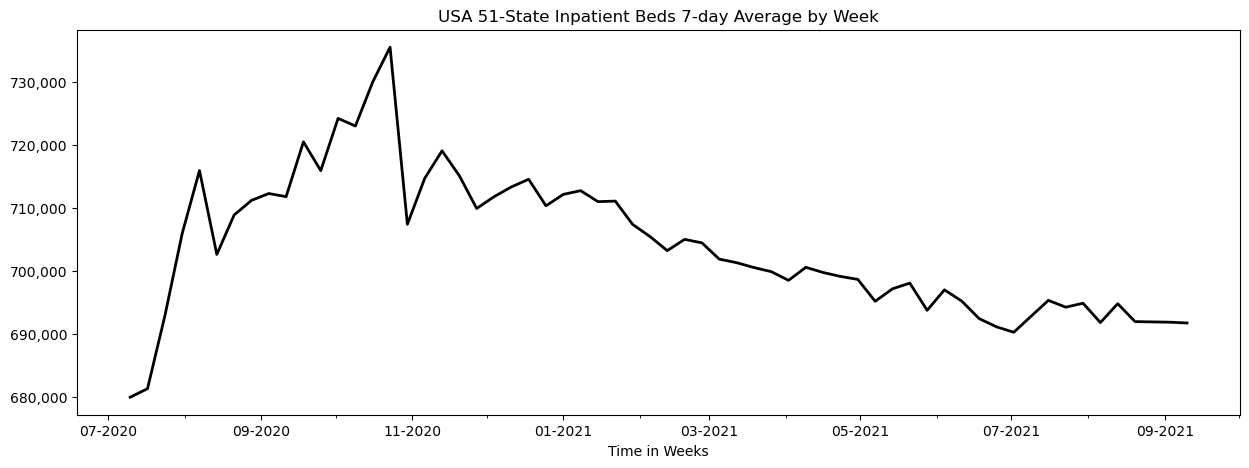

In [83]:
mpl.use('Qt5Agg')  # switch to an interactive backend, the default is agg and that is not interactive
mpl.rcParams.update(mpl.rcParamsDefault) # reset the style sheet that was set for the heatmap above

import matplotlib.pyplot as plt  # re-import pyplot

import matplotlib.dates as dates

def nat_inpat_beds(data, title_t):
    data = data[['date', 'inpatient_beds_7_day_avg']]
    data = data.groupby(by = 'date').sum()
    data.reset_index(inplace = True, drop = False)
    
    fig, ax = plt.subplots(figsize = (15,5))

    ax.plot(data.date, data.inpatient_beds_7_day_avg, label = "line 1", linestyle="-", color = 'black', linewidth=2)

    # ticks every 2 months
    ticks_two_mons = dates.MonthLocator(interval = 2)
    ax.xaxis.set_major_locator(ticks_two_mons)
    ax.set_title(title_t)
    ax.set_xlabel('Time in Weeks')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    # minor ticks in between dates
    ax.xaxis.set_minor_locator(dates.MonthLocator())

    # format date display
    ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))

    plt.show()
    
#nat_inpat_beds(covid, 'USA National Inpatient Beds 7-day Average by Week')
nat_inpat_beds(covid_state, 'USA 51-State Inpatient Beds 7-day Average by Week')

In [84]:
#covid.plot('date', 'inpatient_beds_7_day_avg', label = "line 1", linestyle="-")
covid_state

state       date  c1_school closing  c1_flag  c2_workplace closing  \
0       AK 2020-07-10                3.0      1.0                   1.0   
1       AK 2020-07-17                3.0      1.0                   1.0   
2       AK 2020-07-24                3.0      0.0                   1.0   
3       AK 2020-07-31                3.0      0.0                   2.0   
4       AK 2020-08-07                3.0      0.0                   2.0   
...    ...        ...                ...      ...                   ...   
3157    WY 2021-08-13                0.0      0.0                   0.0   
3158    WY 2021-08-20                0.0      0.0                   0.0   
3159    WY 2021-08-27                0.0      0.0                   0.0   
3160    WY 2021-09-03                0.0      0.0                   0.0   
3161    WY 2021-09-10                0.0      0.0                   0.0   

      c2_flag  c3_cancel public events  c3_flag  \
0         1.0                      1.0      1.0   
1         1.0                      1.0      1.0   
2         0.0                      1.0      1.0   
3         0.0                      1.0      1.0   
4         0.0                      1.0      1.0   
...       ...                      ...      ...   
3157      0.0                      0.0      0.0   
3158      0.0                      0.0      0.0   
3159      0.0                      0.0      0.0   
3160      0.0                      0.0      0.0   
3161      0.0                      0.0      0.0   

      c4_restrictions on gatherings  c4_flag  ...  stringencyindexfordisplay  \
0                               2.0      1.0  ...                  56.218571   
1                               2.0      1.0  ...                  60.190000   
2                               3.0      0.0  ...                  57.870000   
3                               3.0      0.0  ...                  58.927143   
4                               3.0      0.0  ...                  59.720000   
...                             ...      ...  ...                        ...   
3157                            0.0      0.0  ...                  34.918571   
3158                            0.0      0.0  ...                  33.330000   
3159                            0.0      0.0  ...                  33.330000   
3160                            0.0      0.0  ...                  33.330000   
3161                            0.0      0.0  ...                  33.330000   

      governmentresponseindexfordisplay  inpatient_beds_7_day_avg  \
0                             57.924286                   1491.15   
1                             60.160000                   1426.85   
2                             58.850000                   1612.70   
3                             56.324286                   1291.00   
4                             56.770000                   1417.00   
...                                 ...                       ...   
3157                          46.724286                   1427.10   
3158                          45.384286                   1429.10   
3159                          42.710000                   1431.70   
3160                          40.474286                   1432.00   
3161                          39.730000                   1427.40   

      total_adult_patients_hospitalized_confirmed_covid_7_day_avg  \
0                                             33.250000             
1                                              8.400000             
2                                             35.750000             
3                                             25.200000             
4                                             36.000000             
...                                                 ...             
3157                                         238.650000             
3158                                         264.100000             
3159                                         296.914286             
3160       

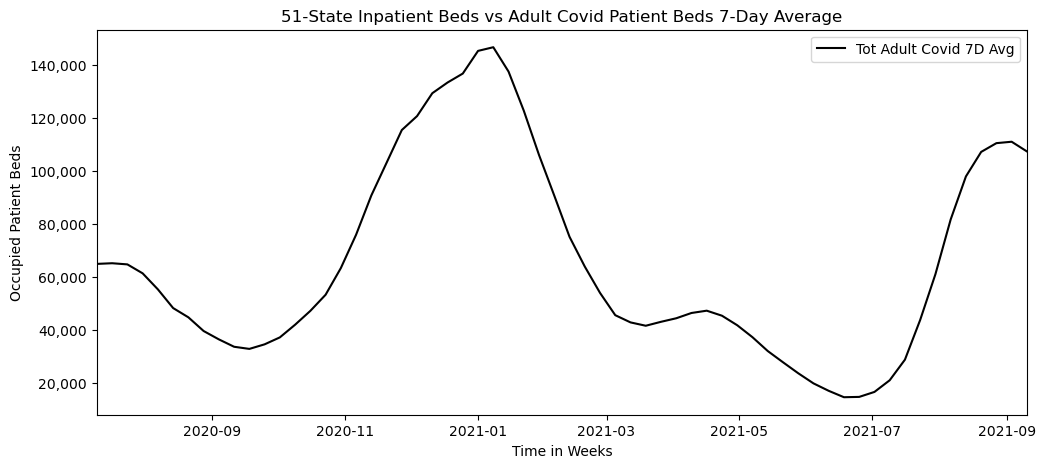

In [85]:

def inpat_vs_conf_covid2(data, title_t):
    data = data[['date', 'total_adult_patients_hospitalized_confirmed_covid_7_day_avg']]
    data = data.groupby(by = 'date').sum()
    data.reset_index(inplace = True, drop = False)
    
    labels = data['date']
    covid_bed = data['total_adult_patients_hospitalized_confirmed_covid_7_day_avg']
    
    fig, ax = plt.subplots(figsize=(12,5))
    # plot conf_cases
    ax.set_title(title_t)
    ax.set_xlabel('Time in Weeks')
    ax.set_ylabel('Occupied Patient Beds')
    ax.plot(labels, covid_bed, label = "Tot Adult Covid 7D Avg", color = 'black')#, bottom = covid_bed)
    ax.tick_params(axis='y', labelcolor = 'black')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.legend()
    ax.set_facecolor('white')
    ax.set_xlim(left = np.min(labels), right = np.max(labels))
    
    plt.show()
    
inpat_vs_conf_covid2(covid_state, '51-State Inpatient Beds vs Adult Covid Patient Beds 7-Day Average')


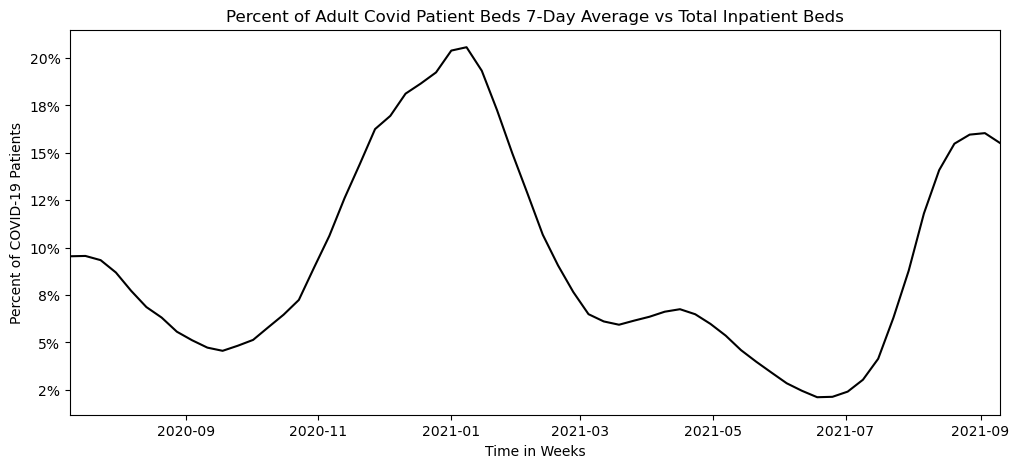

In [86]:
#New plot
#covid.plot(x="Date", y=["inpatient_beds_7_day_avg", "total_adult_patients_hospitalized_confirmed_covid_7_day_avg"],
#        kind="bar", figsize=(11, 11))


#mpl.rcParams.update(mpl.rcParamsDefault) # reset the style sheet that was set for the heatmap above
import matplotlib.dates as mdates
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

def inpat_vs_conf_covid(data, title_t):
    data = data[['date','inpatient_beds_7_day_avg','total_adult_patients_hospitalized_confirmed_covid_7_day_avg']]
    data = data.groupby(by = ['date']).sum()
    data.reset_index(inplace = True, drop = False)
    data = data.sort_values(by = ['date'], ignore_index = True)
    
    labels = data['date']
    pat_bed = data['inpatient_beds_7_day_avg']
    covid_bed = data['total_adult_patients_hospitalized_confirmed_covid_7_day_avg']
    perc = covid_bed/ pat_bed 
    width = 1
    
    fig, ax = plt.subplots(figsize=(12,5))
    # plot conf_cases
    
    #l1, = ax.plot(labels, pat_bed, color = 'black')
    #l2, = ax.plot(labels, covid_bed, '-.',  color = 'black')#, bottom = covid_bed)
    ax.plot(labels, perc, color = 'black')
    ax.tick_params(axis='y', labelcolor = 'black')
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
    
    #ax.legend((l1,l2), ('Inpatient Beds 7D Avg','Tot Adult Covid 7D Avg'), loc = 'center right', fontsize = 'large', facecolor = 'white')
    ax.set_facecolor('white')
    ax.set_xlim(left = np.min(labels), right = np.max(labels))
    ax.set_title(title_t)
    ax.set_xlabel('Time in Weeks')
    ax.set_ylabel('Percent of COVID-19 Patients')
    plt.show()
    

#inpat_vs_conf_covid(covid, 'National Inpatient Beds vs Adult Covid Patient Beds 7-Day Average')
inpat_vs_conf_covid(covid_state, 'Percent of Adult Covid Patient Beds 7-Day Average vs Total Inpatient Beds')


In [87]:
#plot covid hospitalizations to total number of covid immunizations

def vaccine_vs_conf_covid(data, title_t):
    data = data[['date','inpatient_beds_7_day_avg','total_adult_patients_hospitalized_confirmed_covid_7_day_avg', 'administered_dose1_recip']]
    data = data.groupby(by = ['date']).sum()
    data.reset_index(inplace = True, drop = False)
    data = data.sort_values(by = ['date'], ignore_index = True)
    
    labels = data['date']
    dose = np.log(data['administered_dose1_recip'])
    covid_bed = np.log(data['total_adult_patients_hospitalized_confirmed_covid_7_day_avg'])
   
    
    fig, ax = plt.subplots(figsize=(12,5))
    # plot conf_cases
    
    l1, = ax.plot(labels, dose, color = 'black')
    l2, = ax.plot(labels, covid_bed, '-.',  color = 'black')#, bottom = covid_bed)
    ax.tick_params(axis='y', labelcolor = 'black')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
    
    ax.legend((l1,l2), ('Admin Dose1 Recipt','Tot Adult Covid 7D Avg'), loc = 'center right', fontsize = 'large', facecolor = 'white')
    ax.set_facecolor('white')
    ax.set_xlim(left = np.min(labels), right = np.max(labels))
    ax.set_title(title_t)
    ax.set_xlabel('Time in Weeks')
    ax.set_ylabel('Percent of COVID-19 Patients')
    plt.show()
    

#inpat_vs_conf_covid(covid, 'National Inpatient Beds vs Adult Covid Patient Beds 7-Day Average')
vaccine_vs_conf_covid(covid_state, 'Ln Vaccine Dose vs Ln Adult Covid Patient Beds 7-Day Average')

C:\Users\justi\anaconda3\envs\capstone\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [88]:
covid_state.columns

Index(['state', 'date', 'c1_school closing', 'c1_flag', 'c2_workplace closing',
       'c2_flag', 'c3_cancel public events', 'c3_flag',
       'c4_restrictions on gatherings', 'c4_flag', 'c5_close public transport',
       'c5_flag', 'c6_stay at home requirements', 'c6_flag',
       'c7_restrictions on internal movement', 'c7_flag', 'e1_income support',
       'e1_flag', 'e2_debt/contract relief', 'h2_testing policy',
       'h3_contact tracing', 'h6_facial coverings', 'h6_flag',
       'h7_vaccination policy', 'h7_flag', 'h8_protection of elderly people',
       'h8_flag', 'stringencyindexfordisplay',
       'governmentresponseindexfordisplay', 'inpatient_beds_7_day_avg',
       'total_adult_patients_hospitalized_confirmed_covid_7_day_avg',
       'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg',
       'total_personnel_covid_vaccinated_doses_none_7_day', 'pfizer_auth',
       'is_corrected', 'week', 'administered_dose1_recip'],
      dtype='object')

In [89]:
%%time

from pandas_profiling import ProfileReport

profile = ProfileReport(covid_state, minimal=True, title='COVID Dataset Profiling Report for Capstone A')


Wall time: 1.15 s


In [90]:
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


In [91]:
np.min(covid_state.date), np.max(covid_state.date)

(Timestamp('2020-07-10 00:00:00'), Timestamp('2021-09-10 00:00:00'))

In [92]:
#profile.to_file('covid_dataset_profile.html')

In [93]:
# make a backup copy of the covid dataframe for EDA later on while columns that may've been dropped later on are still in tact for post processing

eda = copy.deepcopy(covid_state)

---
# <font color='blue'> Model Building and Evaluation </font>
## <font color='blue'>Data Prep</font>

In [94]:
# use the rest of the datetime data because we can't use datetime data in the regressors
#natmodel = copy.deepcopy(covid)
stmodel = copy.deepcopy(covid_state)




In [95]:
stmodel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3162 entries, 0 to 3161
Data columns (total 37 columns):
 #   Column                                                           Non-Null Count  Dtype         
---  ------                                                           --------------  -----         
 0   state                                                            3162 non-null   object        
 1   date                                                             3162 non-null   datetime64[ns]
 2   c1_school closing                                                3162 non-null   float64       
 3   c1_flag                                                          3162 non-null   float64       
 4   c2_workplace closing                                             3162 non-null   float64       
 5   c2_flag                                                          3162 non-null   float64       
 6   c3_cancel public events                                          3162 non-null  

In [96]:
# break up the dataset
stmodel.sort_values(['date', 'state'], inplace=True, ignore_index=True)
TARGET = stmodel.total_adult_patients_hospitalized_confirmed_covid_7_day_avg
DATA = stmodel.drop(columns = 'total_adult_patients_hospitalized_confirmed_covid_7_day_avg')
#DATA = DATA.drop(columns = ['total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg'])
DATA.columns
#DATA.info()

Index(['state', 'date', 'c1_school closing', 'c1_flag', 'c2_workplace closing',
       'c2_flag', 'c3_cancel public events', 'c3_flag',
       'c4_restrictions on gatherings', 'c4_flag', 'c5_close public transport',
       'c5_flag', 'c6_stay at home requirements', 'c6_flag',
       'c7_restrictions on internal movement', 'c7_flag', 'e1_income support',
       'e1_flag', 'e2_debt/contract relief', 'h2_testing policy',
       'h3_contact tracing', 'h6_facial coverings', 'h6_flag',
       'h7_vaccination policy', 'h7_flag', 'h8_protection of elderly people',
       'h8_flag', 'stringencyindexfordisplay',
       'governmentresponseindexfordisplay', 'inpatient_beds_7_day_avg',
       'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg',
       'total_personnel_covid_vaccinated_doses_none_7_day', 'pfizer_auth',
       'is_corrected', 'week', 'administered_dose1_recip'],
      dtype='object')

In [97]:
TARGET

0         33.250
1       1630.000
2        716.250
3       4044.050
4       7447.350
          ...   
3157      81.625
3158    2121.700
3159    1730.650
3160    1144.300
3161     334.300
Name: total_adult_patients_hospitalized_confirmed_covid_7_day_avg, Length: 3162, dtype: float64

In [98]:
# making sure we aren't working with copies and only original df's
bool(DATA._is_copy), bool(TARGET._is_copy)

(False, False)

In [99]:
#cat = np.array(DATA.iloc[:,0])
#np.reshape(cat, (-1,1))
#len(DATA), DATA.state.tail(12), DATA.state.())
DATA.iloc[:,[0,1]]

state       date
0       AK 2020-07-10
1       AL 2020-07-10
2       AR 2020-07-10
3       AZ 2020-07-10
4       CA 2020-07-10
...    ...        ...
3157    VT 2021-09-10
3158    WA 2021-09-10
3159    WI 2021-09-10
3160    WV 2021-09-10
3161    WY 2021-09-10

[3162 rows x 2 columns]

In [100]:
# Train Test Split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
#from sklearn.model_selection import train_test_split  # no longer neede because we are working with time series data
def traintestsplit(DATA, TARGET, split_perc):
    
    train = round(len(DATA) * split_perc)
    test = len(DATA) - train
    
    # split the data
    x_train = DATA.head(train)
    x_test = DATA.tail(test)
    y_train = TARGET.head(train)
    y_test = TARGET.tail(test)

    # avoid setting off error warnings
    x_train = copy.deepcopy(x_train)
    x_test = copy.deepcopy(x_test)

    # numerical columns
    x_train = copy.deepcopy(x_train.iloc[:, 2:])
    x_test = copy.deepcopy(x_test.iloc[:, 2:])


    # standardscaler input variables
    standardscaler = StandardScaler()
    standardscaler.fit(x_train)
    x_train = standardscaler.transform(x_train)
    x_test = standardscaler.transform(x_test)

    return x_train, x_test, y_train, y_test
    
x_train, x_test, y_train, y_test = traintestsplit(DATA, TARGET, .75)



In [101]:
np.isnan(x_train).sum(), np.isnan(x_test).sum(), np.isnan(y_train).sum(), np.isnan(y_test).sum(), DATA.isna().sum().sum()

(0, 0, 0, 0, 0)

In [102]:
np.where(covid_state.isna())

(array([], dtype=int64), array([], dtype=int64))

In [103]:
x_train.shape, x_test.shape


((2372, 34), (790, 34))

---
# <font color='blue'> Modeling </font>
## <font color='blue'> Linear Regression </font>



In [104]:
%%time 
# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error



linear_reg = LinearRegression()
linear_reg.fit(x_train, y_train)
linear_preds = linear_reg.predict(x_test)
linear_reg.get_params()
r2_score = linear_reg.score(x_test, y_test) # R2 score
cv_score = cross_val_score(linear_reg, x_test, y_test, cv=5, scoring = 'r2')
print('R-square score: %s' % r2_score)
print('cv_score: %s' % cv_score)


R-square score: 0.6853772845624209
cv_score: [-1.00777264e+00  3.16843304e-01  8.94041561e-01  9.17183755e-01
 -2.25741506e+14]
Wall time: 104 ms


In [105]:
#linear_reg.coef_.tolist()
linear_reg.intercept_

1340.061043523649

In [106]:

d = {'features': list(DATA.iloc[:,2:].columns), 'coef': linear_reg.coef_}
importance = pd.DataFrame(data=d)

# return abs value of coef's
importance['abs_coef'] = abs(importance.coef)


# rank coef based on absolute value
importance['rank'] = importance['abs_coef'].rank(axis = 0, method = 'average', ascending = False, numeric_only = True)
#importance

# view the ranking of the feautes by abs value of coef
importance = importance[['features','coef','rank']].sort_values(by = ['rank'])

print(importance)

                                             features         coef  rank
27                           inpatient_beds_7_day_avg  1386.067127   1.0
28  total_pediatric_patients_hospitalized_confirme...   760.062281   2.0
22                                            h7_flag   549.443974   3.0
33                           administered_dose1_recip  -459.747645   4.0
21                              h7_vaccination policy  -338.629312   5.0
1                                             c1_flag  -134.789720   6.0
25                          stringencyindexfordisplay    92.151309   7.0
8                           c5_close public transport   -90.062192   8.0
31                                       is_corrected    71.235878   9.0
19                                h6_facial coverings   -67.365243  10.0
24                                            h8_flag   -60.903684  11.0
16                            e2_debt/contract relief   -58.490848  12.0
17                                  h2_testing poli

In [107]:
n_linear_feats = len(importance)

In [186]:
#Plot the model's feature importances
#import matplotlib.pyplot as plt

def feat_plot(weights, model, top):
    weights = weights[::-1]
    %matplotlib inline
    fig, ax = plt.subplots(figsize = (10,20))
    plt.rcParams['axes.facecolor'] = 'white'
    plt.style.use('ggplot')
    ax.barh(weights.features[:top],weights.weights[:top], color='blue')
    ax.set_title(f"Feature importance for the model {model}" )
    ax.set_ylabel("Feature Importance", size=14)
    ax.set_xlabel("Feature Names", size=14)
    ax.set_facecolor('white')
    
    ax.grid(False)
    plt.show()

In [187]:
weights = pd.DataFrame(data = importance['coef'].values, index = importance['features'], columns=['weights'])
weights.reset_index(inplace=True,drop=False)

feat_plot(weights, "linearRegression", 100)

---
## <font color='blue'> RandomForestRegressor </font>


In [110]:
from sklearn.ensemble import RandomForestRegressor

# params = {"criterion": "gini", "min_samples_split": 2, }

rf_reg = RandomForestRegressor(random_state = 42, n_jobs = -1)
rf_reg.fit(x_train, y_train)
rf_base_preds = rf_reg.predict(x_test)

rf_reg.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [111]:
rf_reg.score(x_test, y_test)

0.8481301695522538

In [146]:
def model_weights(model, DATA):
    weights = model.feature_importances_
    wt = pd.DataFrame(data=[list(DATA.iloc[:,2:].columns),weights*100]).T
    wt.columns = ['features','weights']
    wt['rank'] = wt['weights'].rank(ascending=False)
    wt = wt.sort_values('weights', ascending=False)
    print(wt)
    return wt

weights = model_weights(rf_reg, DATA)


                                             features    weights  rank
27                           inpatient_beds_7_day_avg   57.03212   1.0
28  total_pediatric_patients_hospitalized_confirme...  28.351176   2.0
33                           administered_dose1_recip   2.492954   3.0
26                  governmentresponseindexfordisplay   1.385188   4.0
25                          stringencyindexfordisplay   1.326507   5.0
10                       c6_stay at home requirements   1.028199   6.0
0                                   c1_school closing   0.843743   7.0
22                                            h7_flag   0.720646   8.0
17                                  h2_testing policy   0.627303   9.0
24                                            h8_flag   0.611632  10.0
6                       c4_restrictions on gatherings   0.608995  11.0
29  total_personnel_covid_vaccinated_doses_none_7_day   0.553963  12.0
21                              h7_vaccination policy   0.528922  13.0
8     

In [147]:
weights.weights.sum()

100.00000000000004

In [183]:
wts = pd.DataFrame(data = importance['coef'].values, index = importance['features'], columns=['weights'])
wts.reset_index(inplace=True,drop=False)

feat_plot(wts, "RandomForestRegressor", 100)

---
## <font color='blue'> Custom Grid Search by Justin Ehly </font>

In [115]:
'''
Custom Grid Search by Justin Ehly
'''
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import itertools
import collections

# build a list of classifiers/ params
regs = [
  { # only classifier
  'name': 'RandomForestRegressor()',
  'reg':RandomForestRegressor(),
  'params':{
    'n_estimators':[100,200,500],
    'criterion': ['squared_error','absolute_error','poisson'],
    'max_depth':[None,2,5,10,50,100],
    'min_samples_leaf':[1,2,3,4,5],
    'bootstrap':[True, False],
    'max_features':['auto','sqrt','log2'],
    'random_state':[42],
    'n_jobs': [-1]
  }}
]
########################################################
# build parameter grid
def paramgrid(regs):
    param_grid = {}
    for i in range(len(regs)): # iterate over each classifier and it's parameters to create unique combinations of all the parameters
        keys, values = zip(*regs[i]['params'].items())
        perm_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
        param_grid[i] = {
            'name': regs[i]['name'],
            'reg': regs[i]['reg'],
            'params':perm_dicts}
    return param_grid


##########################################################
# Modeling
def run(name, a_reg, x_train, y_train, x_test, y_test, reg_hyper):
  regr = a_reg
  regr = regr.set_params(**reg_hyper) # unpack parameters into reg is they exist
  regr.fit(x_train, y_train)
  regr.predict(x_test)
  results= {
        'name': name,
        'reg': regr,
        'params': regr.get_params(),  
        'score':  regr.score(x_test,y_test)}

  return results


##########################################################
# iterate over the parameter grid to call each model and it's parameters
def grid_search(param_grid):
    results = {}
    count = 0
    for i, key in enumerate(param_grid): # iterate over the classifiers
        for params in param_grid[key]['params']: # iterate over each combination of parameters for the classifier
            
            #try:
            results[count] = run(param_grid[key]['name'], param_grid[key]['reg'], x_train, y_train, x_test, y_test, params)
            count += 1
            #except ValueError:
            #    results [count] = {
            #        'name': param_grid[i]['name'],
            #        'reg': param_grid[i]['reg'],
            #        'params': params,
            #        'score': 0
            #    }
            #    count += 1
    print('\n')
    return results


##########################################################
# call the grid search
#param_grid = paramgrid(regs)

# check the number of combinations per classifier
#for i, key in enumerate(param_grid):
#    print('%s has %s parameter combinations' % (param_grid[key]['name'], len(param_grid[key]['params'])))

##########################################################
# run the grid search
#results = grid_search(param_grid)




In [116]:
# grab top 10 performing models
#results_ranked = collections.OrderedDict(sorted(results.items(), key=lambda x: x[1]['score'], reverse=True))
#top10_mods = list(results_ranked.items())[0:10]

# print top 10 models
#for i, mod in enumerate(top10_mods):
#    print(mod[1]['name'], mod[1]['score']) #, mod[1]['avg_precision'], mod[1]['avg_recall'] )

In [117]:
#top10_mods[0]

In [118]:


##########################################################
import json, pickle


# export
#with open('ehly_top_classifier.pickle', 'wb') as outfile:
#    pickle.dump(top10_mods[0], outfile)


#top_reg = dict(list(results_ranked.items())[0][1])
#top_reg.pop('reg')
#top_reg
#with open('ehly_top_clf_params_metrics.txt', 'w') as outfile:
#    json.dump(top_reg, outfile)

# import
with open('ehly_top_classifier.pickle', 'rb') as outfile:
    best_randomforestregressor = pickle.load(outfile)



In [189]:
#params = top10_mods[0][1]['params']
from sklearn.metrics import r2_score

params = best_randomforestregressor[1]['params']
rf = RandomForestRegressor(**params)
rf.fit(x_train, y_train)
rf_tuned_preds = rf.predict(x_test)
print(f'r-square: {rf.score(x_test, y_test)}')


# gets gini weights
weights = model_weights(rf, DATA)



r-square: 0.8572662834760764
                                             features    weights  rank
27                           inpatient_beds_7_day_avg  59.641012   1.0
28  total_pediatric_patients_hospitalized_confirme...  24.139128   2.0
33                           administered_dose1_recip   3.953607   3.0
25                          stringencyindexfordisplay   1.863453   4.0
22                                            h7_flag   1.481767   5.0
10                       c6_stay at home requirements    1.02975   6.0
26                  governmentresponseindexfordisplay   0.789301   7.0
21                              h7_vaccination policy   0.757654   8.0
0                                   c1_school closing   0.656613   9.0
24                                            h8_flag   0.592829  10.0
4                             c3_cancel public events   0.592632  11.0
17                                  h2_testing policy   0.516142  12.0
6                       c4_restrictions on gathe

In [273]:
# plot the gini weights
#Plot the model's feature importances
#import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fs = 30 # fontsize
plt.show()

top_features = ['Total Inpatient Beds', 'Total Pediatric Patients Hospitalized With Covid', 'Vaccine 1st Dose', 'Stringency Index','Vaccine Policy: Cost to Patient',
                'Stay at Home Requirements', 'Goverment Response Index', 'Vaccince Policy Index', 'School Closing','Specific Protections of Elderly People',
                'Cancellation of Public Events','Testing Access Policy','Restrictions on Gatherings','School Closing Geo Scope','Goverment HH Income Support']
top_weights = weights.weights[:15]
top_weights = top_weights[::-1]  # reverse the order to descending
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,20))
plt.rcParams['axes.facecolor'] = 'white'
fig.patch.set_facecolor('white')
plt.style.use('ggplot')
# graph
p1 = ax.barh(top_features, top_weights, color='blue')

# bar labels
ax.bar_label(p1, labels = ['%.2f%%' % e for e in top_weights], padding = 3, color='grey', size=fs)

# graph background color
ax.set_facecolor('white')

# format xaxis
#xticks = mtick.FormatStrFormatter(fmt)
#ax.set_xlabel("Feature Names", size=fs)
#ax.xaxis.set_major_formatter(mtick.PercentFormatter())
#ax.grid(False)
#ax.tick_params(axis='x', labelsize = fs)
ax.xaxis.set_ticklabels([])

# format yaxis
#ax.set_ylabel("Feature Importance", size=fs)

ax.tick_params(axis='y', labelsize = fs)

#plt.title('Feature Importance for the Tuned Random Forrest Regressor Model', size=30, loc='left')
plt.show()

In [238]:
top_weights[0].dtype

dtype('float64')

In [120]:


n_linear_feats # number linear features
rf_reg.n_features_in_ # features in base random forest
rf.n_features_in_ # # features in tuned random forest

34

In [121]:
models = {'models': ["linear model", "base random forest regressor", "tuned random forest regressor"],
          'n_features': [n_linear_feats, # number linear features
                   rf_reg.n_features_in_, # features in base random forest
                   rf.n_features_in_], # # features in tuned random forest]
          'model_predictions': [linear_preds, rf_base_preds, rf_tuned_preds]
}



In [122]:
models['n_features']

[34, 34, 34]

In [123]:
# get the variance and check for normal distribution for each of the model predictions
from scipy.stats import shapiro, levene

for c, preds in enumerate(models['model_predictions']):
    print(np.var(preds))  #check the variance from the models - if they are different then we need to use the Welch's T-test that does not assume equal variance
    print(shapiro(preds)) # if the pvalue is greater than 0.05 than we have normally distributed data
    if c < 2:
        print(levene(preds, models['model_predictions'][c+1]))
    else:
        print(levene(preds, models['model_predictions'][0])) # if pvalue is > 0.05 then they have the same variance
        
    

2504977.512438756
ShapiroResult(statistic=0.5427834987640381, pvalue=4.88254423924696e-41)
LeveneResult(statistic=0.09105331628968877, pvalue=0.7628820897533453)
3871644.543137202
ShapiroResult(statistic=0.4123610258102417, pvalue=9.80908925027372e-45)
LeveneResult(statistic=0.05455878910022465, pvalue=0.8153427274726203)
4187632.3653200828
ShapiroResult(statistic=0.4157642722129822, pvalue=1.2611686178923354e-44)
LeveneResult(statistic=0.30778411765104385, pvalue=0.5791217566570785)


---

### <font color='blue'>Model Stats</font>

In [124]:
# get model stats

from sklearn.metrics import r2_score

mod_stats = {}

def adjusted_r2(r2_score, X = x_train, y = y_train):
    return 1 - ((1-r2_score)*(len(y)-1) / (len(y) - X.shape[1]-1))

def aic_bic_score(preds, k, n = len(x_train)):
    resid = y_test - preds
    sse = sum(resid**2)
    AIC = 2*k - 2*np.log(sse)
    BIC = n*np.log(sse/n) + k*np.log(n)
    return AIC, BIC



c = 0
for c,i in enumerate(models.items()):
    preds = models['model_predictions'][c]
    #aic, bic = aic_bic_score(preds, models['n_features'][c])
    mod_stats[c] = {'model': models['models'][c],
                    'sd': np.std(preds),
                    'var': np.var(preds),
                    'mean': np.mean(preds),
                    'r2_score': r2_score(y_test, preds),
                    'adjusted_r2': adjusted_r2(r2_score(y_test, preds))
    }
    
    
mod_stats_df = pd.DataFrame.from_dict(mod_stats)
    
mod_stats_df.T
rf_tuned = pd.DataFrame(mod_stats_df[2])
rf_tuned.reset_index(inplace=True, drop=False)
rf_tuned.columns = ['Parameter','Value']
#rf_tuned
pd.DataFrame(mod_stats).T
    

model           sd             var        mean  \
0                   linear model  1582.712075  2504977.512439  695.031382   
1   base random forest regressor  1967.649497  3871644.543137  949.109421   
2  tuned random forest regressor  2046.370535   4187632.36532  1021.95213   

   r2_score adjusted_r2  
0  0.685377      0.6808  
1   0.84813    0.845921  
2  0.857266     0.85519

In [125]:
# build a table of model statistics
RF_TUNED = pd.DataFrame.from_dict(best_randomforestregressor[1]['params'].items())
RF_TUNED.columns = ['Parameter','Value']
RF_TUNED.loc[17] = {'Parameter': 'r^squared score', 'Value': best_randomforestregressor[1]['score']}
RF_TUNED.loc[-1] = {'Parameter': 'target', 'Value': 'total_adult_patients_hospitalized_confirmed_covid_7_day_avg'}
RF_TUNED.loc[-2] = {'Parameter': 'model', 'Value': 'RandomForestRegressor()'}
RF_TUNED.index = RF_TUNED.index + 2  # shift index down
RF_TUNED.sort_index(inplace = True) #sort by index
RF_TUNED = pd.concat([RF_TUNED,rf_tuned], ignore_index=True, keys=['Parameter','Value'])
RF_TUNED.drop([19,20], axis=0, inplace = True)
RF_TUNED.reset_index(inplace=True, drop=True)
RF_TUNED


  


Parameter  \
0                      model   
1                     target   
2                  bootstrap   
3                  ccp_alpha   
4                  criterion   
5                  max_depth   
6               max_features   
7             max_leaf_nodes   
8                max_samples   
9      min_impurity_decrease   
10          min_samples_leaf   
11         min_samples_split   
12  min_weight_fraction_leaf   
13              n_estimators   
14                    n_jobs   
15                 oob_score   
16              random_state   
17                   verbose   
18                warm_start   
19                        sd   
20                       var   
21                      mean   
22                  r2_score   
23               adjusted_r2   

                                                Value  
0                             RandomForestRegressor()  
1   total_adult_patients_hospitalized_confirmed_co...  
2                                                True  
3                                                 0.0  
4                                      absolute_error  
5                                                   5  
6                                                auto  
7                                                None  
8                                                None  
9                                                 0.0  
10                                                  2  
11                                                  2  
12                                                0.0  
13                                                100  
14                                                 -1  
15                                              False  
16                                                 42  
17                                                  0  
18                                              False  
19                                        2046.370535  
20                                      4187632.36532  
21                                         1021.95213  
22                                           0.857266  
23                                            0.85519

In [126]:
# t-test and confidence intervals

from scipy.stats import ttest_ind, t
import pingouin as pg
   
    


pg_results = []
for c, preds in enumerate(models['model_predictions']):
    if c < 2:
        # tests
        pg_results.append(pg.ttest(preds, models['model_predictions'][c+1], correction = True, confidence = 0.95))
        m = models['models'][c]
        n = models['models'][c+1]
        print(f'Results for {m} vs {n}: \n{pg_results[c].T}')
            
    else:
        # tests
        pg_results.append(pg.ttest(preds, models['model_predictions'][0], correction = True, confidence = 0.95))
        m = models['models'][c]
        n = models['models'][0]
        print(f'Results for {m} vs {n}: \n{pg_results[c].T}')   
        
    print('')

Results for linear model vs base random forest regressor: 
                        T-test
T                    -2.826248
dof                1508.697904
alternative          two-sided
p-val                 0.004772
CI95%        [-430.42, -77.74]
cohen-d               0.142204
BF10                     2.927
power                 0.806362

Results for base random forest regressor vs tuned random forest regressor: 
                       T-test
T                   -0.720737
dof                1575.57792
alternative         two-sided
p-val                0.471179
CI95%        [-271.08, 125.4]
cohen-d              0.036264
BF10                    0.073
power                0.111228

Results for tuned random forest regressor vs linear model: 
                       T-test
T                    3.549631
dof               1484.181989
alternative         two-sided
p-val                0.000398
CI95%        [146.26, 507.58]
cohen-d              0.178601
BF10                   28.358
power         

In [127]:
models['models']

['linear model',
 'base random forest regressor',
 'tuned random forest regressor']

---

##### <font color='blue'> Sliding Window for 12 months </font>

In [128]:
# random forest
def best_random_forest(data):
    x_train, x_test, y_train, y_test = data
    params = best_randomforestregressor[1]['params']
    rf = RandomForestRegressor(**params)
    rf.fit(x_train, y_train)
    preds = rf.predict(x_test)
    score = rf.score(x_test, y_test)
    return  rf, preds, score

def slide(DATA, TARGET):
    weeks = 8
    n = (weeks-1) * 51  # 51 states
    # run best random forest on 9 weeks to predict the next 3 weeks, advance 1 week
    rf_model_stats = []
    week = 1
    for start_week in range(0, len(DATA)-n, 51):
        data = DATA.iloc[start_week:start_week + (weeks*51),:]
        target = TARGET.iloc[start_week:start_week + (weeks*51)]
        data = traintestsplit(data, target, .75)
        rf_mod, preds, score = best_random_forest(data)
        rf_model_stats.append({'rf_model': rf_mod,
                               'preds': preds,
                               'r2_score': score,
                               'adj_r2': adjusted_r2(score, x_train, y_train)})
    return rf_model_stats   

rf_model_stats = slide(DATA, TARGET)


    

C:\Users\justi\anaconda3\envs\capstone\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [129]:
r2_scores = [i['r2_score'] for i in rf_model_stats]
adj_r2 = [i['adj_r2'] for i in rf_model_stats]
#print(r2_scores)
print(f'mean r2_score: {np.mean(r2_scores)}')
print(f'mean adj r2 score: {np.mean(adj_r2)}')
weeks = 8
plot_dates = []
for i, start_week in enumerate(range(0, len(DATA)-((weeks-1)*51), 51)):
    plot_dates.append((DATA.date[start_week],DATA.date[start_week+407]))
    print(DATA.date[start_week],'|', DATA.date[start_week+407],'|', r2_scores[i] )



mean r2_score: 0.745272267735116
mean adj r2 score: 0.7415663443731109
2020-07-10 00:00:00 | 2020-08-28 00:00:00 | 0.7393502077111135
2020-07-17 00:00:00 | 2020-09-04 00:00:00 | 0.7273797951594265
2020-07-24 00:00:00 | 2020-09-11 00:00:00 | 0.7154490630469097
2020-07-31 00:00:00 | 2020-09-18 00:00:00 | 0.7789930047444058
2020-08-07 00:00:00 | 2020-09-25 00:00:00 | 0.8445854616405057
2020-08-14 00:00:00 | 2020-10-02 00:00:00 | 0.883254839777891
2020-08-21 00:00:00 | 2020-10-09 00:00:00 | 0.8873240977923031
2020-08-28 00:00:00 | 2020-10-16 00:00:00 | 0.8289509541905314
2020-09-04 00:00:00 | 2020-10-23 00:00:00 | 0.7284784935622939
2020-09-11 00:00:00 | 2020-10-30 00:00:00 | 0.6324811009666294
2020-09-18 00:00:00 | 2020-11-06 00:00:00 | 0.5333859946722705
2020-09-25 00:00:00 | 2020-11-13 00:00:00 | 0.5319322767359926
2020-10-02 00:00:00 | 2020-11-20 00:00:00 | 0.5991400527001771
2020-10-09 00:00:00 | 2020-11-27 00:00:00 | 0.7311878430501955
2020-10-16 00:00:00 | 2020-12-04 00:00:00 | 0.81

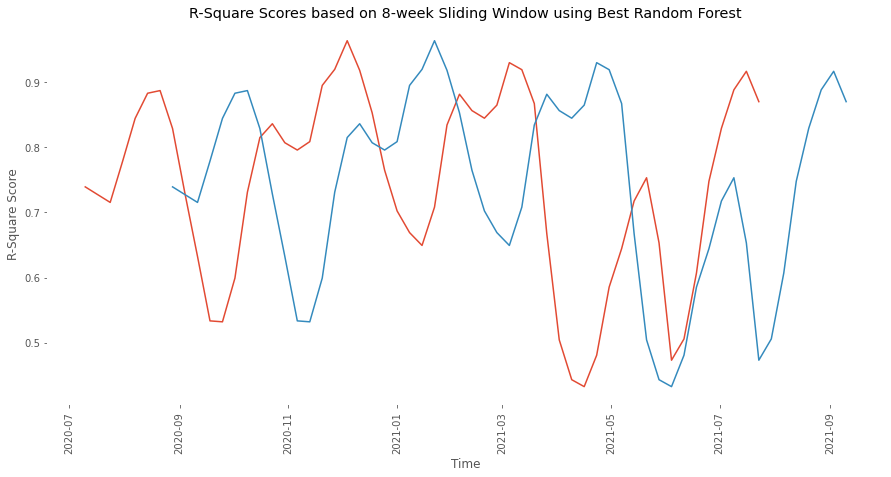

In [130]:
#import datetime as dt
#plot_dates = [str((str(dt.datetime.date(i[0])),str(dt.datetime.date(i[1])))) for i in plot_dates]

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(plot_dates,r2_scores)
ax.set_facecolor('white')
ax.set_ylabel('R-Square Score')
ax.set_xlabel('Time')
ax.set_title('R-Square Scores based on 8-week Sliding Window using Best Random Forest')
plt.xticks(rotation = 90)
plt.show()

In [131]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3162 entries, 0 to 3161
Data columns (total 36 columns):
 #   Column                                                           Non-Null Count  Dtype         
---  ------                                                           --------------  -----         
 0   state                                                            3162 non-null   object        
 1   date                                                             3162 non-null   datetime64[ns]
 2   c1_school closing                                                3162 non-null   float64       
 3   c1_flag                                                          3162 non-null   float64       
 4   c2_workplace closing                                             3162 non-null   float64       
 5   c2_flag                                                          3162 non-null   float64       
 6   c3_cancel public events                                          3162 non-null  